In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import Bidirectional
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#import chart_studio.plotly as py
#import plotly.offline as pyoff
#import plotly.graph_objs as go
#pyoff.init_notebook_mode()

In [2]:
data = pd.read_csv("Gift_Shops_MCC.csv", encoding="ISO-8859-1")

In [3]:
data.head()

PARTY_ID TRANS_TYPE_ECOM_POS_ATM  \
0  100000006022917                     POS   
1  100000003112786                     POS   
2  100000003112786                     POS   
3  100000003112786                     POS   
4  100000000718541                     POS   

                           MCC_High_level         Merchant Name  Year  Month  \
0  Gift, Card, Novelty and Souvenir Shops      DERAH TRADING CO  2022     10   
1  Gift, Card, Novelty and Souvenir Shops  BASTAT ALTAWFEER EST  2022      1   
2  Gift, Card, Novelty and Souvenir Shops  BASTAT ALTAWFEER EST  2022      6   
3  Gift, Card, Novelty and Souvenir Shops  BASTAT ALTAWFEER EST  2022      3   
4  Gift, Card, Novelty and Souvenir Shops   Hala Al Otaibi Trad  2022      7   

   Day  Daily_Sum_Debit_Card_TRANSACTION_AMOUNT  \
0    9                                      NaN   
1    4                                      NaN   
2   20                                      NaN   
3    5                                      NaN   
4    1                                      NaN   

   Daily_Count_Debit_Card_TRANSACTION_AMOUNT  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   Daily_Avg_Debit_Card_TRANSACTION_AMOUNT  ...  \
0                                      NaN  ...   
1                                      NaN  ...   
2                                      NaN  ...   
3                                      NaN  ...   
4                                      NaN  ...   

   Monthly_Avg_Debit_Card_TRANSACTION_AMOUNT  \
0                                        NaN   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4                                        NaN   

   Monthly_Sum_Credit_Card_TRANSACTION_AMOUNT  \
0                                      120.00   
1                                       80.00   
2                                      368.00   
3                                      396.75   
4                                       15.00   

   Monthly_Count_Credit_Card_TRANSACTION_AMOUNT  \
0                                             1   
1                                             1   
2                                             1   
3                                             1   
4                                             1   

   Monthly_Avg_Credit_Card_TRANSACTION_AMOUNT  \
0                                      120.00   
1                                       80.00   
2                                      368.00   
3                                      396.75   
4                                       15.00   

  Yearly_Sum_Debit_Card_TRANSACTION_AMOUNT  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  Yearly_Count_Debit_Card_TRANSACTION_AMOUNT  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

  Yearly_Avg_Debit_Card_TRANSACTION_AMOUNT  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

  Yearly_Sum_Credit_Card_TRANSACTION_AMOUNT  \
0                                    120.00   
1                                    844.75   
2                                    844.75   
3                                    844.75   
4                                     15.00   

  Yearly_Count_Credit_Card_TRANSACTIO

In [4]:
#data=data[(data['Year']==2014)|(data['Year']==2015)|(data['Year']==2016)]Daily_Sum_Debit_Card_TRANSACTION_AMOUNT

In [5]:
data ['Date'] = pd.to_datetime(dict (year=data.Year, month=data.Month, day=data.Day))
data=data[['Date','MCC_High_level','Daily_Sum_Debit_Card_TRANSACTION_AMOUNT','Daily_Sum_Credit_Card_TRANSACTION_AMOUNT']]
data.head()

Date                          MCC_High_level  \
0 2022-10-09  Gift, Card, Novelty and Souvenir Shops   
1 2022-01-04  Gift, Card, Novelty and Souvenir Shops   
2 2022-06-20  Gift, Card, Novelty and Souvenir Shops   
3 2022-03-05  Gift, Card, Novelty and Souvenir Shops   
4 2022-07-01  Gift, Card, Novelty and Souvenir Shops   

   Daily_Sum_Debit_Card_TRANSACTION_AMOUNT  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   Daily_Sum_Credit_Card_TRANSACTION_AMOUNT  
0                                    120.00  
1                                     80.00  
2                                    368.00  
3                                    396.75  
4                                     15.00

In [6]:
data["Daily_Sum_Debit_Card_TRANSACTION_AMOUNT"]=data["Daily_Sum_Debit_Card_TRANSACTION_AMOUNT"].fillna(0)
data["Daily_Sum_Credit_Card_TRANSACTION_AMOUNT"]=data["Daily_Sum_Credit_Card_TRANSACTION_AMOUNT"].fillna(0)
data['Total Sales']=data["Daily_Sum_Credit_Card_TRANSACTION_AMOUNT"]+data["Daily_Sum_Debit_Card_TRANSACTION_AMOUNT"]
data.drop(['Daily_Sum_Debit_Card_TRANSACTION_AMOUNT','Daily_Sum_Credit_Card_TRANSACTION_AMOUNT'],axis=1,inplace=True)
data = data.set_index('Date')
data.head()

MCC_High_level  Total Sales
Date                                                           
2022-10-09  Gift, Card, Novelty and Souvenir Shops       120.00
2022-01-04  Gift, Card, Novelty and Souvenir Shops        80.00
2022-06-20  Gift, Card, Novelty and Souvenir Shops       368.00
2022-03-05  Gift, Card, Novelty and Souvenir Shops       396.75
2022-07-01  Gift, Card, Novelty and Souvenir Shops        15.00

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 748277 entries, 2022-10-09 to 2023-01-18
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   MCC_High_level  748277 non-null  object 
 1   Total Sales     748277 non-null  float64
dtypes: float64(1), object(1)
memory usage: 17.1+ MB


In [8]:
"""
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 10))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Groceries and Supermarkets Time Series Plot")
plt.plot(data[data['MCC_High_level']=="Groceries and Supermarkets"]["Total Sales"])
"""

'\nplt.style.use("fivethirtyeight")\nplt.figure(figsize=(15, 10))\nplt.xlabel("Date")\nplt.ylabel("Sales")\nplt.title("Groceries and Supermarkets Time Series Plot")\nplt.plot(data[data[\'MCC_High_level\']=="Groceries and Supermarkets"]["Total Sales"])\n'

In [9]:
data.to_period("D").head()

MCC_High_level  Total Sales
Date                                                           
2022-10-09  Gift, Card, Novelty and Souvenir Shops       120.00
2022-01-04  Gift, Card, Novelty and Souvenir Shops        80.00
2022-06-20  Gift, Card, Novelty and Souvenir Shops       368.00
2022-03-05  Gift, Card, Novelty and Souvenir Shops       396.75
2022-07-01  Gift, Card, Novelty and Souvenir Shops        15.00

In [10]:
"""
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15, 10))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Groceries and Supermarkets Time Series Plot")
plt.plot(data[data['MCC_High_level']=="Groceries and Supermarkets"]["Total Sales"])
"""

'\nplt.style.use("fivethirtyeight")\nplt.figure(figsize=(15, 10))\nplt.xlabel("Date")\nplt.ylabel("Sales")\nplt.title("Groceries and Supermarkets Time Series Plot")\nplt.plot(data[data[\'MCC_High_level\']=="Groceries and Supermarkets"]["Total Sales"])\n'

In [11]:
data=data.sort_values('Date')
data['Total Sales']=data['Total Sales'].interpolate(option='spline')
data.head()

MCC_High_level  Total Sales
Date                                                           
2022-01-01  Gift, Card, Novelty and Souvenir Shops        44.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        58.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        90.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        23.00
2022-01-01  Gift, Card, Novelty and Souvenir Shops        17.25

In [12]:
"""
dec=seasonal_decompose(data['Total Sales'], model='multiplicable', period=6)
dec.plot()
"""

"\ndec=seasonal_decompose(data['Total Sales'], model='multiplicable', period=6)\ndec.plot()\n"

In [13]:
"""
# Run Dicky-Fuller test
adtest = adfuller(data['Total Sales'])
# Print test statistic
print(adtest[0])
# Print p-value
print(adtest[1])
"""

"\n# Run Dicky-Fuller test\nadtest = adfuller(data['Total Sales'])\n# Print test statistic\nprint(adtest[0])\n# Print p-value\nprint(adtest[1])\n"

In [14]:
data['Week']=data.index.strftime("%U")
data['Week']=data['Week'].astype('str')+data.index.year.astype('str')
data.set_index(['Week', 'MCC_High_level'], inplace=True)
data.head()

Total Sales
Week   MCC_High_level                                     
002022 Gift, Card, Novelty and Souvenir Shops        44.00
       Gift, Card, Novelty and Souvenir Shops        58.00
       Gift, Card, Novelty and Souvenir Shops        90.00
       Gift, Card, Novelty and Souvenir Shops        23.00
       Gift, Card, Novelty and Souvenir Shops        17.25

In [15]:
data.groupby(['MCC_High_level','Week'])['Total Sales'].transform('sum').duplicated().sort_values().head(100)

Week    MCC_High_level                        
002022  Gift, Card, Novelty and Souvenir Shops    False
442022  Gift, Card, Novelty and Souvenir Shops    False
132022  Gift, Card, Novelty and Souvenir Shops    False
302022  Gift, Card, Novelty and Souvenir Shops    False
252022  Gift, Card, Novelty and Souvenir Shops    False
                                                  ...  
422022  Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
        Gift, Card, Novelty and Souvenir Shops     True
Name: Total Sales, Length: 100, dtype: bool

In [16]:
dataw=data.groupby(['MCC_High_level','Week'])['Total Sales'].agg('sum')
#dataw=dataw.drop_duplicates()
dataw.head(10)

MCC_High_level                          Week  
Gift, Card, Novelty and Souvenir Shops  002022     292081.30
                                        012022    1676930.12
                                        012023    1613590.49
                                        022022    1622875.95
                                        022023    1419453.21
                                        032022    1157226.38
                                        032023    1136544.51
                                        042022    2138374.86
                                        042023    1645446.13
                                        052022    1775219.10
Name: Total Sales, dtype: float64

In [17]:
del data
#dataw=hampel(dataw)

# IQR
Q1 = np.percentile(dataw, 25,
                   interpolation = 'midpoint')
Q3 = np.percentile(dataw, 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

# Above Upper bound
upper=Q3+1.5*IQR
upper_array=np.array(dataw>=upper)
print("Upper Bound:",upper)
print(upper_array)
 
#Below Lower bound
lower=Q1-1.5*IQR
lower_array=np.array(dataw<=lower)
print("Lower Bound:",lower)
print(lower_array)

#dataw=dataw[(dataw<=upper) & (dataw>=lower)]
for i in range(len(dataw)):
    if dataw[i]>upper:
        dataw[i]=upper
    elif dataw[i]<lower:
        dataw[i]=lower

dataw.shape

Upper Bound: 3009931.0650000004
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False  True False]
Lower Bound: 463522.9850000001
[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


(64,)

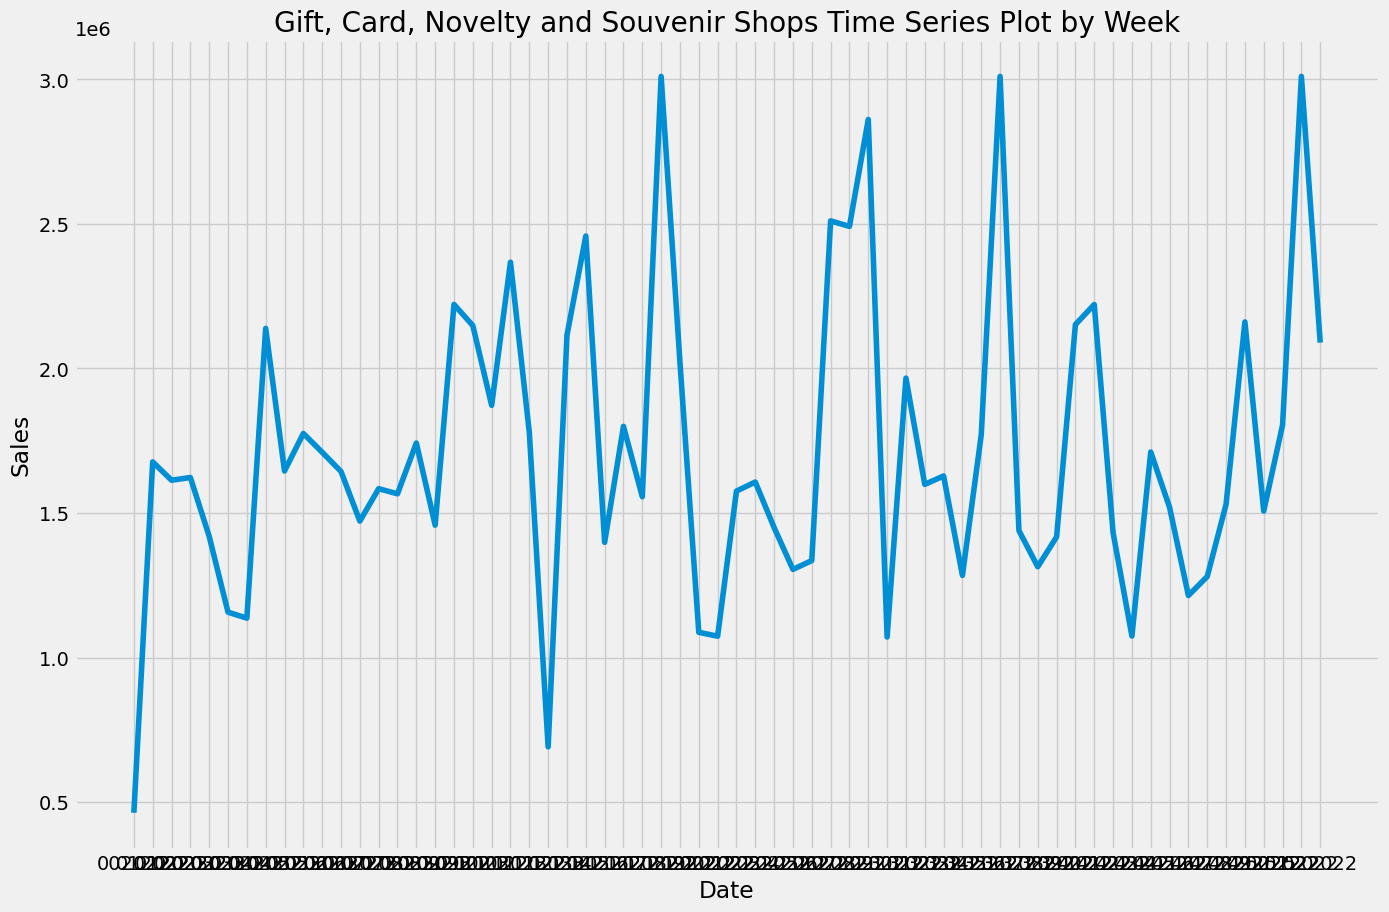

In [18]:
for n,g in dataw.groupby('MCC_High_level'):
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(15, 10))
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(n+" Time Series Plot by Week")
    plt.plot(g.droplevel(0))

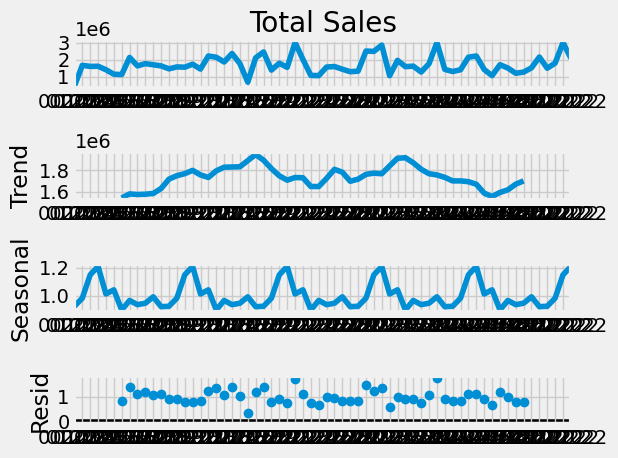

In [19]:
for n,g in dataw.groupby('MCC_High_level'):
    dec=seasonal_decompose(g.droplevel(0), model='multiplicable', period=12)
    dec.plot()

In [20]:
for n,g in dataw.groupby('MCC_High_level'):
    # Run Dicky-Fuller test
    adtest = adfuller(g.droplevel(0))
    # Print test statistic
    print(adtest[0])
    # Print p-value
    print(adtest[1])

-6.224593151328555
5.125147965978611e-08


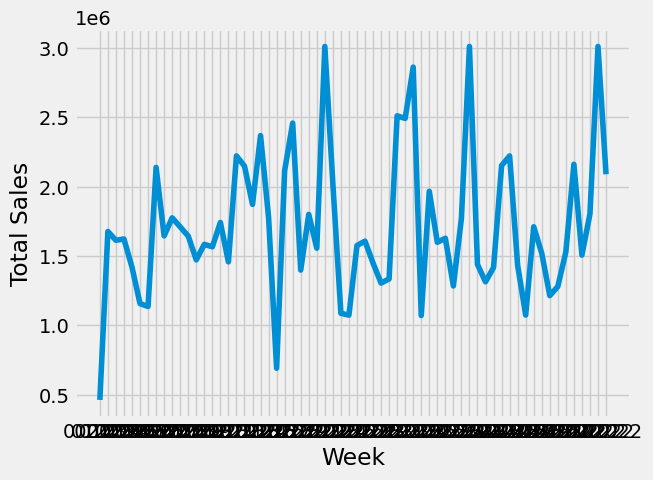

In [21]:
for n,g in dataw.groupby('MCC_High_level'):
    sns.lineplot(data=g.droplevel(0))

In [22]:
for n,g in dataw.groupby('MCC_High_level'):
    datawdiff=g.shift(3)
    datawst=g-datawdiff
    # Run Dicky-Fuller test
    adtest = adfuller(datawst.dropna().droplevel(0))
    # Print test statistic
    print(adtest[0])
    # Print p-value
    print(adtest[1])

-5.554118121088988
1.5952085334994468e-06


In [23]:
#dec=seasonal_decompose(datawst.dropna().droplevel(0), period=12)
#dec.plot()

In [24]:
#datawst=datawst.dropna()
#sns.lineplot(data=datawst.droplevel(0))

In [25]:
dataw.shape

(64,)

In [31]:
models=[]
for n,g in dataw.groupby('MCC_High_level'):
    #adding lags
    df_supervised=pd.DataFrame(g)
    df_supervised.info()
    for inc in range(1,13):
        field_name='lag_'+str(inc)
        #df_supervised[field_name]=df_supervised["Total Sales"].shift(3*inc)
        df_supervised[field_name]=df_supervised["Total Sales"].shift(inc)
    df_supervised=df_supervised.dropna()
    
    df_model = df_supervised.reset_index(drop=True)
    train, test = df_model[0:-5].values, df_model[-5:].values
    
    scaler = MinMaxScaler(feature_range = (-1,1))
    scaler.fit(train)
    train=train.reshape(train.shape[0],train.shape[1])
    train_scaled=scaler.transform(train)
    test=test.reshape(test.shape[0],test.shape[1])
    test_scaled=scaler.transform(test)
    
    trainx,trainy=train_scaled[:, 1:],train_scaled[:, 0:1]
    trainx=trainx.reshape(trainx.shape[0],1,trainx.shape[1])
    testx,testy=test_scaled[:, 1:],test_scaled[:, 0:1]
    testx=testx.reshape(testx.shape[0],1,testx.shape[1])
    
    num_units=[16,32,64,128]
    drop_prob=[0.1,0.15,0.2,0.25,0.3]
    dense_size=[50,100,200,400,800,1000]
    mse = None
    best_num_units=None
    best_drop_prob=None
    best_dense_size=None
    best_model=None
    error=float("inf")
    for n in num_units:
        for p in drop_prob:
            for d in dense_size:
                callback = EarlyStopping(monitor='loss', patience=50)
                model=Sequential()
                model.add(LSTM(n,batch_input_shape=(1,trainx.shape[1],trainx.shape[2]),stateful=False))
                model.add(Dropout(p))
                model.add(Dense(d))
                model.add(Dense(1))
                model.compile(loss='mean_squared_error', optimizer='adam')
                model.fit(trainx, trainy, epochs=500, batch_size=1, verbose=1, shuffle=False, callbacks=[callback])
                ypred=model.predict(testx, batch_size=1)

                ypred = ypred.reshape(ypred.shape[0], 1, ypred.shape[1])
                testpred=[]
                for idx in range(0, len(ypred)):
                    testpred.append(np.concatenate([ypred[idx], testx[idx]],axis=1))
                testpred=np.array(testpred)
                testpred=testpred.reshape(testpred.shape[0], testpred.shape[2])
                testpred_inverted=scaler.inverse_transform(testpred)
                #print(testpred_inverted)
                sales_df=pd.DataFrame({'week':g.droplevel(0).index, 'sales':g})[-5:]
                mse = np.square(np.subtract(sales_df['sales'].iloc[-5],testpred_inverted[0]-2000000)).mean()
                if mse<error:
                    error=mse
                    best_num_units=n
                    best_drop_prob=p
                    best_dense_size=d
                    best_model=model
    models.append(best_model)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 64 entries, ('Gift, Card, Novelty and Souvenir Shops', '002022') to ('Gift, Card, Novelty and Souvenir Shops', '522022')
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Sales  64 non-null     float64
dtypes: float64(1)
memory usage: 3.4+ KB
Epoch 1/500
47/47 [==============================] - 1s 892us/step - loss: 0.2137
Epoch 2/500
47/47 [==============================] - 0s 869us/step - loss: 0.1972
Epoch 3/500
47/47 [==============================] - 0s 870us/step - loss: 0.1857
Epoch 4/500
47/47 [==============================] - 0s 869us/step - loss: 0.1823
Epoch 5/500
47/47 [==============================] - 0s 870us/step - loss: 0.1707
Epoch 6/500
47/47 [==============================] - 0s 891us/step - loss: 0.1654
Epoch 7/500
47/47 [==============================] - 0s 868us/step - loss: 0.1572
Epoch 8/500
47/47 [==============================] - 0s 

47/47 [==============================] - 0s 912us/step - loss: 0.0365
Epoch 96/500
47/47 [==============================] - 0s 913us/step - loss: 0.0304
Epoch 97/500
47/47 [==============================] - 0s 912us/step - loss: 0.0319
Epoch 98/500
47/47 [==============================] - 0s 890us/step - loss: 0.0202
Epoch 99/500
47/47 [==============================] - 0s 913us/step - loss: 0.0435
Epoch 100/500
47/47 [==============================] - 0s 890us/step - loss: 0.0365
Epoch 101/500
47/47 [==============================] - 0s 913us/step - loss: 0.0314
Epoch 102/500
47/47 [==============================] - 0s 911us/step - loss: 0.0231
Epoch 103/500
47/47 [==============================] - 0s 933us/step - loss: 0.0268
Epoch 104/500
47/47 [==============================] - 0s 890us/step - loss: 0.0386
Epoch 105/500
47/47 [==============================] - 0s 890us/step - loss: 0.0213
Epoch 106/500
47/47 [==============================] - 0s 912us/step - loss: 0.0432
Epoch 107/

47/47 [==============================] - 0s 890us/step - loss: 0.0155
Epoch 193/500
47/47 [==============================] - 0s 868us/step - loss: 0.0198
Epoch 194/500
47/47 [==============================] - 0s 890us/step - loss: 0.0199
Epoch 195/500
47/47 [==============================] - 0s 890us/step - loss: 0.0121
Epoch 196/500
47/47 [==============================] - 0s 891us/step - loss: 0.0139
Epoch 197/500
47/47 [==============================] - 0s 891us/step - loss: 0.0307
Epoch 198/500
47/47 [==============================] - 0s 868us/step - loss: 0.0148
Epoch 199/500
47/47 [==============================] - 0s 890us/step - loss: 0.0129
Epoch 200/500
47/47 [==============================] - 0s 869us/step - loss: 0.0198
Epoch 201/500
47/47 [==============================] - 0s 890us/step - loss: 0.0176
Epoch 202/500
47/47 [==============================] - 0s 912us/step - loss: 0.0211
Epoch 203/500
47/47 [==============================] - 0s 890us/step - loss: 0.0171
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0077
Epoch 290/500
47/47 [==============================] - 0s 847us/step - loss: 0.0131
Epoch 291/500
47/47 [==============================] - 0s 857us/step - loss: 0.0070
Epoch 292/500
47/47 [==============================] - 0s 867us/step - loss: 0.0202
Epoch 293/500
47/47 [==============================] - 0s 846us/step - loss: 0.0071
Epoch 294/500
47/47 [==============================] - 0s 869us/step - loss: 0.0154
Epoch 295/500
47/47 [==============================] - 0s 868us/step - loss: 0.0093
Epoch 296/500
47/47 [==============================] - 0s 869us/step - loss: 0.0163
Epoch 297/500
47/47 [==============================] - 0s 954us/step - loss: 0.0070
Epoch 298/500
47/47 [==============================] - 0s 890us/step - loss: 0.0106
Epoch 299/500
47/47 [==============================] - 0s 847us/step - loss: 0.0084
Epoch 300/500
47/47 [==============================] - 0s 869us/step - loss: 0.0101
Epoch 

47/47 [==============================] - 0s 867us/step - loss: 0.0079
Epoch 387/500
47/47 [==============================] - 0s 892us/step - loss: 0.0057
Epoch 388/500
47/47 [==============================] - 0s 869us/step - loss: 0.0073
Epoch 389/500
47/47 [==============================] - 0s 868us/step - loss: 0.0140
Epoch 390/500
47/47 [==============================] - 0s 890us/step - loss: 0.0117
Epoch 391/500
47/47 [==============================] - 0s 890us/step - loss: 0.0101
Epoch 392/500
47/47 [==============================] - 0s 869us/step - loss: 0.0076
Epoch 393/500
47/47 [==============================] - 0s 891us/step - loss: 0.0100
Epoch 394/500
47/47 [==============================] - 0s 868us/step - loss: 0.0084
Epoch 395/500
5/5 [==============================] - 0s 1ms/step
Epoch 1/500
47/47 [==============================] - 1s 898us/step - loss: 0.2062
Epoch 2/500
47/47 [==============================] - 0s 869us/step - loss: 0.1935
Epoch 3/500
47/47 [==========

47/47 [==============================] - 0s 934us/step - loss: 0.0223
Epoch 90/500
47/47 [==============================] - 0s 890us/step - loss: 0.0261
Epoch 91/500
47/47 [==============================] - 0s 912us/step - loss: 0.0229
Epoch 92/500
47/47 [==============================] - 0s 890us/step - loss: 0.0226
Epoch 93/500
47/47 [==============================] - 0s 890us/step - loss: 0.0213
Epoch 94/500
47/47 [==============================] - 0s 868us/step - loss: 0.0200
Epoch 95/500
47/47 [==============================] - 0s 890us/step - loss: 0.0261
Epoch 96/500
47/47 [==============================] - 0s 890us/step - loss: 0.0321
Epoch 97/500
47/47 [==============================] - 0s 902us/step - loss: 0.0272
Epoch 98/500
47/47 [==============================] - 0s 869us/step - loss: 0.0195
Epoch 99/500
47/47 [==============================] - 0s 890us/step - loss: 0.0208
Epoch 100/500
47/47 [==============================] - 0s 869us/step - loss: 0.0416
Epoch 101/500
47

47/47 [==============================] - 0s 890us/step - loss: 0.0197
Epoch 187/500
47/47 [==============================] - 0s 868us/step - loss: 0.0159
Epoch 188/500
47/47 [==============================] - 0s 891us/step - loss: 0.0178
Epoch 189/500
47/47 [==============================] - 0s 890us/step - loss: 0.0105
Epoch 190/500
47/47 [==============================] - 0s 846us/step - loss: 0.0227
Epoch 191/500
47/47 [==============================] - 0s 846us/step - loss: 0.0250
Epoch 192/500
47/47 [==============================] - 0s 846us/step - loss: 0.0280
Epoch 193/500
47/47 [==============================] - 0s 869us/step - loss: 0.0210
Epoch 194/500
47/47 [==============================] - 0s 868us/step - loss: 0.0165
Epoch 195/500
47/47 [==============================] - 0s 869us/step - loss: 0.0190
Epoch 196/500
47/47 [==============================] - 0s 869us/step - loss: 0.0167
Epoch 197/500
47/47 [==============================] - 0s 868us/step - loss: 0.0173
Epoch 

47/47 [==============================] - 0s 935us/step - loss: 0.1370
Epoch 11/500
47/47 [==============================] - 0s 911us/step - loss: 0.1433
Epoch 12/500
47/47 [==============================] - 0s 893us/step - loss: 0.1277
Epoch 13/500
47/47 [==============================] - 0s 869us/step - loss: 0.1241
Epoch 14/500
47/47 [==============================] - 0s 913us/step - loss: 0.1303
Epoch 15/500
47/47 [==============================] - 0s 890us/step - loss: 0.1086
Epoch 16/500
47/47 [==============================] - 0s 912us/step - loss: 0.1075
Epoch 17/500
47/47 [==============================] - 0s 934us/step - loss: 0.1051
Epoch 18/500
47/47 [==============================] - 0s 890us/step - loss: 0.0986
Epoch 19/500
47/47 [==============================] - 0s 867us/step - loss: 0.0881
Epoch 20/500
47/47 [==============================] - 0s 868us/step - loss: 0.0958
Epoch 21/500
47/47 [==============================] - 0s 869us/step - loss: 0.1249
Epoch 22/500
47/4

47/47 [==============================] - 0s 869us/step - loss: 0.0272
Epoch 109/500
47/47 [==============================] - 0s 912us/step - loss: 0.0254
Epoch 110/500
47/47 [==============================] - 0s 891us/step - loss: 0.0261
Epoch 111/500
47/47 [==============================] - 0s 933us/step - loss: 0.0312
Epoch 112/500
47/47 [==============================] - 0s 890us/step - loss: 0.0286
Epoch 113/500
47/47 [==============================] - 0s 891us/step - loss: 0.0368
Epoch 114/500
47/47 [==============================] - 0s 912us/step - loss: 0.0292
Epoch 115/500
47/47 [==============================] - 0s 890us/step - loss: 0.0379
Epoch 116/500
47/47 [==============================] - 0s 868us/step - loss: 0.0233
Epoch 117/500
47/47 [==============================] - 0s 890us/step - loss: 0.0279
Epoch 118/500
47/47 [==============================] - 0s 890us/step - loss: 0.0477
Epoch 119/500
47/47 [==============================] - 0s 890us/step - loss: 0.0346
Epoch 

47/47 [==============================] - 0s 891us/step - loss: 0.0129
Epoch 206/500
47/47 [==============================] - 0s 890us/step - loss: 0.0142
Epoch 207/500
47/47 [==============================] - 0s 891us/step - loss: 0.0220
Epoch 208/500
47/47 [==============================] - 0s 869us/step - loss: 0.0145
Epoch 209/500
47/47 [==============================] - 0s 890us/step - loss: 0.0167
Epoch 210/500
47/47 [==============================] - 0s 867us/step - loss: 0.0179
Epoch 211/500
47/47 [==============================] - 0s 889us/step - loss: 0.0107
Epoch 212/500
47/47 [==============================] - 0s 867us/step - loss: 0.0173
Epoch 213/500
47/47 [==============================] - 0s 868us/step - loss: 0.0149
Epoch 214/500
47/47 [==============================] - 0s 868us/step - loss: 0.0165
Epoch 215/500
47/47 [==============================] - 0s 890us/step - loss: 0.0206
Epoch 216/500
47/47 [==============================] - 0s 891us/step - loss: 0.0127
Epoch 

47/47 [==============================] - 0s 913us/step - loss: 0.1283
Epoch 14/500
47/47 [==============================] - 0s 892us/step - loss: 0.1244
Epoch 15/500
47/47 [==============================] - 0s 891us/step - loss: 0.1058
Epoch 16/500
47/47 [==============================] - 0s 912us/step - loss: 0.1268
Epoch 17/500
47/47 [==============================] - 0s 914us/step - loss: 0.1005
Epoch 18/500
47/47 [==============================] - 0s 868us/step - loss: 0.1187
Epoch 19/500
47/47 [==============================] - 0s 890us/step - loss: 0.0972
Epoch 20/500
47/47 [==============================] - 0s 890us/step - loss: 0.0863
Epoch 21/500
47/47 [==============================] - 0s 846us/step - loss: 0.1019
Epoch 22/500
47/47 [==============================] - 0s 846us/step - loss: 0.0829
Epoch 23/500
47/47 [==============================] - 0s 868us/step - loss: 0.0865
Epoch 24/500
47/47 [==============================] - 0s 848us/step - loss: 0.0833
Epoch 25/500
47/4

47/47 [==============================] - 0s 868us/step - loss: 0.0430
Epoch 112/500
47/47 [==============================] - 0s 869us/step - loss: 0.0284
Epoch 113/500
47/47 [==============================] - 0s 869us/step - loss: 0.0346
Epoch 114/500
47/47 [==============================] - 0s 868us/step - loss: 0.0438
Epoch 115/500
47/47 [==============================] - 0s 867us/step - loss: 0.0324
Epoch 116/500
47/47 [==============================] - 0s 868us/step - loss: 0.0247
Epoch 117/500
47/47 [==============================] - 0s 868us/step - loss: 0.0254
Epoch 118/500
47/47 [==============================] - 0s 868us/step - loss: 0.0311
Epoch 119/500
47/47 [==============================] - 0s 911us/step - loss: 0.0218
Epoch 120/500
47/47 [==============================] - 0s 868us/step - loss: 0.0218
Epoch 121/500
47/47 [==============================] - 0s 869us/step - loss: 0.0410
Epoch 122/500
47/47 [==============================] - 0s 890us/step - loss: 0.0297
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0144
Epoch 209/500
47/47 [==============================] - 0s 849us/step - loss: 0.0218
Epoch 210/500
47/47 [==============================] - 0s 896us/step - loss: 0.0241
Epoch 211/500
47/47 [==============================] - 0s 870us/step - loss: 0.0237
Epoch 212/500
47/47 [==============================] - 0s 849us/step - loss: 0.0164
Epoch 213/500
47/47 [==============================] - 0s 869us/step - loss: 0.0117
Epoch 214/500
47/47 [==============================] - 0s 868us/step - loss: 0.0218
Epoch 215/500
47/47 [==============================] - 0s 869us/step - loss: 0.0257
Epoch 216/500
47/47 [==============================] - 0s 869us/step - loss: 0.0310
Epoch 217/500
47/47 [==============================] - 0s 868us/step - loss: 0.0256
Epoch 218/500
47/47 [==============================] - 0s 847us/step - loss: 0.0174
Epoch 219/500
47/47 [==============================] - 0s 891us/step - loss: 0.0317
Epoch 

47/47 [==============================] - 0s 890us/step - loss: 0.0148
Epoch 306/500
47/47 [==============================] - 0s 867us/step - loss: 0.0170
Epoch 307/500
47/47 [==============================] - 0s 912us/step - loss: 0.0135
Epoch 308/500
47/47 [==============================] - 0s 890us/step - loss: 0.0163
Epoch 309/500
47/47 [==============================] - 0s 868us/step - loss: 0.0127
Epoch 310/500
47/47 [==============================] - 0s 868us/step - loss: 0.0102
Epoch 311/500
47/47 [==============================] - 0s 913us/step - loss: 0.0086
Epoch 312/500
47/47 [==============================] - 0s 868us/step - loss: 0.0150
Epoch 313/500
47/47 [==============================] - 0s 868us/step - loss: 0.0163
Epoch 314/500
47/47 [==============================] - 0s 890us/step - loss: 0.0155
Epoch 315/500
47/47 [==============================] - 0s 869us/step - loss: 0.0231
Epoch 316/500
47/47 [==============================] - 0s 869us/step - loss: 0.0075
Epoch 

47/47 [==============================] - 0s 890us/step - loss: 0.0510
Epoch 73/500
47/47 [==============================] - 0s 867us/step - loss: 0.0451
Epoch 74/500
47/47 [==============================] - 0s 868us/step - loss: 0.0365
Epoch 75/500
47/47 [==============================] - 0s 890us/step - loss: 0.0535
Epoch 76/500
47/47 [==============================] - 0s 868us/step - loss: 0.0411
Epoch 77/500
47/47 [==============================] - 0s 868us/step - loss: 0.0514
Epoch 78/500
47/47 [==============================] - 0s 890us/step - loss: 0.0436
Epoch 79/500
47/47 [==============================] - 0s 868us/step - loss: 0.0432
Epoch 80/500
47/47 [==============================] - 0s 869us/step - loss: 0.0437
Epoch 81/500
47/47 [==============================] - 0s 869us/step - loss: 0.0378
Epoch 82/500
47/47 [==============================] - 0s 867us/step - loss: 0.0439
Epoch 83/500
47/47 [==============================] - 0s 869us/step - loss: 0.0338
Epoch 84/500
47/4

47/47 [==============================] - 0s 956us/step - loss: 0.0159
Epoch 171/500
47/47 [==============================] - 0s 868us/step - loss: 0.0194
Epoch 172/500
47/47 [==============================] - 0s 890us/step - loss: 0.0202
Epoch 173/500
47/47 [==============================] - 0s 869us/step - loss: 0.0167
Epoch 174/500
47/47 [==============================] - 0s 868us/step - loss: 0.0166
Epoch 175/500
47/47 [==============================] - 0s 846us/step - loss: 0.0278
Epoch 176/500
47/47 [==============================] - 0s 869us/step - loss: 0.0175
Epoch 177/500
47/47 [==============================] - 0s 868us/step - loss: 0.0223
Epoch 178/500
47/47 [==============================] - 0s 867us/step - loss: 0.0243
Epoch 179/500
47/47 [==============================] - 0s 868us/step - loss: 0.0182
Epoch 180/500
47/47 [==============================] - 0s 868us/step - loss: 0.0193
Epoch 181/500
47/47 [==============================] - 0s 891us/step - loss: 0.0163
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0162
Epoch 268/500
47/47 [==============================] - 0s 847us/step - loss: 0.0173
Epoch 269/500
47/47 [==============================] - 0s 847us/step - loss: 0.0243
Epoch 270/500
47/47 [==============================] - 0s 846us/step - loss: 0.0171
Epoch 271/500
47/47 [==============================] - 0s 846us/step - loss: 0.0108
Epoch 272/500
47/47 [==============================] - 0s 847us/step - loss: 0.0130
Epoch 273/500
47/47 [==============================] - 0s 868us/step - loss: 0.0125
Epoch 274/500
47/47 [==============================] - 0s 846us/step - loss: 0.0156
Epoch 275/500
47/47 [==============================] - 0s 847us/step - loss: 0.0164
Epoch 276/500
47/47 [==============================] - 0s 847us/step - loss: 0.0199
Epoch 277/500
47/47 [==============================] - 0s 846us/step - loss: 0.0207
Epoch 278/500
47/47 [==============================] - 0s 847us/step - loss: 0.0138
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0594
Epoch 58/500
47/47 [==============================] - 0s 847us/step - loss: 0.0578
Epoch 59/500
47/47 [==============================] - 0s 847us/step - loss: 0.0402
Epoch 60/500
47/47 [==============================] - 0s 846us/step - loss: 0.0512
Epoch 61/500
47/47 [==============================] - 0s 891us/step - loss: 0.0402
Epoch 62/500
47/47 [==============================] - 0s 868us/step - loss: 0.0467
Epoch 63/500
47/47 [==============================] - 0s 848us/step - loss: 0.0373
Epoch 64/500
47/47 [==============================] - 0s 869us/step - loss: 0.0423
Epoch 65/500
47/47 [==============================] - 0s 847us/step - loss: 0.0423
Epoch 66/500
47/47 [==============================] - 0s 847us/step - loss: 0.0315
Epoch 67/500
47/47 [==============================] - 0s 846us/step - loss: 0.0418
Epoch 68/500
47/47 [==============================] - 0s 847us/step - loss: 0.0470
Epoch 69/500
47/4

47/47 [==============================] - 0s 847us/step - loss: 0.0184
Epoch 156/500
47/47 [==============================] - 0s 847us/step - loss: 0.0242
Epoch 157/500
47/47 [==============================] - 0s 869us/step - loss: 0.0295
Epoch 158/500
47/47 [==============================] - 0s 870us/step - loss: 0.0241
Epoch 159/500
47/47 [==============================] - 0s 868us/step - loss: 0.0176
Epoch 160/500
47/47 [==============================] - 0s 868us/step - loss: 0.0206
Epoch 161/500
47/47 [==============================] - 0s 868us/step - loss: 0.0235
Epoch 162/500
47/47 [==============================] - 0s 846us/step - loss: 0.0157
Epoch 163/500
47/47 [==============================] - 0s 846us/step - loss: 0.0169
Epoch 164/500
47/47 [==============================] - 0s 868us/step - loss: 0.0246
Epoch 165/500
47/47 [==============================] - 0s 869us/step - loss: 0.0371
Epoch 166/500
47/47 [==============================] - 0s 846us/step - loss: 0.0193
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0155
Epoch 253/500
47/47 [==============================] - 0s 847us/step - loss: 0.0125
Epoch 254/500
47/47 [==============================] - 0s 869us/step - loss: 0.0142
Epoch 255/500
47/47 [==============================] - 0s 890us/step - loss: 0.0108
Epoch 256/500
47/47 [==============================] - 0s 911us/step - loss: 0.0156
Epoch 257/500
47/47 [==============================] - 0s 868us/step - loss: 0.0139
Epoch 258/500
47/47 [==============================] - 0s 869us/step - loss: 0.0208
Epoch 259/500
47/47 [==============================] - 0s 847us/step - loss: 0.0167
Epoch 260/500
47/47 [==============================] - 0s 869us/step - loss: 0.0151
Epoch 261/500
47/47 [==============================] - 0s 846us/step - loss: 0.0214
Epoch 262/500
47/47 [==============================] - 0s 848us/step - loss: 0.0168
Epoch 263/500
47/47 [==============================] - 0s 846us/step - loss: 0.0146
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0089
Epoch 350/500
47/47 [==============================] - 0s 847us/step - loss: 0.0135
Epoch 351/500
47/47 [==============================] - 0s 869us/step - loss: 0.0099
Epoch 352/500
47/47 [==============================] - 0s 890us/step - loss: 0.0092
Epoch 353/500
47/47 [==============================] - 0s 846us/step - loss: 0.0122
Epoch 354/500
47/47 [==============================] - 0s 868us/step - loss: 0.0059
Epoch 355/500
47/47 [==============================] - 0s 847us/step - loss: 0.0150
Epoch 356/500
47/47 [==============================] - 0s 868us/step - loss: 0.0132
Epoch 357/500
47/47 [==============================] - 0s 847us/step - loss: 0.0106
Epoch 358/500
47/47 [==============================] - 0s 868us/step - loss: 0.0141
Epoch 359/500
47/47 [==============================] - 0s 868us/step - loss: 0.0094
Epoch 360/500
47/47 [==============================] - 0s 846us/step - loss: 0.0101
Epoch 

47/47 [==============================] - 0s 848us/step - loss: 0.0056
Epoch 447/500
47/47 [==============================] - 0s 868us/step - loss: 0.0059
Epoch 448/500
47/47 [==============================] - 0s 847us/step - loss: 0.0055
Epoch 449/500
47/47 [==============================] - 0s 880us/step - loss: 0.0163
Epoch 450/500
47/47 [==============================] - 0s 869us/step - loss: 0.0080
Epoch 451/500
47/47 [==============================] - 0s 868us/step - loss: 0.0081
Epoch 452/500
47/47 [==============================] - 0s 847us/step - loss: 0.0120
Epoch 453/500
47/47 [==============================] - 0s 868us/step - loss: 0.0091
Epoch 454/500
47/47 [==============================] - 0s 868us/step - loss: 0.0106
Epoch 455/500
47/47 [==============================] - 0s 847us/step - loss: 0.0092
Epoch 456/500
47/47 [==============================] - 0s 869us/step - loss: 0.0060
Epoch 457/500
47/47 [==============================] - 0s 868us/step - loss: 0.0054
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0404
Epoch 83/500
47/47 [==============================] - 0s 847us/step - loss: 0.0375
Epoch 84/500
47/47 [==============================] - 0s 848us/step - loss: 0.0582
Epoch 85/500
47/47 [==============================] - 0s 847us/step - loss: 0.0367
Epoch 86/500
47/47 [==============================] - 0s 846us/step - loss: 0.0415
Epoch 87/500
47/47 [==============================] - 0s 847us/step - loss: 0.0556
Epoch 88/500
47/47 [==============================] - 0s 847us/step - loss: 0.0383
Epoch 89/500
47/47 [==============================] - 0s 892us/step - loss: 0.0306
Epoch 90/500
47/47 [==============================] - 0s 868us/step - loss: 0.0384
Epoch 91/500
47/47 [==============================] - 0s 846us/step - loss: 0.0355
Epoch 92/500
47/47 [==============================] - 0s 847us/step - loss: 0.0324
Epoch 93/500
47/47 [==============================] - 0s 846us/step - loss: 0.0303
Epoch 94/500
47/4

47/47 [==============================] - 0s 869us/step - loss: 0.0249
Epoch 180/500
47/47 [==============================] - 0s 847us/step - loss: 0.0262
Epoch 181/500
47/47 [==============================] - 0s 869us/step - loss: 0.0329
Epoch 182/500
47/47 [==============================] - 0s 847us/step - loss: 0.0234
Epoch 183/500
47/47 [==============================] - 0s 868us/step - loss: 0.0345
Epoch 184/500
47/47 [==============================] - 0s 847us/step - loss: 0.0176
Epoch 185/500
47/47 [==============================] - 0s 848us/step - loss: 0.0210
Epoch 186/500
47/47 [==============================] - 0s 846us/step - loss: 0.0279
Epoch 187/500
47/47 [==============================] - 0s 868us/step - loss: 0.0209
Epoch 188/500
47/47 [==============================] - 0s 891us/step - loss: 0.0197
Epoch 189/500
47/47 [==============================] - 0s 889us/step - loss: 0.0251
Epoch 190/500
47/47 [==============================] - 0s 868us/step - loss: 0.0293
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0142
Epoch 277/500
47/47 [==============================] - 0s 846us/step - loss: 0.0170
Epoch 278/500
47/47 [==============================] - 0s 847us/step - loss: 0.0177
Epoch 279/500
47/47 [==============================] - 0s 846us/step - loss: 0.0223
Epoch 280/500
47/47 [==============================] - 0s 868us/step - loss: 0.0289
Epoch 281/500
47/47 [==============================] - 0s 868us/step - loss: 0.0174
Epoch 282/500
47/47 [==============================] - 0s 847us/step - loss: 0.0136
Epoch 283/500
47/47 [==============================] - 0s 869us/step - loss: 0.0117
Epoch 284/500
47/47 [==============================] - 0s 846us/step - loss: 0.0182
Epoch 285/500
47/47 [==============================] - 0s 869us/step - loss: 0.0210
Epoch 286/500
47/47 [==============================] - 0s 847us/step - loss: 0.0248
Epoch 287/500
47/47 [==============================] - 0s 890us/step - loss: 0.0158
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.0119
Epoch 374/500
47/47 [==============================] - 0s 868us/step - loss: 0.0159
Epoch 375/500
47/47 [==============================] - 0s 846us/step - loss: 0.0194
Epoch 376/500
47/47 [==============================] - 0s 847us/step - loss: 0.0090
Epoch 377/500
47/47 [==============================] - 0s 846us/step - loss: 0.0121
Epoch 378/500
47/47 [==============================] - 0s 847us/step - loss: 0.0152
Epoch 379/500
47/47 [==============================] - 0s 868us/step - loss: 0.0146
Epoch 380/500
47/47 [==============================] - 0s 847us/step - loss: 0.0095
Epoch 381/500
47/47 [==============================] - 0s 868us/step - loss: 0.0176
Epoch 382/500
47/47 [==============================] - 0s 847us/step - loss: 0.0122
Epoch 383/500
47/47 [==============================] - 0s 869us/step - loss: 0.0119
Epoch 384/500
47/47 [==============================] - 0s 846us/step - loss: 0.0135
Epoch 

47/47 [==============================] - 0s 825us/step - loss: 0.0478
Epoch 78/500
47/47 [==============================] - 0s 847us/step - loss: 0.0449
Epoch 79/500
47/47 [==============================] - 0s 869us/step - loss: 0.0389
Epoch 80/500
47/47 [==============================] - 0s 846us/step - loss: 0.0557
Epoch 81/500
47/47 [==============================] - 0s 847us/step - loss: 0.0424
Epoch 82/500
47/47 [==============================] - 0s 846us/step - loss: 0.0449
Epoch 83/500
47/47 [==============================] - 0s 847us/step - loss: 0.0373
Epoch 84/500
47/47 [==============================] - 0s 890us/step - loss: 0.0380
Epoch 85/500
47/47 [==============================] - 0s 869us/step - loss: 0.0403
Epoch 86/500
47/47 [==============================] - 0s 847us/step - loss: 0.0336
Epoch 87/500
47/47 [==============================] - 0s 825us/step - loss: 0.0536
Epoch 88/500
47/47 [==============================] - 0s 868us/step - loss: 0.0588
Epoch 89/500
47/4

Epoch 175/500
47/47 [==============================] - 0s 847us/step - loss: 0.0302
Epoch 176/500
47/47 [==============================] - 0s 847us/step - loss: 0.0260
Epoch 177/500
47/47 [==============================] - 0s 847us/step - loss: 0.0261
Epoch 178/500
47/47 [==============================] - 0s 846us/step - loss: 0.0332
Epoch 179/500
47/47 [==============================] - 0s 846us/step - loss: 0.0260
Epoch 180/500
47/47 [==============================] - 0s 825us/step - loss: 0.0252
Epoch 181/500
47/47 [==============================] - 0s 847us/step - loss: 0.0261
Epoch 182/500
47/47 [==============================] - 0s 847us/step - loss: 0.0322
Epoch 183/500
47/47 [==============================] - 0s 847us/step - loss: 0.0156
Epoch 184/500
47/47 [==============================] - 0s 890us/step - loss: 0.0310
Epoch 185/500
47/47 [==============================] - 0s 847us/step - loss: 0.0201
Epoch 186/500
47/47 [==============================] - 0s 846us/step - loss:

47/47 [==============================] - 0s 847us/step - loss: 0.1025
Epoch 20/500
47/47 [==============================] - 0s 890us/step - loss: 0.1038
Epoch 21/500
47/47 [==============================] - 0s 847us/step - loss: 0.1033
Epoch 22/500
47/47 [==============================] - 0s 868us/step - loss: 0.0866
Epoch 23/500
47/47 [==============================] - 0s 870us/step - loss: 0.0863
Epoch 24/500
47/47 [==============================] - 0s 847us/step - loss: 0.0788
Epoch 25/500
47/47 [==============================] - 0s 890us/step - loss: 0.0893
Epoch 26/500
47/47 [==============================] - 0s 890us/step - loss: 0.0804
Epoch 27/500
47/47 [==============================] - 0s 848us/step - loss: 0.0663
Epoch 28/500
47/47 [==============================] - 0s 912us/step - loss: 0.0839
Epoch 29/500
47/47 [==============================] - 0s 848us/step - loss: 0.0841
Epoch 30/500
47/47 [==============================] - 0s 868us/step - loss: 0.0763
Epoch 31/500
47/4

47/47 [==============================] - 0s 847us/step - loss: 0.0282
Epoch 118/500
47/47 [==============================] - 0s 868us/step - loss: 0.0210
Epoch 119/500
47/47 [==============================] - 0s 846us/step - loss: 0.0298
Epoch 120/500
47/47 [==============================] - 0s 869us/step - loss: 0.0357
Epoch 121/500
47/47 [==============================] - 0s 869us/step - loss: 0.0293
Epoch 122/500
47/47 [==============================] - 0s 890us/step - loss: 0.0298
Epoch 123/500
47/47 [==============================] - 0s 869us/step - loss: 0.0288
Epoch 124/500
47/47 [==============================] - 0s 847us/step - loss: 0.0283
Epoch 125/500
47/47 [==============================] - 0s 846us/step - loss: 0.0303
Epoch 126/500
47/47 [==============================] - 0s 846us/step - loss: 0.0367
Epoch 127/500
47/47 [==============================] - 0s 869us/step - loss: 0.0402
Epoch 128/500
47/47 [==============================] - 0s 847us/step - loss: 0.0256
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0306
Epoch 215/500
47/47 [==============================] - 0s 848us/step - loss: 0.0186
Epoch 216/500
47/47 [==============================] - 0s 847us/step - loss: 0.0179
Epoch 217/500
47/47 [==============================] - 0s 847us/step - loss: 0.0148
Epoch 218/500
47/47 [==============================] - 0s 847us/step - loss: 0.0181
Epoch 219/500
47/47 [==============================] - 0s 890us/step - loss: 0.0227
Epoch 220/500
47/47 [==============================] - 0s 868us/step - loss: 0.0238
Epoch 221/500
47/47 [==============================] - 0s 847us/step - loss: 0.0220
Epoch 222/500
47/47 [==============================] - 0s 869us/step - loss: 0.0256
Epoch 223/500
47/47 [==============================] - 0s 869us/step - loss: 0.0182
Epoch 224/500
47/47 [==============================] - 0s 847us/step - loss: 0.0245
Epoch 225/500
47/47 [==============================] - 0s 847us/step - loss: 0.0207
Epoch 

47/47 [==============================] - 0s 846us/step - loss: 0.0133
Epoch 312/500
47/47 [==============================] - 0s 846us/step - loss: 0.0168
Epoch 313/500
47/47 [==============================] - 0s 868us/step - loss: 0.0167
Epoch 314/500
47/47 [==============================] - 0s 847us/step - loss: 0.0200
Epoch 315/500
47/47 [==============================] - 0s 868us/step - loss: 0.0175
Epoch 316/500
47/47 [==============================] - 0s 870us/step - loss: 0.0131
Epoch 317/500
47/47 [==============================] - 0s 869us/step - loss: 0.0133
Epoch 318/500
47/47 [==============================] - 0s 846us/step - loss: 0.0129
Epoch 319/500
47/47 [==============================] - 0s 847us/step - loss: 0.0111
Epoch 320/500
47/47 [==============================] - 0s 846us/step - loss: 0.0119
Epoch 321/500
47/47 [==============================] - 0s 846us/step - loss: 0.0103
Epoch 322/500
47/47 [==============================] - 0s 868us/step - loss: 0.0138
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.0626
Epoch 76/500
47/47 [==============================] - 0s 868us/step - loss: 0.0682
Epoch 77/500
47/47 [==============================] - 0s 868us/step - loss: 0.0657
Epoch 78/500
47/47 [==============================] - 0s 848us/step - loss: 0.0574
Epoch 79/500
47/47 [==============================] - 0s 868us/step - loss: 0.0552
Epoch 80/500
47/47 [==============================] - 0s 847us/step - loss: 0.0577
Epoch 81/500
47/47 [==============================] - 0s 869us/step - loss: 0.0486
Epoch 82/500
47/47 [==============================] - 0s 847us/step - loss: 0.0392
Epoch 83/500
47/47 [==============================] - 0s 869us/step - loss: 0.0418
Epoch 84/500
47/47 [==============================] - 0s 857us/step - loss: 0.0576
Epoch 85/500
47/47 [==============================] - 0s 868us/step - loss: 0.0517
Epoch 86/500
47/47 [==============================] - 0s 846us/step - loss: 0.0446
Epoch 87/500
47/4

47/47 [==============================] - 0s 868us/step - loss: 0.0256
Epoch 174/500
47/47 [==============================] - 0s 869us/step - loss: 0.0227
Epoch 175/500
47/47 [==============================] - 0s 890us/step - loss: 0.0333
Epoch 176/500
47/47 [==============================] - 0s 890us/step - loss: 0.0209
Epoch 177/500
47/47 [==============================] - 0s 869us/step - loss: 0.0202
Epoch 178/500
47/47 [==============================] - 0s 890us/step - loss: 0.0461
Epoch 179/500
47/47 [==============================] - 0s 869us/step - loss: 0.0230
Epoch 180/500
47/47 [==============================] - 0s 890us/step - loss: 0.0152
Epoch 181/500
47/47 [==============================] - 0s 890us/step - loss: 0.0193
Epoch 182/500
47/47 [==============================] - 0s 869us/step - loss: 0.0258
Epoch 183/500
47/47 [==============================] - 0s 868us/step - loss: 0.0260
Epoch 184/500
47/47 [==============================] - 0s 868us/step - loss: 0.0186
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0156
Epoch 271/500
47/47 [==============================] - 0s 869us/step - loss: 0.0212
Epoch 272/500
47/47 [==============================] - 0s 890us/step - loss: 0.0217
Epoch 273/500
47/47 [==============================] - 0s 868us/step - loss: 0.0141
Epoch 274/500
47/47 [==============================] - 0s 890us/step - loss: 0.0240
Epoch 275/500
47/47 [==============================] - 0s 868us/step - loss: 0.0219
Epoch 276/500
47/47 [==============================] - 0s 868us/step - loss: 0.0161
Epoch 277/500
47/47 [==============================] - 0s 891us/step - loss: 0.0156
Epoch 278/500
47/47 [==============================] - 0s 869us/step - loss: 0.0164
Epoch 279/500
47/47 [==============================] - 0s 868us/step - loss: 0.0223
Epoch 280/500
5/5 [==============================] - 0s 1ms/step
Epoch 1/500
47/47 [==============================] - 1s 904us/step - loss: 0.2140
Epoch 2/500
47/47 [========

47/47 [==============================] - 0s 868us/step - loss: 0.0469
Epoch 89/500
47/47 [==============================] - 0s 869us/step - loss: 0.0379
Epoch 90/500
47/47 [==============================] - 0s 868us/step - loss: 0.0418
Epoch 91/500
47/47 [==============================] - 0s 868us/step - loss: 0.0395
Epoch 92/500
47/47 [==============================] - 0s 847us/step - loss: 0.0451
Epoch 93/500
47/47 [==============================] - 0s 868us/step - loss: 0.0417
Epoch 94/500
47/47 [==============================] - 0s 869us/step - loss: 0.0427
Epoch 95/500
47/47 [==============================] - 0s 890us/step - loss: 0.0653
Epoch 96/500
47/47 [==============================] - 0s 867us/step - loss: 0.0575
Epoch 97/500
47/47 [==============================] - 0s 869us/step - loss: 0.0543
Epoch 98/500
47/47 [==============================] - 0s 869us/step - loss: 0.0591
Epoch 99/500
47/47 [==============================] - 0s 846us/step - loss: 0.0462
Epoch 100/500
47/

47/47 [==============================] - 0s 847us/step - loss: 0.0319
Epoch 186/500
47/47 [==============================] - 0s 846us/step - loss: 0.0408
Epoch 187/500
47/47 [==============================] - 0s 848us/step - loss: 0.0261
Epoch 188/500
47/47 [==============================] - 0s 868us/step - loss: 0.0269
Epoch 189/500
47/47 [==============================] - 0s 868us/step - loss: 0.0237
Epoch 190/500
47/47 [==============================] - 0s 868us/step - loss: 0.0307
Epoch 191/500
47/47 [==============================] - 0s 868us/step - loss: 0.0203
Epoch 192/500
47/47 [==============================] - 0s 868us/step - loss: 0.0240
Epoch 193/500
47/47 [==============================] - 0s 890us/step - loss: 0.0211
Epoch 194/500
47/47 [==============================] - 0s 892us/step - loss: 0.0215
Epoch 195/500
47/47 [==============================] - 0s 868us/step - loss: 0.0319
Epoch 196/500
47/47 [==============================] - 0s 847us/step - loss: 0.0207
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0203
Epoch 283/500
47/47 [==============================] - 0s 847us/step - loss: 0.0144
Epoch 284/500
47/47 [==============================] - 0s 890us/step - loss: 0.0120
Epoch 285/500
47/47 [==============================] - 0s 869us/step - loss: 0.0206
Epoch 286/500
47/47 [==============================] - 0s 891us/step - loss: 0.0209
Epoch 287/500
47/47 [==============================] - 0s 868us/step - loss: 0.0186
Epoch 288/500
47/47 [==============================] - 0s 867us/step - loss: 0.0132
Epoch 289/500
47/47 [==============================] - 0s 868us/step - loss: 0.0156
Epoch 290/500
47/47 [==============================] - 0s 868us/step - loss: 0.0161
Epoch 291/500
47/47 [==============================] - 0s 912us/step - loss: 0.0145
Epoch 292/500
47/47 [==============================] - 0s 890us/step - loss: 0.0173
Epoch 293/500
47/47 [==============================] - 0s 869us/step - loss: 0.0236
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0299
Epoch 380/500
47/47 [==============================] - 0s 868us/step - loss: 0.0204
Epoch 381/500
47/47 [==============================] - 0s 868us/step - loss: 0.0258
Epoch 382/500
47/47 [==============================] - 0s 868us/step - loss: 0.0239
Epoch 383/500
47/47 [==============================] - 0s 868us/step - loss: 0.0114
Epoch 384/500
47/47 [==============================] - 0s 868us/step - loss: 0.0113
Epoch 385/500
47/47 [==============================] - 0s 868us/step - loss: 0.0118
Epoch 386/500
47/47 [==============================] - 0s 869us/step - loss: 0.0135
Epoch 387/500
47/47 [==============================] - 0s 868us/step - loss: 0.0176
Epoch 388/500
47/47 [==============================] - 0s 891us/step - loss: 0.0162
Epoch 389/500
47/47 [==============================] - 0s 912us/step - loss: 0.0130
Epoch 390/500
47/47 [==============================] - 0s 868us/step - loss: 0.0158
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0102
Epoch 477/500
47/47 [==============================] - 0s 868us/step - loss: 0.0094
Epoch 478/500
47/47 [==============================] - 0s 868us/step - loss: 0.0164
Epoch 479/500
47/47 [==============================] - 0s 869us/step - loss: 0.0171
Epoch 480/500
47/47 [==============================] - 0s 869us/step - loss: 0.0184
Epoch 481/500
47/47 [==============================] - 0s 869us/step - loss: 0.0179
Epoch 482/500
47/47 [==============================] - 0s 867us/step - loss: 0.0096
Epoch 483/500
47/47 [==============================] - 0s 870us/step - loss: 0.0132
Epoch 484/500
47/47 [==============================] - 0s 869us/step - loss: 0.0113
Epoch 485/500
47/47 [==============================] - 0s 846us/step - loss: 0.0094
Epoch 486/500
47/47 [==============================] - 0s 912us/step - loss: 0.0088
Epoch 487/500
47/47 [==============================] - 0s 890us/step - loss: 0.0183
Epoch 

47/47 [==============================] - 0s 848us/step - loss: 0.0527
Epoch 75/500
47/47 [==============================] - 0s 869us/step - loss: 0.0482
Epoch 76/500
47/47 [==============================] - 0s 847us/step - loss: 0.0594
Epoch 77/500
47/47 [==============================] - 0s 869us/step - loss: 0.0492
Epoch 78/500
47/47 [==============================] - 0s 890us/step - loss: 0.0494
Epoch 79/500
47/47 [==============================] - 0s 847us/step - loss: 0.0489
Epoch 80/500
47/47 [==============================] - 0s 847us/step - loss: 0.0523
Epoch 81/500
47/47 [==============================] - 0s 868us/step - loss: 0.0438
Epoch 82/500
47/47 [==============================] - 0s 848us/step - loss: 0.0495
Epoch 83/500
47/47 [==============================] - 0s 846us/step - loss: 0.0567
Epoch 84/500
47/47 [==============================] - 0s 847us/step - loss: 0.0318
Epoch 85/500
47/47 [==============================] - 0s 825us/step - loss: 0.0478
Epoch 86/500
47/4

Epoch 172/500
47/47 [==============================] - 0s 847us/step - loss: 0.0279
Epoch 173/500
47/47 [==============================] - 0s 847us/step - loss: 0.0248
Epoch 174/500
47/47 [==============================] - 0s 847us/step - loss: 0.0259
Epoch 175/500
47/47 [==============================] - 0s 847us/step - loss: 0.0209
Epoch 176/500
47/47 [==============================] - 0s 868us/step - loss: 0.0230
Epoch 177/500
47/47 [==============================] - 0s 870us/step - loss: 0.0317
Epoch 178/500
47/47 [==============================] - 0s 912us/step - loss: 0.0246
Epoch 179/500
47/47 [==============================] - 0s 847us/step - loss: 0.0295
Epoch 180/500
47/47 [==============================] - 0s 847us/step - loss: 0.0224
Epoch 181/500
47/47 [==============================] - 0s 847us/step - loss: 0.0206
Epoch 182/500
47/47 [==============================] - 0s 847us/step - loss: 0.0327
Epoch 183/500
47/47 [==============================] - 0s 847us/step - loss:

47/47 [==============================] - 0s 826us/step - loss: 0.0596
Epoch 65/500
47/47 [==============================] - 0s 847us/step - loss: 0.0584
Epoch 66/500
47/47 [==============================] - 0s 846us/step - loss: 0.0405
Epoch 67/500
47/47 [==============================] - 0s 826us/step - loss: 0.0579
Epoch 68/500
47/47 [==============================] - 0s 846us/step - loss: 0.0514
Epoch 69/500
47/47 [==============================] - 0s 846us/step - loss: 0.0509
Epoch 70/500
47/47 [==============================] - 0s 823us/step - loss: 0.0595
Epoch 71/500
47/47 [==============================] - 0s 825us/step - loss: 0.0445
Epoch 72/500
47/47 [==============================] - 0s 847us/step - loss: 0.0637
Epoch 73/500
47/47 [==============================] - 0s 825us/step - loss: 0.0443
Epoch 74/500
47/47 [==============================] - 0s 825us/step - loss: 0.0714
Epoch 75/500
47/47 [==============================] - 0s 825us/step - loss: 0.0509
Epoch 76/500
47/4

47/47 [==============================] - 0s 825us/step - loss: 0.0241
Epoch 163/500
47/47 [==============================] - 0s 846us/step - loss: 0.0299
Epoch 164/500
47/47 [==============================] - 0s 847us/step - loss: 0.0292
Epoch 165/500
47/47 [==============================] - 0s 846us/step - loss: 0.0286
Epoch 166/500
47/47 [==============================] - 0s 824us/step - loss: 0.0241
Epoch 167/500
47/47 [==============================] - 0s 824us/step - loss: 0.0344
Epoch 168/500
47/47 [==============================] - 0s 825us/step - loss: 0.0298
Epoch 169/500
47/47 [==============================] - 0s 847us/step - loss: 0.0332
Epoch 170/500
47/47 [==============================] - 0s 826us/step - loss: 0.0359
Epoch 171/500
47/47 [==============================] - 0s 846us/step - loss: 0.0298
Epoch 172/500
47/47 [==============================] - 0s 846us/step - loss: 0.0194
Epoch 173/500
47/47 [==============================] - 0s 826us/step - loss: 0.0187
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.1610
Epoch 8/500
47/47 [==============================] - 0s 848us/step - loss: 0.1640
Epoch 9/500
47/47 [==============================] - 0s 846us/step - loss: 0.1603
Epoch 10/500
47/47 [==============================] - 0s 868us/step - loss: 0.1522
Epoch 11/500
47/47 [==============================] - 0s 847us/step - loss: 0.1426
Epoch 12/500
47/47 [==============================] - 0s 847us/step - loss: 0.1475
Epoch 13/500
47/47 [==============================] - 0s 847us/step - loss: 0.1395
Epoch 14/500
47/47 [==============================] - 0s 847us/step - loss: 0.1217
Epoch 15/500
47/47 [==============================] - 0s 848us/step - loss: 0.1189
Epoch 16/500
47/47 [==============================] - 0s 846us/step - loss: 0.1154
Epoch 17/500
47/47 [==============================] - 0s 847us/step - loss: 0.1176
Epoch 18/500
47/47 [==============================] - 0s 846us/step - loss: 0.1055
Epoch 19/500
47/47 

47/47 [==============================] - 0s 847us/step - loss: 0.0567
Epoch 106/500
47/47 [==============================] - 0s 890us/step - loss: 0.0479
Epoch 107/500
47/47 [==============================] - 0s 868us/step - loss: 0.0420
Epoch 108/500
47/47 [==============================] - 0s 847us/step - loss: 0.0421
Epoch 109/500
47/47 [==============================] - 0s 847us/step - loss: 0.0364
Epoch 110/500
47/47 [==============================] - 0s 847us/step - loss: 0.0361
Epoch 111/500
47/47 [==============================] - 0s 846us/step - loss: 0.0341
Epoch 112/500
47/47 [==============================] - 0s 848us/step - loss: 0.0321
Epoch 113/500
47/47 [==============================] - 0s 846us/step - loss: 0.0528
Epoch 114/500
47/47 [==============================] - 0s 868us/step - loss: 0.0393
Epoch 115/500
47/47 [==============================] - 0s 847us/step - loss: 0.0426
Epoch 116/500
47/47 [==============================] - 0s 847us/step - loss: 0.0518
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.0214
Epoch 203/500
47/47 [==============================] - 0s 912us/step - loss: 0.0187
Epoch 204/500
47/47 [==============================] - 0s 891us/step - loss: 0.0289
Epoch 205/500
47/47 [==============================] - 0s 868us/step - loss: 0.0201
Epoch 206/500
47/47 [==============================] - 0s 868us/step - loss: 0.0210
Epoch 207/500
47/47 [==============================] - 0s 868us/step - loss: 0.0306
Epoch 208/500
47/47 [==============================] - 0s 858us/step - loss: 0.0232
Epoch 209/500
47/47 [==============================] - 0s 890us/step - loss: 0.0171
Epoch 210/500
47/47 [==============================] - 0s 869us/step - loss: 0.0220
Epoch 211/500
47/47 [==============================] - 0s 869us/step - loss: 0.0300
Epoch 212/500
47/47 [==============================] - 0s 868us/step - loss: 0.0392
Epoch 213/500
47/47 [==============================] - 0s 891us/step - loss: 0.0248
Epoch 

47/47 [==============================] - 0s 889us/step - loss: 0.1407
Epoch 13/500
47/47 [==============================] - 0s 847us/step - loss: 0.1263
Epoch 14/500
47/47 [==============================] - 0s 847us/step - loss: 0.1305
Epoch 15/500
47/47 [==============================] - 0s 848us/step - loss: 0.1208
Epoch 16/500
47/47 [==============================] - 0s 846us/step - loss: 0.1193
Epoch 17/500
47/47 [==============================] - 0s 848us/step - loss: 0.1112
Epoch 18/500
47/47 [==============================] - 0s 846us/step - loss: 0.1102
Epoch 19/500
47/47 [==============================] - 0s 847us/step - loss: 0.0995
Epoch 20/500
47/47 [==============================] - 0s 868us/step - loss: 0.0909
Epoch 21/500
47/47 [==============================] - 0s 868us/step - loss: 0.1224
Epoch 22/500
47/47 [==============================] - 0s 847us/step - loss: 0.1122
Epoch 23/500
47/47 [==============================] - 0s 846us/step - loss: 0.0885
Epoch 24/500
47/4

47/47 [==============================] - 0s 870us/step - loss: 0.0473
Epoch 111/500
47/47 [==============================] - 0s 847us/step - loss: 0.0339
Epoch 112/500
47/47 [==============================] - 0s 868us/step - loss: 0.0366
Epoch 113/500
47/47 [==============================] - 0s 868us/step - loss: 0.0465
Epoch 114/500
47/47 [==============================] - 0s 868us/step - loss: 0.0375
Epoch 115/500
47/47 [==============================] - 0s 868us/step - loss: 0.0335
Epoch 116/500
47/47 [==============================] - 0s 847us/step - loss: 0.0254
Epoch 117/500
47/47 [==============================] - 0s 868us/step - loss: 0.0446
Epoch 118/500
47/47 [==============================] - 0s 847us/step - loss: 0.0372
Epoch 119/500
47/47 [==============================] - 0s 869us/step - loss: 0.0347
Epoch 120/500
47/47 [==============================] - 0s 868us/step - loss: 0.0415
Epoch 121/500
47/47 [==============================] - 0s 848us/step - loss: 0.0430
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0263
Epoch 208/500
47/47 [==============================] - 0s 847us/step - loss: 0.0287
Epoch 209/500
47/47 [==============================] - 0s 867us/step - loss: 0.0136
Epoch 210/500
47/47 [==============================] - 0s 869us/step - loss: 0.0245
Epoch 211/500
47/47 [==============================] - 0s 847us/step - loss: 0.0330
Epoch 212/500
47/47 [==============================] - 0s 868us/step - loss: 0.0161
Epoch 213/500
47/47 [==============================] - 0s 846us/step - loss: 0.0201
Epoch 214/500
47/47 [==============================] - 0s 869us/step - loss: 0.0181
Epoch 215/500
47/47 [==============================] - 0s 868us/step - loss: 0.0284
Epoch 216/500
47/47 [==============================] - 0s 846us/step - loss: 0.0338
Epoch 217/500
47/47 [==============================] - 0s 869us/step - loss: 0.0190
Epoch 218/500
47/47 [==============================] - 0s 846us/step - loss: 0.0209
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.0120
Epoch 305/500
47/47 [==============================] - 0s 868us/step - loss: 0.0207
Epoch 306/500
47/47 [==============================] - 0s 868us/step - loss: 0.0175
Epoch 307/500
47/47 [==============================] - 0s 847us/step - loss: 0.0184
Epoch 308/500
47/47 [==============================] - 0s 847us/step - loss: 0.0175
Epoch 309/500
47/47 [==============================] - 0s 868us/step - loss: 0.0162
Epoch 310/500
47/47 [==============================] - 0s 868us/step - loss: 0.0123
Epoch 311/500
47/47 [==============================] - 0s 846us/step - loss: 0.0154
Epoch 312/500
47/47 [==============================] - 0s 868us/step - loss: 0.0215
Epoch 313/500
47/47 [==============================] - 0s 868us/step - loss: 0.0225
Epoch 314/500
47/47 [==============================] - 0s 847us/step - loss: 0.0126
Epoch 315/500
47/47 [==============================] - 0s 869us/step - loss: 0.0165
Epoch 

Epoch 70/500
47/47 [==============================] - 0s 848us/step - loss: 0.0689
Epoch 71/500
47/47 [==============================] - 0s 846us/step - loss: 0.0503
Epoch 72/500
47/47 [==============================] - 0s 869us/step - loss: 0.0503
Epoch 73/500
47/47 [==============================] - 0s 869us/step - loss: 0.0598
Epoch 74/500
47/47 [==============================] - 0s 847us/step - loss: 0.0456
Epoch 75/500
47/47 [==============================] - 0s 847us/step - loss: 0.0678
Epoch 76/500
47/47 [==============================] - 0s 847us/step - loss: 0.0637
Epoch 77/500
47/47 [==============================] - 0s 847us/step - loss: 0.0551
Epoch 78/500
47/47 [==============================] - 0s 868us/step - loss: 0.0555
Epoch 79/500
47/47 [==============================] - 0s 859us/step - loss: 0.0523
Epoch 80/500
47/47 [==============================] - 0s 848us/step - loss: 0.0471
Epoch 81/500
47/47 [==============================] - 0s 868us/step - loss: 0.0487
Epoc

47/47 [==============================] - 0s 846us/step - loss: 0.0250
Epoch 168/500
47/47 [==============================] - 0s 868us/step - loss: 0.0336
Epoch 169/500
47/47 [==============================] - 0s 846us/step - loss: 0.0290
Epoch 170/500
47/47 [==============================] - 0s 869us/step - loss: 0.0287
Epoch 171/500
47/47 [==============================] - 0s 848us/step - loss: 0.0313
Epoch 172/500
47/47 [==============================] - 0s 847us/step - loss: 0.0348
Epoch 173/500
47/47 [==============================] - 0s 847us/step - loss: 0.0409
Epoch 174/500
47/47 [==============================] - 0s 848us/step - loss: 0.0305
Epoch 175/500
47/47 [==============================] - 0s 846us/step - loss: 0.0255
Epoch 176/500
47/47 [==============================] - 0s 847us/step - loss: 0.0275
Epoch 177/500
47/47 [==============================] - 0s 868us/step - loss: 0.0289
Epoch 178/500
47/47 [==============================] - 0s 847us/step - loss: 0.0244
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.0204
Epoch 265/500
47/47 [==============================] - 0s 868us/step - loss: 0.0147
Epoch 266/500
47/47 [==============================] - 0s 848us/step - loss: 0.0251
Epoch 267/500
47/47 [==============================] - 0s 868us/step - loss: 0.0244
Epoch 268/500
47/47 [==============================] - 0s 868us/step - loss: 0.0235
Epoch 269/500
47/47 [==============================] - 0s 847us/step - loss: 0.0315
Epoch 270/500
47/47 [==============================] - 0s 868us/step - loss: 0.0198
Epoch 271/500
47/47 [==============================] - 0s 868us/step - loss: 0.0236
Epoch 272/500
47/47 [==============================] - 0s 846us/step - loss: 0.0190
Epoch 273/500
47/47 [==============================] - 0s 847us/step - loss: 0.0196
Epoch 274/500
47/47 [==============================] - 0s 869us/step - loss: 0.0196
Epoch 275/500
47/47 [==============================] - 0s 868us/step - loss: 0.0204
Epoch 

47/47 [==============================] - 0s 846us/step - loss: 0.0978
Epoch 31/500
47/47 [==============================] - 0s 847us/step - loss: 0.1057
Epoch 32/500
47/47 [==============================] - 0s 847us/step - loss: 0.1030
Epoch 33/500
47/47 [==============================] - 0s 846us/step - loss: 0.1064
Epoch 34/500
47/47 [==============================] - 0s 868us/step - loss: 0.1019
Epoch 35/500
47/47 [==============================] - 0s 846us/step - loss: 0.0841
Epoch 36/500
47/47 [==============================] - 0s 868us/step - loss: 0.0992
Epoch 37/500
47/47 [==============================] - 0s 847us/step - loss: 0.1020
Epoch 38/500
47/47 [==============================] - 0s 847us/step - loss: 0.0803
Epoch 39/500
47/47 [==============================] - 0s 867us/step - loss: 0.0909
Epoch 40/500
47/47 [==============================] - 0s 846us/step - loss: 0.0816
Epoch 41/500
47/47 [==============================] - 0s 848us/step - loss: 0.0611
Epoch 42/500
47/4

47/47 [==============================] - 0s 846us/step - loss: 0.0479
Epoch 129/500
47/47 [==============================] - 0s 858us/step - loss: 0.0423
Epoch 130/500
47/47 [==============================] - 0s 846us/step - loss: 0.0361
Epoch 131/500
47/47 [==============================] - 0s 868us/step - loss: 0.0284
Epoch 132/500
47/47 [==============================] - 0s 846us/step - loss: 0.0432
Epoch 133/500
47/47 [==============================] - 0s 868us/step - loss: 0.0302
Epoch 134/500
47/47 [==============================] - 0s 848us/step - loss: 0.0372
Epoch 135/500
47/47 [==============================] - 0s 846us/step - loss: 0.0331
Epoch 136/500
47/47 [==============================] - 0s 847us/step - loss: 0.0366
Epoch 137/500
47/47 [==============================] - 0s 825us/step - loss: 0.0411
Epoch 138/500
47/47 [==============================] - 0s 847us/step - loss: 0.0393
Epoch 139/500
47/47 [==============================] - 0s 867us/step - loss: 0.0356
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0344
Epoch 226/500
47/47 [==============================] - 0s 868us/step - loss: 0.0248
Epoch 227/500
47/47 [==============================] - 0s 846us/step - loss: 0.0328
Epoch 228/500
47/47 [==============================] - 0s 868us/step - loss: 0.0307
Epoch 229/500
47/47 [==============================] - 0s 869us/step - loss: 0.0326
Epoch 230/500
47/47 [==============================] - 0s 846us/step - loss: 0.0295
Epoch 231/500
47/47 [==============================] - 0s 868us/step - loss: 0.0295
Epoch 232/500
47/47 [==============================] - 0s 847us/step - loss: 0.0253
Epoch 233/500
47/47 [==============================] - 0s 848us/step - loss: 0.0278
Epoch 234/500
47/47 [==============================] - 0s 846us/step - loss: 0.0306
Epoch 235/500
47/47 [==============================] - 0s 868us/step - loss: 0.0206
Epoch 236/500
47/47 [==============================] - 0s 846us/step - loss: 0.0205
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.1726
Epoch 4/500
47/47 [==============================] - 0s 847us/step - loss: 0.1764
Epoch 5/500
47/47 [==============================] - 0s 891us/step - loss: 0.1610
Epoch 6/500
47/47 [==============================] - 0s 869us/step - loss: 0.1734
Epoch 7/500
47/47 [==============================] - 0s 868us/step - loss: 0.1839
Epoch 8/500
47/47 [==============================] - 0s 847us/step - loss: 0.1496
Epoch 9/500
47/47 [==============================] - 0s 868us/step - loss: 0.1477
Epoch 10/500
47/47 [==============================] - 0s 848us/step - loss: 0.1480
Epoch 11/500
47/47 [==============================] - 0s 879us/step - loss: 0.1411
Epoch 12/500
47/47 [==============================] - 0s 847us/step - loss: 0.1395
Epoch 13/500
47/47 [==============================] - 0s 867us/step - loss: 0.1487
Epoch 14/500
47/47 [==============================] - 0s 847us/step - loss: 0.1523
Epoch 15/500
47/47 [===

47/47 [==============================] - 0s 847us/step - loss: 0.0336
Epoch 102/500
47/47 [==============================] - 0s 869us/step - loss: 0.0502
Epoch 103/500
47/47 [==============================] - 0s 847us/step - loss: 0.0468
Epoch 104/500
47/47 [==============================] - 0s 890us/step - loss: 0.0428
Epoch 105/500
47/47 [==============================] - 0s 848us/step - loss: 0.0584
Epoch 106/500
47/47 [==============================] - 0s 934us/step - loss: 0.0403
Epoch 107/500
47/47 [==============================] - 0s 934us/step - loss: 0.0464
Epoch 108/500
47/47 [==============================] - 0s 956us/step - loss: 0.0396
Epoch 109/500
47/47 [==============================] - 0s 957us/step - loss: 0.0530
Epoch 110/500
47/47 [==============================] - 0s 977us/step - loss: 0.0464
Epoch 111/500
47/47 [==============================] - 0s 957us/step - loss: 0.0404
Epoch 112/500
47/47 [==============================] - 0s 880us/step - loss: 0.0424
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0302
Epoch 199/500
47/47 [==============================] - 0s 869us/step - loss: 0.0282
Epoch 200/500
47/47 [==============================] - 0s 868us/step - loss: 0.0436
Epoch 201/500
47/47 [==============================] - 0s 912us/step - loss: 0.0312
Epoch 202/500
47/47 [==============================] - 0s 912us/step - loss: 0.0361
Epoch 203/500
47/47 [==============================] - 0s 846us/step - loss: 0.0349
Epoch 204/500
47/47 [==============================] - 0s 868us/step - loss: 0.0340
Epoch 205/500
47/47 [==============================] - 0s 890us/step - loss: 0.0249
Epoch 206/500
47/47 [==============================] - 0s 846us/step - loss: 0.0313
Epoch 207/500
47/47 [==============================] - 0s 847us/step - loss: 0.0429
Epoch 208/500
47/47 [==============================] - 0s 868us/step - loss: 0.0260
Epoch 209/500
47/47 [==============================] - 0s 869us/step - loss: 0.0245
Epoch 

Epoch 64/500
47/47 [==============================] - 0s 889us/step - loss: 0.0527
Epoch 65/500
47/47 [==============================] - 0s 890us/step - loss: 0.0491
Epoch 66/500
47/47 [==============================] - 0s 869us/step - loss: 0.0515
Epoch 67/500
47/47 [==============================] - 0s 869us/step - loss: 0.0509
Epoch 68/500
47/47 [==============================] - 0s 868us/step - loss: 0.0633
Epoch 69/500
47/47 [==============================] - 0s 869us/step - loss: 0.0611
Epoch 70/500
47/47 [==============================] - 0s 891us/step - loss: 0.0685
Epoch 71/500
47/47 [==============================] - 0s 868us/step - loss: 0.0560
Epoch 72/500
47/47 [==============================] - 0s 847us/step - loss: 0.0497
Epoch 73/500
47/47 [==============================] - 0s 889us/step - loss: 0.0761
Epoch 74/500
47/47 [==============================] - 0s 847us/step - loss: 0.0512
Epoch 75/500
47/47 [==============================] - 0s 890us/step - loss: 0.0560
Epoc

Epoch 162/500
47/47 [==============================] - 0s 868us/step - loss: 0.0331
Epoch 163/500
47/47 [==============================] - 0s 868us/step - loss: 0.0424
Epoch 164/500
47/47 [==============================] - 0s 846us/step - loss: 0.0235
Epoch 165/500
47/47 [==============================] - 0s 869us/step - loss: 0.0413
Epoch 166/500
47/47 [==============================] - 0s 890us/step - loss: 0.0433
Epoch 167/500
47/47 [==============================] - 0s 868us/step - loss: 0.0234
Epoch 168/500
47/47 [==============================] - 0s 868us/step - loss: 0.0396
Epoch 169/500
47/47 [==============================] - 0s 868us/step - loss: 0.0405
Epoch 170/500
47/47 [==============================] - 0s 847us/step - loss: 0.0241
Epoch 171/500
47/47 [==============================] - 0s 956us/step - loss: 0.0425
Epoch 172/500
47/47 [==============================] - 0s 890us/step - loss: 0.0321
Epoch 173/500
47/47 [==============================] - 0s 869us/step - loss:

47/47 [==============================] - 0s 868us/step - loss: 0.0179
Epoch 260/500
47/47 [==============================] - 0s 889us/step - loss: 0.0254
Epoch 261/500
47/47 [==============================] - 0s 868us/step - loss: 0.0225
Epoch 262/500
47/47 [==============================] - 0s 891us/step - loss: 0.0343
Epoch 263/500
47/47 [==============================] - 0s 867us/step - loss: 0.0213
Epoch 264/500
47/47 [==============================] - 0s 890us/step - loss: 0.0282
Epoch 265/500
47/47 [==============================] - 0s 869us/step - loss: 0.0252
Epoch 266/500
47/47 [==============================] - 0s 868us/step - loss: 0.0280
Epoch 267/500
47/47 [==============================] - 0s 869us/step - loss: 0.0271
Epoch 268/500
47/47 [==============================] - 0s 891us/step - loss: 0.0174
Epoch 269/500
47/47 [==============================] - 0s 868us/step - loss: 0.0144
Epoch 270/500
47/47 [==============================] - 0s 867us/step - loss: 0.0349
Epoch 

47/47 [==============================] - 0s 846us/step - loss: 0.0634
Epoch 81/500
47/47 [==============================] - 0s 847us/step - loss: 0.0616
Epoch 82/500
47/47 [==============================] - 0s 847us/step - loss: 0.0635
Epoch 83/500
47/47 [==============================] - 0s 826us/step - loss: 0.0610
Epoch 84/500
47/47 [==============================] - 0s 868us/step - loss: 0.0618
Epoch 85/500
47/47 [==============================] - 0s 848us/step - loss: 0.0623
Epoch 86/500
47/47 [==============================] - 0s 847us/step - loss: 0.0550
Epoch 87/500
47/47 [==============================] - 0s 869us/step - loss: 0.0517
Epoch 88/500
47/47 [==============================] - 0s 869us/step - loss: 0.0727
Epoch 89/500
47/47 [==============================] - 0s 868us/step - loss: 0.0624
Epoch 90/500
47/47 [==============================] - 0s 846us/step - loss: 0.0613
Epoch 91/500
47/47 [==============================] - 0s 847us/step - loss: 0.0617
Epoch 92/500
47/4

Epoch 178/500
47/47 [==============================] - 0s 847us/step - loss: 0.0328
Epoch 179/500
47/47 [==============================] - 0s 868us/step - loss: 0.0328
Epoch 180/500
47/47 [==============================] - 0s 848us/step - loss: 0.0490
Epoch 181/500
47/47 [==============================] - 0s 868us/step - loss: 0.0306
Epoch 182/500
47/47 [==============================] - 0s 846us/step - loss: 0.0297
Epoch 183/500
47/47 [==============================] - 0s 892us/step - loss: 0.0256
Epoch 184/500
47/47 [==============================] - 0s 868us/step - loss: 0.0329
Epoch 185/500
47/47 [==============================] - 0s 868us/step - loss: 0.0452
Epoch 186/500
47/47 [==============================] - 0s 847us/step - loss: 0.0239
Epoch 187/500
47/47 [==============================] - 0s 847us/step - loss: 0.0287
Epoch 188/500
47/47 [==============================] - 0s 847us/step - loss: 0.0405
Epoch 189/500
47/47 [==============================] - 0s 846us/step - loss:

47/47 [==============================] - 0s 869us/step - loss: 0.0804
Epoch 59/500
47/47 [==============================] - 0s 891us/step - loss: 0.0800
Epoch 60/500
47/47 [==============================] - 0s 846us/step - loss: 0.0618
Epoch 61/500
47/47 [==============================] - 0s 846us/step - loss: 0.0686
Epoch 62/500
47/47 [==============================] - 0s 847us/step - loss: 0.0694
Epoch 63/500
47/47 [==============================] - 0s 848us/step - loss: 0.0660
Epoch 64/500
47/47 [==============================] - 0s 857us/step - loss: 0.0671
Epoch 65/500
47/47 [==============================] - 0s 846us/step - loss: 0.0726
Epoch 66/500
47/47 [==============================] - 0s 847us/step - loss: 0.0789
Epoch 67/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0850
Epoch 68/500
47/47 [==============================] - 0s 846us/step - loss: 0.0530
Epoch 69/500
47/47 [==============================] - 0s 848us/step - loss: 0.0712
Epoch 70/500
47/47 

47/47 [==============================] - 0s 847us/step - loss: 0.0517
Epoch 157/500
47/47 [==============================] - 0s 848us/step - loss: 0.0388
Epoch 158/500
47/47 [==============================] - 0s 869us/step - loss: 0.0339
Epoch 159/500
47/47 [==============================] - 0s 868us/step - loss: 0.0338
Epoch 160/500
47/47 [==============================] - 0s 848us/step - loss: 0.0347
Epoch 161/500
47/47 [==============================] - 0s 847us/step - loss: 0.0393
Epoch 162/500
47/47 [==============================] - 0s 847us/step - loss: 0.0356
Epoch 163/500
47/47 [==============================] - 0s 846us/step - loss: 0.0361
Epoch 164/500
47/47 [==============================] - 0s 847us/step - loss: 0.0362
Epoch 165/500
47/47 [==============================] - 0s 847us/step - loss: 0.0469
Epoch 166/500
47/47 [==============================] - 0s 847us/step - loss: 0.0470
Epoch 167/500
47/47 [==============================] - 0s 858us/step - loss: 0.0332
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.0257
Epoch 254/500
47/47 [==============================] - 0s 847us/step - loss: 0.0267
Epoch 255/500
47/47 [==============================] - 0s 847us/step - loss: 0.0305
Epoch 256/500
47/47 [==============================] - 0s 847us/step - loss: 0.0282
Epoch 257/500
47/47 [==============================] - 0s 848us/step - loss: 0.0295
Epoch 258/500
47/47 [==============================] - 0s 847us/step - loss: 0.0328
Epoch 259/500
47/47 [==============================] - 0s 847us/step - loss: 0.0286
Epoch 260/500
47/47 [==============================] - 0s 891us/step - loss: 0.0194
Epoch 261/500
47/47 [==============================] - 0s 999us/step - loss: 0.0289
Epoch 262/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0348
Epoch 263/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0352
Epoch 264/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0257
Epoch 265/50

47/47 [==============================] - 0s 869us/step - loss: 0.0855
Epoch 56/500
47/47 [==============================] - 0s 868us/step - loss: 0.0730
Epoch 57/500
47/47 [==============================] - 0s 869us/step - loss: 0.0674
Epoch 58/500
47/47 [==============================] - 0s 847us/step - loss: 0.0631
Epoch 59/500
47/47 [==============================] - 0s 868us/step - loss: 0.0613
Epoch 60/500
47/47 [==============================] - 0s 868us/step - loss: 0.0439
Epoch 61/500
47/47 [==============================] - 0s 868us/step - loss: 0.0528
Epoch 62/500
47/47 [==============================] - 0s 846us/step - loss: 0.0496
Epoch 63/500
47/47 [==============================] - 0s 869us/step - loss: 0.0653
Epoch 64/500
47/47 [==============================] - 0s 868us/step - loss: 0.0553
Epoch 65/500
47/47 [==============================] - 0s 848us/step - loss: 0.0688
Epoch 66/500
47/47 [==============================] - 0s 868us/step - loss: 0.0712
Epoch 67/500
47/4

47/47 [==============================] - 0s 869us/step - loss: 0.0408
Epoch 154/500
47/47 [==============================] - 0s 868us/step - loss: 0.0299
Epoch 155/500
47/47 [==============================] - 0s 867us/step - loss: 0.0385
Epoch 156/500
47/47 [==============================] - 0s 869us/step - loss: 0.0419
Epoch 157/500
47/47 [==============================] - 0s 868us/step - loss: 0.0444
Epoch 158/500
47/47 [==============================] - 0s 868us/step - loss: 0.0378
Epoch 159/500
47/47 [==============================] - 0s 847us/step - loss: 0.0384
Epoch 160/500
47/47 [==============================] - 0s 847us/step - loss: 0.0365
Epoch 161/500
47/47 [==============================] - 0s 891us/step - loss: 0.0269
Epoch 162/500
47/47 [==============================] - 0s 868us/step - loss: 0.0642
Epoch 163/500
47/47 [==============================] - 0s 869us/step - loss: 0.0229
Epoch 164/500
47/47 [==============================] - 0s 869us/step - loss: 0.0590
Epoch 

47/47 [==============================] - 0s 847us/step - loss: 0.1292
Epoch 35/500
47/47 [==============================] - 0s 847us/step - loss: 0.1138
Epoch 36/500
47/47 [==============================] - 0s 847us/step - loss: 0.1086
Epoch 37/500
47/47 [==============================] - 0s 846us/step - loss: 0.1014
Epoch 38/500
47/47 [==============================] - 0s 847us/step - loss: 0.1035
Epoch 39/500
47/47 [==============================] - 0s 868us/step - loss: 0.0740
Epoch 40/500
47/47 [==============================] - 0s 869us/step - loss: 0.1018
Epoch 41/500
47/47 [==============================] - 0s 869us/step - loss: 0.0904
Epoch 42/500
47/47 [==============================] - 0s 846us/step - loss: 0.0919
Epoch 43/500
47/47 [==============================] - 0s 890us/step - loss: 0.0792
Epoch 44/500
47/47 [==============================] - 0s 846us/step - loss: 0.0687
Epoch 45/500
47/47 [==============================] - 0s 846us/step - loss: 0.0744
Epoch 46/500
47/4

47/47 [==============================] - 0s 847us/step - loss: 0.0496
Epoch 133/500
47/47 [==============================] - 0s 847us/step - loss: 0.0448
Epoch 134/500
47/47 [==============================] - 0s 935us/step - loss: 0.0403
Epoch 135/500
47/47 [==============================] - 0s 891us/step - loss: 0.0409
Epoch 136/500
47/47 [==============================] - 0s 892us/step - loss: 0.0422
Epoch 137/500
47/47 [==============================] - 0s 977us/step - loss: 0.0478
Epoch 138/500
47/47 [==============================] - 0s 955us/step - loss: 0.0368
Epoch 139/500
47/47 [==============================] - 0s 914us/step - loss: 0.0406
Epoch 140/500
47/47 [==============================] - 0s 868us/step - loss: 0.0480
Epoch 141/500
47/47 [==============================] - 0s 869us/step - loss: 0.0427
Epoch 142/500
47/47 [==============================] - 0s 912us/step - loss: 0.0440
Epoch 143/500
47/47 [==============================] - 0s 847us/step - loss: 0.0507
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0169
Epoch 230/500
47/47 [==============================] - 0s 867us/step - loss: 0.0276
Epoch 231/500
47/47 [==============================] - 0s 869us/step - loss: 0.0261
Epoch 232/500
47/47 [==============================] - 0s 891us/step - loss: 0.0197
Epoch 233/500
47/47 [==============================] - 0s 868us/step - loss: 0.0206
Epoch 234/500
47/47 [==============================] - 0s 847us/step - loss: 0.0369
Epoch 235/500
47/47 [==============================] - 0s 848us/step - loss: 0.0269
Epoch 236/500
47/47 [==============================] - 0s 846us/step - loss: 0.0314
Epoch 237/500
47/47 [==============================] - 0s 868us/step - loss: 0.0250
Epoch 238/500
47/47 [==============================] - 0s 868us/step - loss: 0.0288
Epoch 239/500
47/47 [==============================] - 0s 847us/step - loss: 0.0313
Epoch 240/500
47/47 [==============================] - 0s 912us/step - loss: 0.0224
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0253
Epoch 327/500
47/47 [==============================] - 0s 868us/step - loss: 0.0207
Epoch 328/500
47/47 [==============================] - 0s 867us/step - loss: 0.0327
Epoch 329/500
47/47 [==============================] - 0s 846us/step - loss: 0.0234
Epoch 330/500
47/47 [==============================] - 0s 869us/step - loss: 0.0191
Epoch 331/500
47/47 [==============================] - 0s 868us/step - loss: 0.0252
Epoch 332/500
47/47 [==============================] - 0s 869us/step - loss: 0.0194
Epoch 333/500
47/47 [==============================] - 0s 847us/step - loss: 0.0233
Epoch 334/500
47/47 [==============================] - 0s 847us/step - loss: 0.0345
Epoch 335/500
47/47 [==============================] - 0s 847us/step - loss: 0.0232
Epoch 336/500
47/47 [==============================] - 0s 868us/step - loss: 0.0221
Epoch 337/500
47/47 [==============================] - 0s 868us/step - loss: 0.0174
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0822
Epoch 53/500
47/47 [==============================] - 0s 868us/step - loss: 0.0754
Epoch 54/500
47/47 [==============================] - 0s 846us/step - loss: 0.0654
Epoch 55/500
47/47 [==============================] - 0s 869us/step - loss: 0.0683
Epoch 56/500
47/47 [==============================] - 0s 868us/step - loss: 0.0536
Epoch 57/500
47/47 [==============================] - 0s 868us/step - loss: 0.0614
Epoch 58/500
47/47 [==============================] - 0s 869us/step - loss: 0.0747
Epoch 59/500
47/47 [==============================] - 0s 846us/step - loss: 0.0674
Epoch 60/500
47/47 [==============================] - 0s 847us/step - loss: 0.0658
Epoch 61/500
47/47 [==============================] - 0s 847us/step - loss: 0.0445
Epoch 62/500
47/47 [==============================] - 0s 868us/step - loss: 0.0691
Epoch 63/500
47/47 [==============================] - 0s 846us/step - loss: 0.0660
Epoch 64/500
47/4

47/47 [==============================] - 0s 868us/step - loss: 0.0352
Epoch 151/500
47/47 [==============================] - 0s 868us/step - loss: 0.0323
Epoch 152/500
47/47 [==============================] - 0s 868us/step - loss: 0.0410
Epoch 153/500
47/47 [==============================] - 0s 869us/step - loss: 0.0341
Epoch 154/500
47/47 [==============================] - 0s 847us/step - loss: 0.0430
Epoch 155/500
47/47 [==============================] - 0s 880us/step - loss: 0.0457
Epoch 156/500
47/47 [==============================] - 0s 869us/step - loss: 0.0376
Epoch 157/500
47/47 [==============================] - 0s 868us/step - loss: 0.0456
Epoch 158/500
47/47 [==============================] - 0s 869us/step - loss: 0.0455
Epoch 159/500
47/47 [==============================] - 0s 869us/step - loss: 0.0323
Epoch 160/500
47/47 [==============================] - 0s 890us/step - loss: 0.0453
Epoch 161/500
47/47 [==============================] - 0s 890us/step - loss: 0.0331
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0293
Epoch 248/500
47/47 [==============================] - 0s 868us/step - loss: 0.0390
Epoch 249/500
47/47 [==============================] - 0s 867us/step - loss: 0.0256
Epoch 250/500
47/47 [==============================] - 0s 868us/step - loss: 0.0234
Epoch 251/500
47/47 [==============================] - 0s 890us/step - loss: 0.0355
Epoch 252/500
47/47 [==============================] - 0s 869us/step - loss: 0.0223
Epoch 253/500
47/47 [==============================] - 0s 846us/step - loss: 0.0226
Epoch 254/500
47/47 [==============================] - 0s 869us/step - loss: 0.0235
Epoch 255/500
47/47 [==============================] - 0s 868us/step - loss: 0.0272
Epoch 256/500
47/47 [==============================] - 0s 868us/step - loss: 0.0361
Epoch 257/500
47/47 [==============================] - 0s 869us/step - loss: 0.0181
Epoch 258/500
47/47 [==============================] - 0s 868us/step - loss: 0.0262
Epoch 

47/47 [==============================] - 0s 890us/step - loss: 0.1518
Epoch 14/500
47/47 [==============================] - 0s 890us/step - loss: 0.1560
Epoch 15/500
47/47 [==============================] - 0s 848us/step - loss: 0.1449
Epoch 16/500
47/47 [==============================] - 0s 869us/step - loss: 0.1376
Epoch 17/500
47/47 [==============================] - 0s 847us/step - loss: 0.1533
Epoch 18/500
47/47 [==============================] - 0s 869us/step - loss: 0.1205
Epoch 19/500
47/47 [==============================] - 0s 847us/step - loss: 0.1271
Epoch 20/500
47/47 [==============================] - 0s 846us/step - loss: 0.1474
Epoch 21/500
47/47 [==============================] - 0s 846us/step - loss: 0.1267
Epoch 22/500
47/47 [==============================] - 0s 868us/step - loss: 0.1306
Epoch 23/500
47/47 [==============================] - 0s 847us/step - loss: 0.1301
Epoch 24/500
47/47 [==============================] - 0s 847us/step - loss: 0.1265
Epoch 25/500
47/4

47/47 [==============================] - 0s 869us/step - loss: 0.0396
Epoch 112/500
47/47 [==============================] - 0s 847us/step - loss: 0.0518
Epoch 113/500
47/47 [==============================] - 0s 913us/step - loss: 0.0463
Epoch 114/500
47/47 [==============================] - 0s 847us/step - loss: 0.0499
Epoch 115/500
47/47 [==============================] - 0s 846us/step - loss: 0.0495
Epoch 116/500
47/47 [==============================] - 0s 846us/step - loss: 0.0553
Epoch 117/500
47/47 [==============================] - 0s 846us/step - loss: 0.0727
Epoch 118/500
47/47 [==============================] - 0s 848us/step - loss: 0.0756
Epoch 119/500
47/47 [==============================] - 0s 847us/step - loss: 0.0707
Epoch 120/500
47/47 [==============================] - 0s 848us/step - loss: 0.0588
Epoch 121/500
47/47 [==============================] - 0s 846us/step - loss: 0.0399
Epoch 122/500
47/47 [==============================] - 0s 846us/step - loss: 0.0472
Epoch 

47/47 [==============================] - 0s 868us/step - loss: 0.0399
Epoch 209/500
47/47 [==============================] - 0s 846us/step - loss: 0.0335
Epoch 210/500
47/47 [==============================] - 0s 867us/step - loss: 0.0390
Epoch 211/500
47/47 [==============================] - 0s 847us/step - loss: 0.0308
Epoch 212/500
47/47 [==============================] - 0s 912us/step - loss: 0.0547
Epoch 213/500
47/47 [==============================] - 0s 890us/step - loss: 0.0371
Epoch 214/500
47/47 [==============================] - 0s 847us/step - loss: 0.0409
Epoch 215/500
47/47 [==============================] - 0s 868us/step - loss: 0.0246
Epoch 216/500
47/47 [==============================] - 0s 846us/step - loss: 0.0229
Epoch 217/500
47/47 [==============================] - 0s 847us/step - loss: 0.0327
Epoch 218/500
47/47 [==============================] - 0s 847us/step - loss: 0.0363
Epoch 219/500
47/47 [==============================] - 0s 846us/step - loss: 0.0390
Epoch 

47/47 [==============================] - 0s 869us/step - loss: 0.0246
Epoch 306/500
47/47 [==============================] - 0s 846us/step - loss: 0.0253
Epoch 307/500
47/47 [==============================] - 0s 846us/step - loss: 0.0243
Epoch 308/500
47/47 [==============================] - 0s 868us/step - loss: 0.0250
Epoch 309/500
47/47 [==============================] - 0s 847us/step - loss: 0.0176
Epoch 310/500
47/47 [==============================] - 0s 847us/step - loss: 0.0231
Epoch 311/500
47/47 [==============================] - 0s 890us/step - loss: 0.0322
Epoch 312/500
47/47 [==============================] - 0s 890us/step - loss: 0.0245
Epoch 313/500
47/47 [==============================] - 0s 846us/step - loss: 0.0157
Epoch 314/500
47/47 [==============================] - 0s 825us/step - loss: 0.0280
Epoch 315/500
47/47 [==============================] - 0s 846us/step - loss: 0.0242
Epoch 316/500
47/47 [==============================] - 0s 846us/step - loss: 0.0501
Epoch 

47/47 [==============================] - 0s 827us/step - loss: 0.0512
Epoch 85/500
47/47 [==============================] - 0s 848us/step - loss: 0.0602
Epoch 86/500
47/47 [==============================] - 0s 849us/step - loss: 0.0451
Epoch 87/500
47/47 [==============================] - 0s 838us/step - loss: 0.0490
Epoch 88/500
47/47 [==============================] - 0s 849us/step - loss: 0.0716
Epoch 89/500
47/47 [==============================] - 0s 850us/step - loss: 0.0511
Epoch 90/500
47/47 [==============================] - 0s 849us/step - loss: 0.0446
Epoch 91/500
47/47 [==============================] - 0s 828us/step - loss: 0.0512
Epoch 92/500
47/47 [==============================] - 0s 850us/step - loss: 0.0727
Epoch 93/500
47/47 [==============================] - 0s 871us/step - loss: 0.0548
Epoch 94/500
47/47 [==============================] - 0s 827us/step - loss: 0.0475
Epoch 95/500
47/47 [==============================] - 0s 849us/step - loss: 0.0372
Epoch 96/500
47/4

47/47 [==============================] - 0s 828us/step - loss: 0.0306
Epoch 182/500
47/47 [==============================] - 0s 849us/step - loss: 0.0443
Epoch 183/500
47/47 [==============================] - 0s 850us/step - loss: 0.0416
Epoch 184/500
47/47 [==============================] - 0s 851us/step - loss: 0.0451
Epoch 185/500
47/47 [==============================] - 0s 850us/step - loss: 0.0421
Epoch 186/500
47/47 [==============================] - 0s 827us/step - loss: 0.0445
Epoch 187/500
47/47 [==============================] - 0s 849us/step - loss: 0.0399
Epoch 188/500
47/47 [==============================] - 0s 827us/step - loss: 0.0469
Epoch 189/500
47/47 [==============================] - 0s 849us/step - loss: 0.0432
Epoch 190/500
47/47 [==============================] - 0s 849us/step - loss: 0.0277
Epoch 191/500
47/47 [==============================] - 0s 849us/step - loss: 0.0394
Epoch 192/500
47/47 [==============================] - 0s 850us/step - loss: 0.0609
Epoch 

47/47 [==============================] - 0s 826us/step - loss: 0.1241
Epoch 15/500
47/47 [==============================] - 0s 827us/step - loss: 0.1438
Epoch 16/500
47/47 [==============================] - 0s 849us/step - loss: 0.1473
Epoch 17/500
47/47 [==============================] - 0s 849us/step - loss: 0.1079
Epoch 18/500
47/47 [==============================] - 0s 828us/step - loss: 0.1525
Epoch 19/500
47/47 [==============================] - 0s 849us/step - loss: 0.1315
Epoch 20/500
47/47 [==============================] - 0s 849us/step - loss: 0.1158
Epoch 21/500
47/47 [==============================] - 0s 850us/step - loss: 0.1252
Epoch 22/500
47/47 [==============================] - 0s 827us/step - loss: 0.1446
Epoch 23/500
47/47 [==============================] - 0s 849us/step - loss: 0.1024
Epoch 24/500
47/47 [==============================] - 0s 849us/step - loss: 0.1141
Epoch 25/500
47/47 [==============================] - 0s 828us/step - loss: 0.1239
Epoch 26/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0525
Epoch 113/500
47/47 [==============================] - 0s 848us/step - loss: 0.0457
Epoch 114/500
47/47 [==============================] - 0s 827us/step - loss: 0.0509
Epoch 115/500
47/47 [==============================] - 0s 849us/step - loss: 0.0771
Epoch 116/500
47/47 [==============================] - 0s 828us/step - loss: 0.0594
Epoch 117/500
47/47 [==============================] - 0s 849us/step - loss: 0.0573
Epoch 118/500
47/47 [==============================] - 0s 849us/step - loss: 0.0740
Epoch 119/500
47/47 [==============================] - 0s 827us/step - loss: 0.0527
Epoch 120/500
47/47 [==============================] - 0s 850us/step - loss: 0.0502
Epoch 121/500
47/47 [==============================] - 0s 849us/step - loss: 0.0660
Epoch 122/500
47/47 [==============================] - 0s 827us/step - loss: 0.0744
Epoch 123/500
47/47 [==============================] - 0s 849us/step - loss: 0.0461
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0479
Epoch 210/500
47/47 [==============================] - 0s 850us/step - loss: 0.0429
Epoch 211/500
47/47 [==============================] - 0s 849us/step - loss: 0.0331
Epoch 212/500
47/47 [==============================] - 0s 827us/step - loss: 0.0391
Epoch 213/500
47/47 [==============================] - 0s 849us/step - loss: 0.0457
Epoch 214/500
47/47 [==============================] - 0s 827us/step - loss: 0.0367
Epoch 215/500
47/47 [==============================] - 0s 849us/step - loss: 0.0352
Epoch 216/500
47/47 [==============================] - 0s 849us/step - loss: 0.0484
Epoch 217/500
47/47 [==============================] - 0s 849us/step - loss: 0.0386
Epoch 218/500
47/47 [==============================] - 0s 849us/step - loss: 0.0360
Epoch 219/500
47/47 [==============================] - 0s 826us/step - loss: 0.0351
Epoch 220/500
47/47 [==============================] - 0s 848us/step - loss: 0.0359
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0217
Epoch 307/500
47/47 [==============================] - 0s 849us/step - loss: 0.0164
Epoch 308/500
47/47 [==============================] - 0s 849us/step - loss: 0.0203
Epoch 309/500
47/47 [==============================] - 0s 827us/step - loss: 0.0193
Epoch 310/500
47/47 [==============================] - 0s 849us/step - loss: 0.0325
Epoch 311/500
47/47 [==============================] - 0s 849us/step - loss: 0.0350
Epoch 312/500
47/47 [==============================] - 0s 849us/step - loss: 0.0314
Epoch 313/500
47/47 [==============================] - 0s 826us/step - loss: 0.0154
Epoch 314/500
47/47 [==============================] - 0s 826us/step - loss: 0.0264
Epoch 315/500
47/47 [==============================] - 0s 849us/step - loss: 0.0184
Epoch 316/500
47/47 [==============================] - 0s 850us/step - loss: 0.0247
Epoch 317/500
47/47 [==============================] - 0s 849us/step - loss: 0.0380
Epoch 

47/47 [==============================] - 0s 872us/step - loss: 0.1275
Epoch 25/500
47/47 [==============================] - 0s 850us/step - loss: 0.1279
Epoch 26/500
47/47 [==============================] - 0s 871us/step - loss: 0.1232
Epoch 27/500
47/47 [==============================] - 0s 850us/step - loss: 0.1259
Epoch 28/500
47/47 [==============================] - 0s 871us/step - loss: 0.1019
Epoch 29/500
47/47 [==============================] - 0s 849us/step - loss: 0.1113
Epoch 30/500
47/47 [==============================] - 0s 871us/step - loss: 0.1067
Epoch 31/500
47/47 [==============================] - 0s 871us/step - loss: 0.1096
Epoch 32/500
47/47 [==============================] - 0s 850us/step - loss: 0.1050
Epoch 33/500
47/47 [==============================] - 0s 849us/step - loss: 0.1032
Epoch 34/500
47/47 [==============================] - 0s 850us/step - loss: 0.1161
Epoch 35/500
47/47 [==============================] - 0s 849us/step - loss: 0.0993
Epoch 36/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0495
Epoch 123/500
47/47 [==============================] - 0s 849us/step - loss: 0.0470
Epoch 124/500
47/47 [==============================] - 0s 871us/step - loss: 0.0372
Epoch 125/500
47/47 [==============================] - 0s 871us/step - loss: 0.0380
Epoch 126/500
47/47 [==============================] - 0s 871us/step - loss: 0.0564
Epoch 127/500
47/47 [==============================] - 0s 850us/step - loss: 0.0400
Epoch 128/500
47/47 [==============================] - 0s 870us/step - loss: 0.0633
Epoch 129/500
47/47 [==============================] - 0s 850us/step - loss: 0.0505
Epoch 130/500
47/47 [==============================] - 0s 870us/step - loss: 0.0639
Epoch 131/500
47/47 [==============================] - 0s 849us/step - loss: 0.0562
Epoch 132/500
47/47 [==============================] - 0s 871us/step - loss: 0.0520
Epoch 133/500
47/47 [==============================] - 0s 850us/step - loss: 0.0605
Epoch 

47/47 [==============================] - 0s 872us/step - loss: 0.0359
Epoch 220/500
47/47 [==============================] - 0s 894us/step - loss: 0.0458
Epoch 221/500
47/47 [==============================] - 0s 849us/step - loss: 0.0407
Epoch 222/500
47/47 [==============================] - 0s 871us/step - loss: 0.0398
Epoch 223/500
47/47 [==============================] - 0s 871us/step - loss: 0.0363
Epoch 224/500
47/47 [==============================] - 0s 871us/step - loss: 0.0422
Epoch 225/500
47/47 [==============================] - 0s 849us/step - loss: 0.0341
Epoch 226/500
47/47 [==============================] - 0s 872us/step - loss: 0.0419
Epoch 227/500
47/47 [==============================] - 0s 871us/step - loss: 0.0552
Epoch 228/500
47/47 [==============================] - 0s 849us/step - loss: 0.0399
Epoch 229/500
47/47 [==============================] - 0s 894us/step - loss: 0.0493
Epoch 230/500
47/47 [==============================] - 0s 871us/step - loss: 0.0368
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.1728
Epoch 6/500
47/47 [==============================] - 0s 849us/step - loss: 0.1800
Epoch 7/500
47/47 [==============================] - 0s 849us/step - loss: 0.1761
Epoch 8/500
47/47 [==============================] - 0s 849us/step - loss: 0.1730
Epoch 9/500
47/47 [==============================] - 0s 848us/step - loss: 0.1668
Epoch 10/500
47/47 [==============================] - 0s 826us/step - loss: 0.1518
Epoch 11/500
47/47 [==============================] - 0s 849us/step - loss: 0.1497
Epoch 12/500
47/47 [==============================] - 0s 849us/step - loss: 0.1517
Epoch 13/500
47/47 [==============================] - 0s 849us/step - loss: 0.1395
Epoch 14/500
47/47 [==============================] - 0s 849us/step - loss: 0.1427
Epoch 15/500
47/47 [==============================] - 0s 827us/step - loss: 0.1377
Epoch 16/500
47/47 [==============================] - 0s 850us/step - loss: 0.1343
Epoch 17/500
47/47 [=

47/47 [==============================] - 0s 848us/step - loss: 0.0640
Epoch 104/500
47/47 [==============================] - 0s 827us/step - loss: 0.0527
Epoch 105/500
47/47 [==============================] - 0s 849us/step - loss: 0.0801
Epoch 106/500
47/47 [==============================] - 0s 849us/step - loss: 0.0481
Epoch 107/500
47/47 [==============================] - 0s 849us/step - loss: 0.0730
Epoch 108/500
47/47 [==============================] - 0s 849us/step - loss: 0.0605
Epoch 109/500
47/47 [==============================] - 0s 850us/step - loss: 0.0596
Epoch 110/500
47/47 [==============================] - 0s 849us/step - loss: 0.0558
Epoch 111/500
47/47 [==============================] - 0s 849us/step - loss: 0.0476
Epoch 112/500
47/47 [==============================] - 0s 849us/step - loss: 0.0459
Epoch 113/500
47/47 [==============================] - 0s 848us/step - loss: 0.0696
Epoch 114/500
47/47 [==============================] - 0s 849us/step - loss: 0.0605
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0309
Epoch 201/500
47/47 [==============================] - 0s 850us/step - loss: 0.0393
Epoch 202/500
47/47 [==============================] - 0s 849us/step - loss: 0.0364
Epoch 203/500
47/47 [==============================] - 0s 848us/step - loss: 0.0367
Epoch 204/500
47/47 [==============================] - 0s 849us/step - loss: 0.0507
Epoch 205/500
47/47 [==============================] - 0s 828us/step - loss: 0.0590
Epoch 206/500
47/47 [==============================] - 0s 849us/step - loss: 0.0426
Epoch 207/500
47/47 [==============================] - 0s 871us/step - loss: 0.0577
Epoch 208/500
47/47 [==============================] - 0s 849us/step - loss: 0.0391
Epoch 209/500
47/47 [==============================] - 0s 849us/step - loss: 0.0249
Epoch 210/500
47/47 [==============================] - 0s 849us/step - loss: 0.0374
Epoch 211/500
47/47 [==============================] - 0s 872us/step - loss: 0.0329
Epoch 

47/47 [==============================] - 0s 850us/step - loss: 0.0301
Epoch 298/500
47/47 [==============================] - 0s 871us/step - loss: 0.0307
Epoch 299/500
47/47 [==============================] - 0s 848us/step - loss: 0.0268
Epoch 300/500
47/47 [==============================] - 0s 849us/step - loss: 0.0322
Epoch 301/500
47/47 [==============================] - 0s 871us/step - loss: 0.0436
Epoch 302/500
47/47 [==============================] - 0s 850us/step - loss: 0.0335
Epoch 303/500
47/47 [==============================] - 0s 849us/step - loss: 0.0210
Epoch 304/500
47/47 [==============================] - 0s 871us/step - loss: 0.0249
Epoch 305/500
47/47 [==============================] - 0s 849us/step - loss: 0.0215
Epoch 306/500
47/47 [==============================] - 0s 871us/step - loss: 0.0243
Epoch 307/500
47/47 [==============================] - 0s 849us/step - loss: 0.0331
Epoch 308/500
5/5 [==============================] - 0s 798us/step
Epoch 1/500
47/47 [====

47/47 [==============================] - 0s 850us/step - loss: 0.0635
Epoch 88/500
47/47 [==============================] - 0s 828us/step - loss: 0.0601
Epoch 89/500
47/47 [==============================] - 0s 849us/step - loss: 0.0648
Epoch 90/500
47/47 [==============================] - 0s 828us/step - loss: 0.0466
Epoch 91/500
47/47 [==============================] - 0s 850us/step - loss: 0.0454
Epoch 92/500
47/47 [==============================] - 0s 850us/step - loss: 0.0532
Epoch 93/500
47/47 [==============================] - 0s 827us/step - loss: 0.0737
Epoch 94/500
47/47 [==============================] - 0s 871us/step - loss: 0.0550
Epoch 95/500
47/47 [==============================] - 0s 828us/step - loss: 0.0445
Epoch 96/500
47/47 [==============================] - 0s 849us/step - loss: 0.0703
Epoch 97/500
47/47 [==============================] - 0s 873us/step - loss: 0.0527
Epoch 98/500
47/47 [==============================] - 0s 850us/step - loss: 0.0631
Epoch 99/500
47/4

47/47 [==============================] - 0s 872us/step - loss: 0.0519
Epoch 185/500
47/47 [==============================] - 0s 849us/step - loss: 0.0562
Epoch 186/500
47/47 [==============================] - 0s 849us/step - loss: 0.0401
Epoch 187/500
47/47 [==============================] - 0s 849us/step - loss: 0.0477
Epoch 188/500
47/47 [==============================] - 0s 850us/step - loss: 0.0371
Epoch 189/500
47/47 [==============================] - 0s 871us/step - loss: 0.0324
Epoch 190/500
47/47 [==============================] - 0s 850us/step - loss: 0.0230
Epoch 191/500
47/47 [==============================] - 0s 848us/step - loss: 0.0488
Epoch 192/500
47/47 [==============================] - 0s 849us/step - loss: 0.0461
Epoch 193/500
47/47 [==============================] - 0s 828us/step - loss: 0.0429
Epoch 194/500
47/47 [==============================] - 0s 850us/step - loss: 0.0377
Epoch 195/500
47/47 [==============================] - 0s 828us/step - loss: 0.0510
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0523
Epoch 42/500
47/47 [==============================] - 0s 849us/step - loss: 0.0488
Epoch 43/500
47/47 [==============================] - 0s 850us/step - loss: 0.0410
Epoch 44/500
47/47 [==============================] - 0s 872us/step - loss: 0.0351
Epoch 45/500
47/47 [==============================] - 0s 850us/step - loss: 0.0461
Epoch 46/500
47/47 [==============================] - 0s 849us/step - loss: 0.0390
Epoch 47/500
47/47 [==============================] - 0s 828us/step - loss: 0.0374
Epoch 48/500
47/47 [==============================] - 0s 850us/step - loss: 0.0414
Epoch 49/500
47/47 [==============================] - 0s 849us/step - loss: 0.0481
Epoch 50/500
47/47 [==============================] - 0s 849us/step - loss: 0.0540
Epoch 51/500
47/47 [==============================] - 0s 849us/step - loss: 0.0514
Epoch 52/500
47/47 [==============================] - 0s 827us/step - loss: 0.0435
Epoch 53/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0239
Epoch 140/500
47/47 [==============================] - 0s 873us/step - loss: 0.0311
Epoch 141/500
47/47 [==============================] - 0s 850us/step - loss: 0.0201
Epoch 142/500
47/47 [==============================] - 0s 849us/step - loss: 0.0280
Epoch 143/500
47/47 [==============================] - 0s 849us/step - loss: 0.0235
Epoch 144/500
47/47 [==============================] - 0s 850us/step - loss: 0.0186
Epoch 145/500
47/47 [==============================] - 0s 849us/step - loss: 0.0160
Epoch 146/500
47/47 [==============================] - 0s 849us/step - loss: 0.0176
Epoch 147/500
47/47 [==============================] - 0s 850us/step - loss: 0.0172
Epoch 148/500
47/47 [==============================] - 0s 849us/step - loss: 0.0203
Epoch 149/500
47/47 [==============================] - 0s 849us/step - loss: 0.0192
Epoch 150/500
47/47 [==============================] - 0s 827us/step - loss: 0.0198
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0151
Epoch 237/500
47/47 [==============================] - 0s 871us/step - loss: 0.0107
Epoch 238/500
47/47 [==============================] - 0s 871us/step - loss: 0.0104
Epoch 239/500
47/47 [==============================] - 0s 848us/step - loss: 0.0142
Epoch 240/500
47/47 [==============================] - 0s 871us/step - loss: 0.0100
Epoch 241/500
47/47 [==============================] - 0s 872us/step - loss: 0.0115
Epoch 242/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 243/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 244/500
47/47 [==============================] - 0s 983us/step - loss: 0.0214
Epoch 245/500
47/47 [==============================] - 0s 959us/step - loss: 0.0157
Epoch 246/500
47/47 [==============================] - 0s 939us/step - loss: 0.0139
Epoch 247/500
47/47 [==============================] - 0s 892us/step - loss: 0.0113
Epoch 248/

Epoch 63/500
47/47 [==============================] - 0s 849us/step - loss: 0.0377
Epoch 64/500
47/47 [==============================] - 0s 849us/step - loss: 0.0375
Epoch 65/500
47/47 [==============================] - 0s 849us/step - loss: 0.0380
Epoch 66/500
47/47 [==============================] - 0s 871us/step - loss: 0.0360
Epoch 67/500
47/47 [==============================] - 0s 983us/step - loss: 0.0447
Epoch 68/500
47/47 [==============================] - 0s 961us/step - loss: 0.0380
Epoch 69/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 70/500
47/47 [==============================] - 0s 969us/step - loss: 0.0430
Epoch 71/500
47/47 [==============================] - 0s 982us/step - loss: 0.0402
Epoch 72/500
47/47 [==============================] - 0s 983us/step - loss: 0.0266
Epoch 73/500
47/47 [==============================] - 0s 985us/step - loss: 0.0463
Epoch 74/500
47/47 [==============================] - 0s 985us/step - loss: 0.0262
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0163
Epoch 162/500
47/47 [==============================] - 0s 849us/step - loss: 0.0156
Epoch 163/500
47/47 [==============================] - 0s 871us/step - loss: 0.0136
Epoch 164/500
47/47 [==============================] - 0s 849us/step - loss: 0.0264
Epoch 165/500
47/47 [==============================] - 0s 849us/step - loss: 0.0187
Epoch 166/500
47/47 [==============================] - 0s 849us/step - loss: 0.0297
Epoch 167/500
47/47 [==============================] - 0s 872us/step - loss: 0.0159
Epoch 168/500
47/47 [==============================] - 0s 892us/step - loss: 0.0148
Epoch 169/500
47/47 [==============================] - 0s 849us/step - loss: 0.0154
Epoch 170/500
47/47 [==============================] - 0s 849us/step - loss: 0.0149
Epoch 171/500
47/47 [==============================] - 0s 871us/step - loss: 0.0196
Epoch 172/500
47/47 [==============================] - 0s 850us/step - loss: 0.0132
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.1034
Epoch 17/500
47/47 [==============================] - 0s 849us/step - loss: 0.1026
Epoch 18/500
47/47 [==============================] - 0s 871us/step - loss: 0.1106
Epoch 19/500
47/47 [==============================] - 0s 849us/step - loss: 0.0977
Epoch 20/500
47/47 [==============================] - 0s 871us/step - loss: 0.0865
Epoch 21/500
47/47 [==============================] - 0s 849us/step - loss: 0.0817
Epoch 22/500
47/47 [==============================] - 0s 849us/step - loss: 0.0806
Epoch 23/500
47/47 [==============================] - 0s 849us/step - loss: 0.0738
Epoch 24/500
47/47 [==============================] - 0s 849us/step - loss: 0.0673
Epoch 25/500
47/47 [==============================] - 0s 849us/step - loss: 0.0876
Epoch 26/500
47/47 [==============================] - 0s 871us/step - loss: 0.0793
Epoch 27/500
47/47 [==============================] - 0s 849us/step - loss: 0.0576
Epoch 28/500
47/4

47/47 [==============================] - 0s 850us/step - loss: 0.0154
Epoch 115/500
47/47 [==============================] - 0s 871us/step - loss: 0.0205
Epoch 116/500
47/47 [==============================] - 0s 849us/step - loss: 0.0189
Epoch 117/500
47/47 [==============================] - 0s 849us/step - loss: 0.0276
Epoch 118/500
47/47 [==============================] - 0s 871us/step - loss: 0.0242
Epoch 119/500
47/47 [==============================] - 0s 849us/step - loss: 0.0197
Epoch 120/500
47/47 [==============================] - 0s 871us/step - loss: 0.0219
Epoch 121/500
47/47 [==============================] - 0s 849us/step - loss: 0.0268
Epoch 122/500
47/47 [==============================] - 0s 871us/step - loss: 0.0286
Epoch 123/500
47/47 [==============================] - 0s 849us/step - loss: 0.0185
Epoch 124/500
47/47 [==============================] - 0s 871us/step - loss: 0.0238
Epoch 125/500
47/47 [==============================] - 0s 849us/step - loss: 0.0227
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0153
Epoch 212/500
47/47 [==============================] - 0s 850us/step - loss: 0.0127
Epoch 213/500
47/47 [==============================] - 0s 871us/step - loss: 0.0115
Epoch 214/500
47/47 [==============================] - 0s 849us/step - loss: 0.0144
Epoch 215/500
47/47 [==============================] - 0s 871us/step - loss: 0.0098
Epoch 216/500
47/47 [==============================] - 0s 849us/step - loss: 0.0096
Epoch 217/500
47/47 [==============================] - 0s 872us/step - loss: 0.0087
Epoch 218/500
47/47 [==============================] - 0s 871us/step - loss: 0.0109
Epoch 219/500
47/47 [==============================] - 0s 871us/step - loss: 0.0133
Epoch 220/500
47/47 [==============================] - 0s 849us/step - loss: 0.0153
Epoch 221/500
47/47 [==============================] - 0s 871us/step - loss: 0.0102
Epoch 222/500
47/47 [==============================] - 0s 871us/step - loss: 0.0113
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0136
Epoch 309/500
47/47 [==============================] - 0s 871us/step - loss: 0.0081
Epoch 310/500
47/47 [==============================] - 0s 871us/step - loss: 0.0100
Epoch 311/500
47/47 [==============================] - 0s 871us/step - loss: 0.0081
Epoch 312/500
47/47 [==============================] - 0s 848us/step - loss: 0.0110
Epoch 313/500
47/47 [==============================] - 0s 849us/step - loss: 0.0160
Epoch 314/500
47/47 [==============================] - 0s 871us/step - loss: 0.0136
Epoch 315/500
47/47 [==============================] - 0s 871us/step - loss: 0.0069
Epoch 316/500
47/47 [==============================] - 0s 871us/step - loss: 0.0091
Epoch 317/500
47/47 [==============================] - 0s 849us/step - loss: 0.0097
Epoch 318/500
47/47 [==============================] - 0s 871us/step - loss: 0.0072
Epoch 319/500
47/47 [==============================] - 0s 849us/step - loss: 0.0099
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0521
Epoch 55/500
47/47 [==============================] - 0s 850us/step - loss: 0.0444
Epoch 56/500
47/47 [==============================] - 0s 849us/step - loss: 0.0384
Epoch 57/500
47/47 [==============================] - 0s 849us/step - loss: 0.0465
Epoch 58/500
47/47 [==============================] - 0s 861us/step - loss: 0.0343
Epoch 59/500
47/47 [==============================] - 0s 849us/step - loss: 0.0439
Epoch 60/500
47/47 [==============================] - 0s 849us/step - loss: 0.0431
Epoch 61/500
47/47 [==============================] - 0s 849us/step - loss: 0.0402
Epoch 62/500
47/47 [==============================] - 0s 849us/step - loss: 0.0357
Epoch 63/500
47/47 [==============================] - 0s 872us/step - loss: 0.0375
Epoch 64/500
47/47 [==============================] - 0s 850us/step - loss: 0.0339
Epoch 65/500
47/47 [==============================] - 0s 848us/step - loss: 0.0460
Epoch 66/500
47/4

47/47 [==============================] - 0s 916us/step - loss: 0.0229
Epoch 153/500
47/47 [==============================] - 0s 871us/step - loss: 0.0163
Epoch 154/500
47/47 [==============================] - 0s 849us/step - loss: 0.0216
Epoch 155/500
47/47 [==============================] - 0s 850us/step - loss: 0.0206
Epoch 156/500
47/47 [==============================] - 0s 849us/step - loss: 0.0101
Epoch 157/500
47/47 [==============================] - 0s 849us/step - loss: 0.0179
Epoch 158/500
47/47 [==============================] - 0s 871us/step - loss: 0.0183
Epoch 159/500
47/47 [==============================] - 0s 849us/step - loss: 0.0167
Epoch 160/500
47/47 [==============================] - 0s 871us/step - loss: 0.0122
Epoch 161/500
47/47 [==============================] - 0s 849us/step - loss: 0.0171
Epoch 162/500
47/47 [==============================] - 0s 849us/step - loss: 0.0185
Epoch 163/500
47/47 [==============================] - 0s 850us/step - loss: 0.0225
Epoch 

47/47 [==============================] - 0s 872us/step - loss: 0.0512
Epoch 44/500
47/47 [==============================] - 0s 871us/step - loss: 0.0611
Epoch 45/500
47/47 [==============================] - 0s 869us/step - loss: 0.0520
Epoch 46/500
47/47 [==============================] - 0s 849us/step - loss: 0.0513
Epoch 47/500
47/47 [==============================] - 0s 871us/step - loss: 0.0493
Epoch 48/500
47/47 [==============================] - 0s 871us/step - loss: 0.0408
Epoch 49/500
47/47 [==============================] - 0s 871us/step - loss: 0.0565
Epoch 50/500
47/47 [==============================] - 0s 849us/step - loss: 0.0469
Epoch 51/500
47/47 [==============================] - 0s 871us/step - loss: 0.0533
Epoch 52/500
47/47 [==============================] - 0s 871us/step - loss: 0.0503
Epoch 53/500
47/47 [==============================] - 0s 871us/step - loss: 0.0361
Epoch 54/500
47/47 [==============================] - 0s 849us/step - loss: 0.0416
Epoch 55/500
47/4

47/47 [==============================] - 0s 872us/step - loss: 0.0330
Epoch 142/500
47/47 [==============================] - 0s 871us/step - loss: 0.0202
Epoch 143/500
47/47 [==============================] - 0s 871us/step - loss: 0.0260
Epoch 144/500
47/47 [==============================] - 0s 849us/step - loss: 0.0276
Epoch 145/500
47/47 [==============================] - 0s 871us/step - loss: 0.0210
Epoch 146/500
47/47 [==============================] - 0s 871us/step - loss: 0.0190
Epoch 147/500
47/47 [==============================] - 0s 849us/step - loss: 0.0226
Epoch 148/500
47/47 [==============================] - 0s 870us/step - loss: 0.0203
Epoch 149/500
47/47 [==============================] - 0s 849us/step - loss: 0.0225
Epoch 150/500
47/47 [==============================] - 0s 870us/step - loss: 0.0221
Epoch 151/500
47/47 [==============================] - 0s 871us/step - loss: 0.0219
Epoch 152/500
47/47 [==============================] - 0s 871us/step - loss: 0.0173
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0109
Epoch 239/500
47/47 [==============================] - 0s 871us/step - loss: 0.0129
Epoch 240/500
47/47 [==============================] - 0s 849us/step - loss: 0.0115
Epoch 241/500
47/47 [==============================] - 0s 871us/step - loss: 0.0112
Epoch 242/500
47/47 [==============================] - 0s 849us/step - loss: 0.0143
Epoch 243/500
47/47 [==============================] - 0s 870us/step - loss: 0.0138
Epoch 244/500
47/47 [==============================] - 0s 871us/step - loss: 0.0140
Epoch 245/500
47/47 [==============================] - 0s 870us/step - loss: 0.0117
Epoch 246/500
47/47 [==============================] - 0s 871us/step - loss: 0.0188
Epoch 247/500
47/47 [==============================] - 0s 870us/step - loss: 0.0192
Epoch 248/500
47/47 [==============================] - 0s 849us/step - loss: 0.0145
Epoch 249/500
47/47 [==============================] - 0s 870us/step - loss: 0.0199
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0325
Epoch 86/500
47/47 [==============================] - 0s 871us/step - loss: 0.0354
Epoch 87/500
47/47 [==============================] - 0s 849us/step - loss: 0.0322
Epoch 88/500
47/47 [==============================] - 0s 871us/step - loss: 0.0304
Epoch 89/500
47/47 [==============================] - 0s 871us/step - loss: 0.0345
Epoch 90/500
47/47 [==============================] - 0s 871us/step - loss: 0.0452
Epoch 91/500
47/47 [==============================] - 0s 870us/step - loss: 0.0230
Epoch 92/500
47/47 [==============================] - 0s 849us/step - loss: 0.0384
Epoch 93/500
47/47 [==============================] - 0s 871us/step - loss: 0.0379
Epoch 94/500
47/47 [==============================] - 0s 871us/step - loss: 0.0295
Epoch 95/500
47/47 [==============================] - 0s 871us/step - loss: 0.0341
Epoch 96/500
47/47 [==============================] - 0s 872us/step - loss: 0.0310
Epoch 97/500
47/4

47/47 [==============================] - 0s 848us/step - loss: 0.0189
Epoch 183/500
47/47 [==============================] - 0s 871us/step - loss: 0.0141
Epoch 184/500
47/47 [==============================] - 0s 892us/step - loss: 0.0103
Epoch 185/500
47/47 [==============================] - 0s 849us/step - loss: 0.0211
Epoch 186/500
47/47 [==============================] - 0s 870us/step - loss: 0.0160
Epoch 187/500
47/47 [==============================] - 0s 871us/step - loss: 0.0162
Epoch 188/500
47/47 [==============================] - 0s 871us/step - loss: 0.0152
Epoch 189/500
47/47 [==============================] - 0s 871us/step - loss: 0.0279
Epoch 190/500
47/47 [==============================] - 0s 870us/step - loss: 0.0234
Epoch 191/500
47/47 [==============================] - 0s 871us/step - loss: 0.0153
Epoch 192/500
47/47 [==============================] - 0s 871us/step - loss: 0.0215
Epoch 193/500
47/47 [==============================] - 0s 849us/step - loss: 0.0156
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0269
Epoch 280/500
47/47 [==============================] - 0s 871us/step - loss: 0.0090
Epoch 281/500
47/47 [==============================] - 0s 871us/step - loss: 0.0162
Epoch 282/500
47/47 [==============================] - 0s 871us/step - loss: 0.0140
Epoch 283/500
47/47 [==============================] - 0s 871us/step - loss: 0.0103
Epoch 284/500
47/47 [==============================] - 0s 871us/step - loss: 0.0146
Epoch 285/500
47/47 [==============================] - 0s 849us/step - loss: 0.0098
Epoch 286/500
47/47 [==============================] - 0s 871us/step - loss: 0.0134
Epoch 287/500
47/47 [==============================] - 0s 871us/step - loss: 0.0103
Epoch 288/500
47/47 [==============================] - 0s 870us/step - loss: 0.0222
Epoch 289/500
47/47 [==============================] - 0s 871us/step - loss: 0.0111
Epoch 290/500
47/47 [==============================] - 0s 849us/step - loss: 0.0106
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0150
Epoch 377/500
47/47 [==============================] - 0s 871us/step - loss: 0.0073
Epoch 378/500
47/47 [==============================] - 0s 870us/step - loss: 0.0107
Epoch 379/500
47/47 [==============================] - 0s 871us/step - loss: 0.0091
Epoch 380/500
47/47 [==============================] - 0s 871us/step - loss: 0.0082
Epoch 381/500
47/47 [==============================] - 0s 871us/step - loss: 0.0167
Epoch 382/500
47/47 [==============================] - 0s 893us/step - loss: 0.0081
Epoch 383/500
47/47 [==============================] - 0s 871us/step - loss: 0.0094
Epoch 384/500
47/47 [==============================] - 0s 893us/step - loss: 0.0108
Epoch 385/500
47/47 [==============================] - 0s 871us/step - loss: 0.0099
Epoch 386/500
47/47 [==============================] - 0s 871us/step - loss: 0.0117
Epoch 387/500
47/47 [==============================] - 0s 871us/step - loss: 0.0088
Epoch 

47/47 [==============================] - 0s 827us/step - loss: 0.0506
Epoch 58/500
47/47 [==============================] - 0s 849us/step - loss: 0.0390
Epoch 59/500
47/47 [==============================] - 0s 827us/step - loss: 0.0445
Epoch 60/500
47/47 [==============================] - 0s 849us/step - loss: 0.0389
Epoch 61/500
47/47 [==============================] - 0s 827us/step - loss: 0.0480
Epoch 62/500
47/47 [==============================] - 0s 849us/step - loss: 0.0479
Epoch 63/500
47/47 [==============================] - 0s 827us/step - loss: 0.0437
Epoch 64/500
47/47 [==============================] - 0s 849us/step - loss: 0.0370
Epoch 65/500
47/47 [==============================] - 0s 849us/step - loss: 0.0367
Epoch 66/500
47/47 [==============================] - 0s 827us/step - loss: 0.0438
Epoch 67/500
47/47 [==============================] - 0s 827us/step - loss: 0.0447
Epoch 68/500
47/47 [==============================] - 0s 872us/step - loss: 0.0519
Epoch 69/500
47/4

47/47 [==============================] - 0s 827us/step - loss: 0.0153
Epoch 156/500
47/47 [==============================] - 0s 826us/step - loss: 0.0188
Epoch 157/500
47/47 [==============================] - 0s 826us/step - loss: 0.0132
Epoch 158/500
47/47 [==============================] - 0s 848us/step - loss: 0.0196
Epoch 159/500
47/47 [==============================] - 0s 826us/step - loss: 0.0250
Epoch 160/500
47/47 [==============================] - 0s 827us/step - loss: 0.0213
Epoch 161/500
47/47 [==============================] - 0s 826us/step - loss: 0.0171
Epoch 162/500
47/47 [==============================] - 0s 849us/step - loss: 0.0161
Epoch 163/500
47/47 [==============================] - 0s 827us/step - loss: 0.0185
Epoch 164/500
47/47 [==============================] - 0s 827us/step - loss: 0.0240
Epoch 165/500
47/47 [==============================] - 0s 827us/step - loss: 0.0225
Epoch 166/500
47/47 [==============================] - 0s 849us/step - loss: 0.0197
Epoch 

47/47 [==============================] - 0s 848us/step - loss: 0.0414
Epoch 57/500
47/47 [==============================] - 0s 826us/step - loss: 0.0359
Epoch 58/500
47/47 [==============================] - 0s 850us/step - loss: 0.0531
Epoch 59/500
47/47 [==============================] - 0s 873us/step - loss: 0.0474
Epoch 60/500
47/47 [==============================] - 0s 849us/step - loss: 0.0534
Epoch 61/500
47/47 [==============================] - 0s 827us/step - loss: 0.0445
Epoch 62/500
47/47 [==============================] - 0s 848us/step - loss: 0.0488
Epoch 63/500
47/47 [==============================] - 0s 849us/step - loss: 0.0402
Epoch 64/500
47/47 [==============================] - 0s 827us/step - loss: 0.0538
Epoch 65/500
47/47 [==============================] - 0s 849us/step - loss: 0.0510
Epoch 66/500
47/47 [==============================] - 0s 848us/step - loss: 0.0405
Epoch 67/500
47/47 [==============================] - 0s 849us/step - loss: 0.0539
Epoch 68/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0261
Epoch 155/500
47/47 [==============================] - 0s 849us/step - loss: 0.0222
Epoch 156/500
47/47 [==============================] - 0s 827us/step - loss: 0.0252
Epoch 157/500
47/47 [==============================] - 0s 849us/step - loss: 0.0212
Epoch 158/500
47/47 [==============================] - 0s 849us/step - loss: 0.0243
Epoch 159/500
47/47 [==============================] - 0s 849us/step - loss: 0.0212
Epoch 160/500
47/47 [==============================] - 0s 872us/step - loss: 0.0209
Epoch 161/500
47/47 [==============================] - 0s 848us/step - loss: 0.0222
Epoch 162/500
47/47 [==============================] - 0s 849us/step - loss: 0.0221
Epoch 163/500
47/47 [==============================] - 0s 849us/step - loss: 0.0245
Epoch 164/500
47/47 [==============================] - 0s 849us/step - loss: 0.0162
Epoch 165/500
47/47 [==============================] - 0s 827us/step - loss: 0.0192
Epoch 

47/47 [==============================] - 0s 826us/step - loss: 0.0207
Epoch 252/500
47/47 [==============================] - 0s 849us/step - loss: 0.0178
Epoch 253/500
47/47 [==============================] - 0s 849us/step - loss: 0.0290
Epoch 254/500
47/47 [==============================] - 0s 849us/step - loss: 0.0245
Epoch 255/500
47/47 [==============================] - 0s 849us/step - loss: 0.0102
Epoch 256/500
47/47 [==============================] - 0s 849us/step - loss: 0.0139
Epoch 257/500
47/47 [==============================] - 0s 849us/step - loss: 0.0146
Epoch 258/500
5/5 [==============================] - 0s 1ms/step
Epoch 1/500
47/47 [==============================] - 1s 850us/step - loss: 0.2092
Epoch 2/500
47/47 [==============================] - 0s 805us/step - loss: 0.1945
Epoch 3/500
47/47 [==============================] - 0s 848us/step - loss: 0.1794
Epoch 4/500
47/47 [==============================] - 0s 849us/step - loss: 0.1713
Epoch 5/500
47/47 [==============

47/47 [==============================] - 0s 849us/step - loss: 0.0421
Epoch 92/500
47/47 [==============================] - 0s 827us/step - loss: 0.0341
Epoch 93/500
47/47 [==============================] - 0s 849us/step - loss: 0.0354
Epoch 94/500
47/47 [==============================] - 0s 826us/step - loss: 0.0336
Epoch 95/500
47/47 [==============================] - 0s 849us/step - loss: 0.0293
Epoch 96/500
47/47 [==============================] - 0s 849us/step - loss: 0.0374
Epoch 97/500
47/47 [==============================] - 0s 849us/step - loss: 0.0215
Epoch 98/500
47/47 [==============================] - 0s 849us/step - loss: 0.0300
Epoch 99/500
47/47 [==============================] - 0s 849us/step - loss: 0.0319
Epoch 100/500
47/47 [==============================] - 0s 850us/step - loss: 0.0349
Epoch 101/500
47/47 [==============================] - 0s 827us/step - loss: 0.0393
Epoch 102/500
47/47 [==============================] - 0s 849us/step - loss: 0.0288
Epoch 103/500


47/47 [==============================] - 0s 827us/step - loss: 0.0133
Epoch 189/500
47/47 [==============================] - 0s 849us/step - loss: 0.0147
Epoch 190/500
47/47 [==============================] - 0s 849us/step - loss: 0.0210
Epoch 191/500
47/47 [==============================] - 0s 849us/step - loss: 0.0126
Epoch 192/500
47/47 [==============================] - 0s 827us/step - loss: 0.0163
Epoch 193/500
47/47 [==============================] - 0s 849us/step - loss: 0.0188
Epoch 194/500
47/47 [==============================] - 0s 848us/step - loss: 0.0178
Epoch 195/500
47/47 [==============================] - 0s 849us/step - loss: 0.0206
Epoch 196/500
47/47 [==============================] - 0s 849us/step - loss: 0.0171
Epoch 197/500
47/47 [==============================] - 0s 849us/step - loss: 0.0170
Epoch 198/500
47/47 [==============================] - 0s 849us/step - loss: 0.0134
Epoch 199/500
47/47 [==============================] - 0s 827us/step - loss: 0.0096
Epoch 

Epoch 286/500
47/47 [==============================] - 0s 915us/step - loss: 0.0092
Epoch 287/500
47/47 [==============================] - 0s 894us/step - loss: 0.0077
Epoch 288/500
47/47 [==============================] - 0s 871us/step - loss: 0.0113
Epoch 289/500
47/47 [==============================] - 0s 915us/step - loss: 0.0088
Epoch 290/500
47/47 [==============================] - 0s 871us/step - loss: 0.0123
Epoch 291/500
47/47 [==============================] - 0s 915us/step - loss: 0.0167
Epoch 292/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0204
Epoch 293/500
47/47 [==============================] - 0s 894us/step - loss: 0.0185
Epoch 294/500
47/47 [==============================] - 0s 894us/step - loss: 0.0103
Epoch 295/500
47/47 [==============================] - 0s 939us/step - loss: 0.0076
Epoch 296/500
47/47 [==============================] - 0s 982us/step - loss: 0.0191
Epoch 297/500
47/47 [==============================] - 0s 959us/step - loss: 0

47/47 [==============================] - 0s 893us/step - loss: 0.0570
Epoch 31/500
47/47 [==============================] - 0s 915us/step - loss: 0.0658
Epoch 32/500
47/47 [==============================] - 0s 915us/step - loss: 0.0594
Epoch 33/500
47/47 [==============================] - 0s 914us/step - loss: 0.0734
Epoch 34/500
47/47 [==============================] - 0s 916us/step - loss: 0.0768
Epoch 35/500
47/47 [==============================] - 0s 915us/step - loss: 0.0775
Epoch 36/500
47/47 [==============================] - 0s 915us/step - loss: 0.0755
Epoch 37/500
47/47 [==============================] - 0s 893us/step - loss: 0.0517
Epoch 38/500
47/47 [==============================] - 0s 938us/step - loss: 0.0721
Epoch 39/500
47/47 [==============================] - 0s 959us/step - loss: 0.0711
Epoch 40/500
47/47 [==============================] - 0s 914us/step - loss: 0.0639
Epoch 41/500
47/47 [==============================] - 0s 915us/step - loss: 0.0580
Epoch 42/500
47/4

47/47 [==============================] - 0s 893us/step - loss: 0.0245
Epoch 129/500
47/47 [==============================] - 0s 893us/step - loss: 0.0255
Epoch 130/500
47/47 [==============================] - 0s 961us/step - loss: 0.0362
Epoch 131/500
47/47 [==============================] - 0s 937us/step - loss: 0.0319
Epoch 132/500
47/47 [==============================] - 0s 915us/step - loss: 0.0229
Epoch 133/500
47/47 [==============================] - 0s 914us/step - loss: 0.0293
Epoch 134/500
47/47 [==============================] - 0s 893us/step - loss: 0.0336
Epoch 135/500
47/47 [==============================] - 0s 894us/step - loss: 0.0253
Epoch 136/500
47/47 [==============================] - 0s 893us/step - loss: 0.0237
Epoch 137/500
47/47 [==============================] - 0s 939us/step - loss: 0.0198
Epoch 138/500
47/47 [==============================] - 0s 959us/step - loss: 0.0340
Epoch 139/500
47/47 [==============================] - 0s 893us/step - loss: 0.0254
Epoch 

47/47 [==============================] - 0s 917us/step - loss: 0.0158
Epoch 226/500
47/47 [==============================] - 0s 915us/step - loss: 0.0220
Epoch 227/500
47/47 [==============================] - 0s 937us/step - loss: 0.0133
Epoch 228/500
47/47 [==============================] - 0s 961us/step - loss: 0.0209
Epoch 229/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 230/500
47/47 [==============================] - 0s 894us/step - loss: 0.0161
Epoch 231/500
47/47 [==============================] - 0s 937us/step - loss: 0.0195
Epoch 232/500
47/47 [==============================] - 0s 937us/step - loss: 0.0212
Epoch 233/500
47/47 [==============================] - 0s 939us/step - loss: 0.0160
Epoch 234/500
47/47 [==============================] - 0s 937us/step - loss: 0.0167
Epoch 235/500
47/47 [==============================] - 0s 938us/step - loss: 0.0119
Epoch 236/500
47/47 [==============================] - 0s 937us/step - loss: 0.0172
Epoch 23

47/47 [==============================] - 0s 915us/step - loss: 0.1751
Epoch 5/500
47/47 [==============================] - 0s 895us/step - loss: 0.1662
Epoch 6/500
47/47 [==============================] - 0s 893us/step - loss: 0.1609
Epoch 7/500
47/47 [==============================] - 0s 984us/step - loss: 0.1557
Epoch 8/500
47/47 [==============================] - 0s 916us/step - loss: 0.1546
Epoch 9/500
47/47 [==============================] - 0s 871us/step - loss: 0.1499
Epoch 10/500
47/47 [==============================] - 0s 894us/step - loss: 0.1453
Epoch 11/500
47/47 [==============================] - 0s 894us/step - loss: 0.1457
Epoch 12/500
47/47 [==============================] - 0s 916us/step - loss: 0.1511
Epoch 13/500
47/47 [==============================] - 0s 894us/step - loss: 0.1270
Epoch 14/500
47/47 [==============================] - 0s 915us/step - loss: 0.1289
Epoch 15/500
47/47 [==============================] - 0s 962us/step - loss: 0.1080
Epoch 16/500
47/47 [==

47/47 [==============================] - 0s 915us/step - loss: 0.0429
Epoch 104/500
47/47 [==============================] - 0s 938us/step - loss: 0.0353
Epoch 105/500
47/47 [==============================] - 0s 959us/step - loss: 0.0423
Epoch 106/500
47/47 [==============================] - 0s 961us/step - loss: 0.0279
Epoch 107/500
47/47 [==============================] - 0s 937us/step - loss: 0.0335
Epoch 108/500
47/47 [==============================] - 0s 916us/step - loss: 0.0221
Epoch 109/500
47/47 [==============================] - 0s 938us/step - loss: 0.0362
Epoch 110/500
47/47 [==============================] - 0s 960us/step - loss: 0.0365
Epoch 111/500
47/47 [==============================] - 0s 916us/step - loss: 0.0442
Epoch 112/500
47/47 [==============================] - 0s 915us/step - loss: 0.0389
Epoch 113/500
47/47 [==============================] - 0s 914us/step - loss: 0.0342
Epoch 114/500
47/47 [==============================] - 0s 917us/step - loss: 0.0217
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0162
Epoch 201/500
47/47 [==============================] - 0s 871us/step - loss: 0.0175
Epoch 202/500
47/47 [==============================] - 0s 871us/step - loss: 0.0200
Epoch 203/500
47/47 [==============================] - 0s 871us/step - loss: 0.0167
Epoch 204/500
47/47 [==============================] - 0s 870us/step - loss: 0.0179
Epoch 205/500
47/47 [==============================] - 0s 870us/step - loss: 0.0168
Epoch 206/500
47/47 [==============================] - 0s 849us/step - loss: 0.0171
Epoch 207/500
47/47 [==============================] - 0s 871us/step - loss: 0.0222
Epoch 208/500
47/47 [==============================] - 0s 871us/step - loss: 0.0189
Epoch 209/500
47/47 [==============================] - 0s 849us/step - loss: 0.0263
Epoch 210/500
47/47 [==============================] - 0s 871us/step - loss: 0.0167
Epoch 211/500
47/47 [==============================] - 0s 893us/step - loss: 0.0143
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0122
Epoch 298/500
47/47 [==============================] - 0s 871us/step - loss: 0.0098
Epoch 299/500
47/47 [==============================] - 0s 848us/step - loss: 0.0189
Epoch 300/500
47/47 [==============================] - 0s 871us/step - loss: 0.0101
Epoch 301/500
47/47 [==============================] - 0s 870us/step - loss: 0.0213
Epoch 302/500
47/47 [==============================] - 0s 871us/step - loss: 0.0132
Epoch 303/500
47/47 [==============================] - 0s 870us/step - loss: 0.0119
Epoch 304/500
47/47 [==============================] - 0s 870us/step - loss: 0.0230
Epoch 305/500
47/47 [==============================] - 0s 849us/step - loss: 0.0215
Epoch 306/500
47/47 [==============================] - 0s 871us/step - loss: 0.0203
Epoch 307/500
47/47 [==============================] - 0s 870us/step - loss: 0.0192
Epoch 308/500
47/47 [==============================] - 0s 871us/step - loss: 0.0153
Epoch 

47/47 [==============================] - 0s 828us/step - loss: 0.1908
Epoch 3/500
47/47 [==============================] - 0s 849us/step - loss: 0.1707
Epoch 4/500
47/47 [==============================] - 0s 850us/step - loss: 0.1744
Epoch 5/500
47/47 [==============================] - 0s 849us/step - loss: 0.1680
Epoch 6/500
47/47 [==============================] - 0s 849us/step - loss: 0.1759
Epoch 7/500
47/47 [==============================] - 0s 849us/step - loss: 0.1598
Epoch 8/500
47/47 [==============================] - 0s 871us/step - loss: 0.1550
Epoch 9/500
47/47 [==============================] - 0s 849us/step - loss: 0.1520
Epoch 10/500
47/47 [==============================] - 0s 849us/step - loss: 0.1521
Epoch 11/500
47/47 [==============================] - 0s 871us/step - loss: 0.1396
Epoch 12/500
47/47 [==============================] - 0s 849us/step - loss: 0.1295
Epoch 13/500
47/47 [==============================] - 0s 871us/step - loss: 0.1290
Epoch 14/500
47/47 [====

Epoch 101/500
47/47 [==============================] - 0s 871us/step - loss: 0.0284
Epoch 102/500
47/47 [==============================] - 0s 849us/step - loss: 0.0341
Epoch 103/500
47/47 [==============================] - 0s 871us/step - loss: 0.0358
Epoch 104/500
47/47 [==============================] - 0s 871us/step - loss: 0.0443
Epoch 105/500
47/47 [==============================] - 0s 871us/step - loss: 0.0353
Epoch 106/500
47/47 [==============================] - 0s 871us/step - loss: 0.0353
Epoch 107/500
47/47 [==============================] - 0s 870us/step - loss: 0.0395
Epoch 108/500
47/47 [==============================] - 0s 915us/step - loss: 0.0427
Epoch 109/500
47/47 [==============================] - 0s 871us/step - loss: 0.0377
Epoch 110/500
47/47 [==============================] - 0s 849us/step - loss: 0.0285
Epoch 111/500
47/47 [==============================] - 0s 871us/step - loss: 0.0316
Epoch 112/500
47/47 [==============================] - 0s 893us/step - loss:

47/47 [==============================] - 0s 938us/step - loss: 0.0251
Epoch 199/500
47/47 [==============================] - 0s 915us/step - loss: 0.0231
Epoch 200/500
47/47 [==============================] - 0s 915us/step - loss: 0.0283
Epoch 201/500
47/47 [==============================] - 0s 893us/step - loss: 0.0269
Epoch 202/500
47/47 [==============================] - 0s 960us/step - loss: 0.0272
Epoch 203/500
47/47 [==============================] - 0s 936us/step - loss: 0.0232
Epoch 204/500
47/47 [==============================] - 0s 959us/step - loss: 0.0173
Epoch 205/500
47/47 [==============================] - 0s 936us/step - loss: 0.0240
Epoch 206/500
47/47 [==============================] - 0s 982us/step - loss: 0.0227
Epoch 207/500
47/47 [==============================] - 0s 982us/step - loss: 0.0227
Epoch 208/500
47/47 [==============================] - 0s 959us/step - loss: 0.0169
Epoch 209/500
47/47 [==============================] - 0s 983us/step - loss: 0.0158
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0164
Epoch 296/500
47/47 [==============================] - 0s 870us/step - loss: 0.0122
Epoch 297/500
47/47 [==============================] - 0s 871us/step - loss: 0.0236
Epoch 298/500
47/47 [==============================] - 0s 849us/step - loss: 0.0173
Epoch 299/500
47/47 [==============================] - 0s 849us/step - loss: 0.0204
Epoch 300/500
47/47 [==============================] - 0s 892us/step - loss: 0.0162
Epoch 301/500
47/47 [==============================] - 0s 871us/step - loss: 0.0190
Epoch 302/500
47/47 [==============================] - 0s 939us/step - loss: 0.0188
Epoch 303/500
47/47 [==============================] - 0s 871us/step - loss: 0.0140
Epoch 304/500
47/47 [==============================] - 0s 871us/step - loss: 0.0176
Epoch 305/500
47/47 [==============================] - 0s 871us/step - loss: 0.0124
Epoch 306/500
47/47 [==============================] - 0s 871us/step - loss: 0.0171
Epoch 

47/47 [==============================] - 0s 827us/step - loss: 0.0458
Epoch 72/500
47/47 [==============================] - 0s 849us/step - loss: 0.0406
Epoch 73/500
47/47 [==============================] - 0s 849us/step - loss: 0.0522
Epoch 74/500
47/47 [==============================] - 0s 827us/step - loss: 0.0556
Epoch 75/500
47/47 [==============================] - 0s 849us/step - loss: 0.0510
Epoch 76/500
47/47 [==============================] - 0s 848us/step - loss: 0.0327
Epoch 77/500
47/47 [==============================] - 0s 849us/step - loss: 0.0505
Epoch 78/500
47/47 [==============================] - 0s 849us/step - loss: 0.0462
Epoch 79/500
47/47 [==============================] - 0s 827us/step - loss: 0.0340
Epoch 80/500
47/47 [==============================] - 0s 849us/step - loss: 0.0415
Epoch 81/500
47/47 [==============================] - 0s 828us/step - loss: 0.0298
Epoch 82/500
47/47 [==============================] - 0s 849us/step - loss: 0.0452
Epoch 83/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0261
Epoch 170/500
47/47 [==============================] - 0s 871us/step - loss: 0.0326
Epoch 171/500
47/47 [==============================] - 0s 849us/step - loss: 0.0230
Epoch 172/500
47/47 [==============================] - 0s 871us/step - loss: 0.0281
Epoch 173/500
47/47 [==============================] - 0s 849us/step - loss: 0.0274
Epoch 174/500
47/47 [==============================] - 0s 914us/step - loss: 0.0269
Epoch 175/500
5/5 [==============================] - 0s 748us/step
Epoch 1/500
47/47 [==============================] - 1s 892us/step - loss: 0.2141
Epoch 2/500
47/47 [==============================] - 0s 893us/step - loss: 0.1858
Epoch 3/500
47/47 [==============================] - 0s 915us/step - loss: 0.1774
Epoch 4/500
47/47 [==============================] - 0s 893us/step - loss: 0.1643
Epoch 5/500
47/47 [==============================] - 0s 893us/step - loss: 0.1609
Epoch 6/500
47/47 [==============

47/47 [==============================] - 0s 873us/step - loss: 0.0365
Epoch 93/500
47/47 [==============================] - 0s 894us/step - loss: 0.0400
Epoch 94/500
47/47 [==============================] - 0s 939us/step - loss: 0.0274
Epoch 95/500
47/47 [==============================] - 0s 916us/step - loss: 0.0281
Epoch 96/500
47/47 [==============================] - 0s 916us/step - loss: 0.0363
Epoch 97/500
47/47 [==============================] - 0s 915us/step - loss: 0.0392
Epoch 98/500
47/47 [==============================] - 0s 915us/step - loss: 0.0404
Epoch 99/500
47/47 [==============================] - 0s 917us/step - loss: 0.0353
Epoch 100/500
47/47 [==============================] - 0s 916us/step - loss: 0.0250
Epoch 101/500
47/47 [==============================] - 0s 983us/step - loss: 0.0382
Epoch 102/500
47/47 [==============================] - 0s 982us/step - loss: 0.0492
Epoch 103/500
47/47 [==============================] - 0s 916us/step - loss: 0.0484
Epoch 104/500

47/47 [==============================] - 0s 914us/step - loss: 0.0257
Epoch 190/500
47/47 [==============================] - 0s 893us/step - loss: 0.0267
Epoch 191/500
47/47 [==============================] - 0s 893us/step - loss: 0.0233
Epoch 192/500
47/47 [==============================] - 0s 893us/step - loss: 0.0234
Epoch 193/500
47/47 [==============================] - 0s 915us/step - loss: 0.0193
Epoch 194/500
47/47 [==============================] - 0s 893us/step - loss: 0.0197
Epoch 195/500
47/47 [==============================] - 0s 937us/step - loss: 0.0236
Epoch 196/500
47/47 [==============================] - 0s 915us/step - loss: 0.0316
Epoch 197/500
47/47 [==============================] - 0s 915us/step - loss: 0.0226
Epoch 198/500
47/47 [==============================] - 0s 915us/step - loss: 0.0210
Epoch 199/500
47/47 [==============================] - 0s 892us/step - loss: 0.0212
Epoch 200/500
47/47 [==============================] - 0s 938us/step - loss: 0.0162
Epoch 

47/47 [==============================] - 0s 915us/step - loss: 0.0378
Epoch 86/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 87/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0416
Epoch 88/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0449
Epoch 89/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0399
Epoch 90/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0348
Epoch 91/500
47/47 [==============================] - 0s 981us/step - loss: 0.0431
Epoch 92/500
47/47 [==============================] - 0s 893us/step - loss: 0.0465
Epoch 93/500
47/47 [==============================] - 0s 915us/step - loss: 0.0403
Epoch 94/500
47/47 [==============================] - 0s 914us/step - loss: 0.0443
Epoch 95/500
47/47 [==============================] - 0s 894us/step - loss: 0.0465
Epoch 96/500
47/47 [==============================] - 0s 882us/step - loss: 0.0483
Epoch 97/500
47/47 [=======

47/47 [==============================] - 0s 915us/step - loss: 0.0236
Epoch 184/500
47/47 [==============================] - 0s 937us/step - loss: 0.0171
Epoch 185/500
47/47 [==============================] - 0s 939us/step - loss: 0.0227
Epoch 186/500
47/47 [==============================] - 0s 938us/step - loss: 0.0182
Epoch 187/500
47/47 [==============================] - 0s 916us/step - loss: 0.0267
Epoch 188/500
47/47 [==============================] - 0s 937us/step - loss: 0.0294
Epoch 189/500
47/47 [==============================] - 0s 916us/step - loss: 0.0217
Epoch 190/500
47/47 [==============================] - 0s 916us/step - loss: 0.0295
Epoch 191/500
47/47 [==============================] - 0s 937us/step - loss: 0.0243
Epoch 192/500
47/47 [==============================] - 0s 938us/step - loss: 0.0225
Epoch 193/500
47/47 [==============================] - 0s 937us/step - loss: 0.0191
Epoch 194/500
47/47 [==============================] - 0s 916us/step - loss: 0.0185
Epoch 

5/5 [==============================] - 0s 1ms/step
Epoch 1/500
47/47 [==============================] - 1s 871us/step - loss: 0.2092
Epoch 2/500
47/47 [==============================] - 0s 850us/step - loss: 0.1865
Epoch 3/500
47/47 [==============================] - 0s 850us/step - loss: 0.1795
Epoch 4/500
47/47 [==============================] - 0s 849us/step - loss: 0.1813
Epoch 5/500
47/47 [==============================] - 0s 849us/step - loss: 0.1639
Epoch 6/500
47/47 [==============================] - 0s 871us/step - loss: 0.1572
Epoch 7/500
47/47 [==============================] - 0s 850us/step - loss: 0.1671
Epoch 8/500
47/47 [==============================] - 0s 849us/step - loss: 0.1500
Epoch 9/500
47/47 [==============================] - 0s 850us/step - loss: 0.1479
Epoch 10/500
47/47 [==============================] - 0s 872us/step - loss: 0.1470
Epoch 11/500
47/47 [==============================] - 0s 850us/step - loss: 0.1380
Epoch 12/500
47/47 [=========================

47/47 [==============================] - 0s 872us/step - loss: 0.0475
Epoch 99/500
47/47 [==============================] - 0s 850us/step - loss: 0.0490
Epoch 100/500
47/47 [==============================] - 0s 871us/step - loss: 0.0446
Epoch 101/500
47/47 [==============================] - 0s 849us/step - loss: 0.0430
Epoch 102/500
47/47 [==============================] - 0s 872us/step - loss: 0.0422
Epoch 103/500
47/47 [==============================] - 0s 849us/step - loss: 0.0413
Epoch 104/500
47/47 [==============================] - 0s 871us/step - loss: 0.0434
Epoch 105/500
47/47 [==============================] - 0s 849us/step - loss: 0.0320
Epoch 106/500
47/47 [==============================] - 0s 871us/step - loss: 0.0434
Epoch 107/500
47/47 [==============================] - 0s 849us/step - loss: 0.0396
Epoch 108/500
47/47 [==============================] - 0s 872us/step - loss: 0.0397
Epoch 109/500
47/47 [==============================] - 0s 849us/step - loss: 0.0424
Epoch 1

47/47 [==============================] - 0s 850us/step - loss: 0.0284
Epoch 196/500
47/47 [==============================] - 0s 849us/step - loss: 0.0208
Epoch 197/500
47/47 [==============================] - 0s 850us/step - loss: 0.0309
Epoch 198/500
47/47 [==============================] - 0s 849us/step - loss: 0.0253
Epoch 199/500
47/47 [==============================] - 0s 872us/step - loss: 0.0184
Epoch 200/500
47/47 [==============================] - 0s 849us/step - loss: 0.0195
Epoch 201/500
47/47 [==============================] - 0s 850us/step - loss: 0.0229
Epoch 202/500
47/47 [==============================] - 0s 915us/step - loss: 0.0312
Epoch 203/500
47/47 [==============================] - 0s 893us/step - loss: 0.0144
Epoch 204/500
47/47 [==============================] - 0s 849us/step - loss: 0.0180
Epoch 205/500
47/47 [==============================] - 0s 850us/step - loss: 0.0257
Epoch 206/500
47/47 [==============================] - 0s 872us/step - loss: 0.0314
Epoch 

47/47 [==============================] - 0s 894us/step - loss: 0.1001
Epoch 30/500
47/47 [==============================] - 0s 873us/step - loss: 0.0854
Epoch 31/500
47/47 [==============================] - 0s 871us/step - loss: 0.0953
Epoch 32/500
47/47 [==============================] - 0s 850us/step - loss: 0.0697
Epoch 33/500
47/47 [==============================] - 0s 871us/step - loss: 0.0863
Epoch 34/500
47/47 [==============================] - 0s 871us/step - loss: 0.0735
Epoch 35/500
47/47 [==============================] - 0s 850us/step - loss: 0.0560
Epoch 36/500
47/47 [==============================] - 0s 872us/step - loss: 0.0755
Epoch 37/500
47/47 [==============================] - 0s 872us/step - loss: 0.0681
Epoch 38/500
47/47 [==============================] - 0s 871us/step - loss: 0.0606
Epoch 39/500
47/47 [==============================] - 0s 871us/step - loss: 0.0709
Epoch 40/500
47/47 [==============================] - 0s 850us/step - loss: 0.0629
Epoch 41/500
47/4

47/47 [==============================] - 0s 940us/step - loss: 0.0259
Epoch 128/500
47/47 [==============================] - 0s 894us/step - loss: 0.0295
Epoch 129/500
47/47 [==============================] - 0s 871us/step - loss: 0.0293
Epoch 130/500
47/47 [==============================] - 0s 871us/step - loss: 0.0367
Epoch 131/500
47/47 [==============================] - 0s 871us/step - loss: 0.0339
Epoch 132/500
47/47 [==============================] - 0s 872us/step - loss: 0.0288
Epoch 133/500
47/47 [==============================] - 0s 893us/step - loss: 0.0335
Epoch 134/500
47/47 [==============================] - 0s 871us/step - loss: 0.0258
Epoch 135/500
47/47 [==============================] - 0s 893us/step - loss: 0.0387
Epoch 136/500
47/47 [==============================] - 0s 871us/step - loss: 0.0345
Epoch 137/500
47/47 [==============================] - 0s 893us/step - loss: 0.0443
Epoch 138/500
47/47 [==============================] - 0s 871us/step - loss: 0.0292
Epoch 

47/47 [==============================] - 0s 939us/step - loss: 0.0242
Epoch 225/500
47/47 [==============================] - 0s 915us/step - loss: 0.0167
Epoch 226/500
47/47 [==============================] - 0s 893us/step - loss: 0.0216
Epoch 227/500
47/47 [==============================] - 0s 871us/step - loss: 0.0189
Epoch 228/500
47/47 [==============================] - 0s 894us/step - loss: 0.0183
Epoch 229/500
47/47 [==============================] - 0s 871us/step - loss: 0.0176
Epoch 230/500
47/47 [==============================] - 0s 871us/step - loss: 0.0147
Epoch 231/500
47/47 [==============================] - 0s 871us/step - loss: 0.0262
Epoch 232/500
47/47 [==============================] - 0s 894us/step - loss: 0.0173
Epoch 233/500
47/47 [==============================] - 0s 850us/step - loss: 0.0184
Epoch 234/500
47/47 [==============================] - 0s 893us/step - loss: 0.0160
Epoch 235/500
47/47 [==============================] - 0s 871us/step - loss: 0.0303
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0141
Epoch 322/500
47/47 [==============================] - 0s 871us/step - loss: 0.0191
Epoch 323/500
47/47 [==============================] - 0s 893us/step - loss: 0.0072
Epoch 324/500
47/47 [==============================] - 0s 871us/step - loss: 0.0098
Epoch 325/500
47/47 [==============================] - 0s 871us/step - loss: 0.0121
Epoch 326/500
47/47 [==============================] - 0s 871us/step - loss: 0.0111
Epoch 327/500
47/47 [==============================] - 0s 871us/step - loss: 0.0250
Epoch 328/500
47/47 [==============================] - 0s 871us/step - loss: 0.0177
Epoch 329/500
47/47 [==============================] - 0s 871us/step - loss: 0.0136
Epoch 330/500
47/47 [==============================] - 0s 871us/step - loss: 0.0166
Epoch 331/500
47/47 [==============================] - 0s 872us/step - loss: 0.0141
Epoch 332/500
47/47 [==============================] - 0s 894us/step - loss: 0.0093
Epoch 

5/5 [==============================] - 0s 990us/step
Epoch 1/500
47/47 [==============================] - 1s 871us/step - loss: 0.2237
Epoch 2/500
47/47 [==============================] - 0s 849us/step - loss: 0.1816
Epoch 3/500
47/47 [==============================] - 0s 871us/step - loss: 0.1756
Epoch 4/500
47/47 [==============================] - 0s 871us/step - loss: 0.1805
Epoch 5/500
47/47 [==============================] - 0s 871us/step - loss: 0.1651
Epoch 6/500
47/47 [==============================] - 0s 871us/step - loss: 0.1704
Epoch 7/500
47/47 [==============================] - 0s 871us/step - loss: 0.1510
Epoch 8/500
47/47 [==============================] - 0s 871us/step - loss: 0.1562
Epoch 9/500
47/47 [==============================] - 0s 917us/step - loss: 0.1522
Epoch 10/500
47/47 [==============================] - 0s 893us/step - loss: 0.1516
Epoch 11/500
47/47 [==============================] - 0s 893us/step - loss: 0.1443
Epoch 12/500
47/47 [=======================

47/47 [==============================] - 0s 892us/step - loss: 0.0372
Epoch 99/500
47/47 [==============================] - 0s 872us/step - loss: 0.0431
Epoch 100/500
47/47 [==============================] - 0s 894us/step - loss: 0.0501
Epoch 101/500
47/47 [==============================] - 0s 871us/step - loss: 0.0333
Epoch 102/500
47/47 [==============================] - 0s 893us/step - loss: 0.0420
Epoch 103/500
47/47 [==============================] - 0s 871us/step - loss: 0.0382
Epoch 104/500
47/47 [==============================] - 0s 894us/step - loss: 0.0400
Epoch 105/500
47/47 [==============================] - 0s 893us/step - loss: 0.0357
Epoch 106/500
47/47 [==============================] - 0s 938us/step - loss: 0.0417
Epoch 107/500
47/47 [==============================] - 0s 915us/step - loss: 0.0449
Epoch 108/500
47/47 [==============================] - 0s 893us/step - loss: 0.0425
Epoch 109/500
47/47 [==============================] - 0s 894us/step - loss: 0.0450
Epoch 1

47/47 [==============================] - 0s 916us/step - loss: 0.0304
Epoch 196/500
47/47 [==============================] - 0s 893us/step - loss: 0.0219
Epoch 197/500
47/47 [==============================] - 0s 893us/step - loss: 0.0242
Epoch 198/500
47/47 [==============================] - 0s 894us/step - loss: 0.0271
Epoch 199/500
47/47 [==============================] - 0s 893us/step - loss: 0.0168
Epoch 200/500
47/47 [==============================] - 0s 871us/step - loss: 0.0227
Epoch 201/500
47/47 [==============================] - 0s 916us/step - loss: 0.0278
Epoch 202/500
47/47 [==============================] - 0s 937us/step - loss: 0.0267
Epoch 203/500
47/47 [==============================] - 0s 893us/step - loss: 0.0205
Epoch 204/500
47/47 [==============================] - 0s 893us/step - loss: 0.0211
Epoch 205/500
47/47 [==============================] - 0s 893us/step - loss: 0.0238
Epoch 206/500
47/47 [==============================] - 0s 938us/step - loss: 0.0244
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0132
Epoch 293/500
47/47 [==============================] - 0s 893us/step - loss: 0.0210
Epoch 294/500
47/47 [==============================] - 0s 894us/step - loss: 0.0185
Epoch 295/500
47/47 [==============================] - 0s 893us/step - loss: 0.0267
Epoch 296/500
47/47 [==============================] - 0s 959us/step - loss: 0.0131
Epoch 297/500
47/47 [==============================] - 0s 915us/step - loss: 0.0171
Epoch 298/500
47/47 [==============================] - 0s 915us/step - loss: 0.0152
Epoch 299/500
47/47 [==============================] - 0s 916us/step - loss: 0.0316
Epoch 300/500
47/47 [==============================] - 0s 893us/step - loss: 0.0142
Epoch 301/500
47/47 [==============================] - 0s 915us/step - loss: 0.0176
Epoch 302/500
47/47 [==============================] - 0s 893us/step - loss: 0.0103
Epoch 303/500
47/47 [==============================] - 0s 893us/step - loss: 0.0092
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0795
Epoch 37/500
47/47 [==============================] - 0s 871us/step - loss: 0.0882
Epoch 38/500
47/47 [==============================] - 0s 850us/step - loss: 0.0683
Epoch 39/500
47/47 [==============================] - 0s 850us/step - loss: 0.0866
Epoch 40/500
47/47 [==============================] - 0s 871us/step - loss: 0.0810
Epoch 41/500
47/47 [==============================] - 0s 849us/step - loss: 0.0673
Epoch 42/500
47/47 [==============================] - 0s 960us/step - loss: 0.0813
Epoch 43/500
47/47 [==============================] - 0s 919us/step - loss: 0.0731
Epoch 44/500
47/47 [==============================] - 0s 918us/step - loss: 0.0693
Epoch 45/500
47/47 [==============================] - 0s 873us/step - loss: 0.0679
Epoch 46/500
47/47 [==============================] - 0s 884us/step - loss: 0.0519
Epoch 47/500
47/47 [==============================] - 0s 894us/step - loss: 0.0757
Epoch 48/500
47/4

47/47 [==============================] - 0s 850us/step - loss: 0.0275
Epoch 135/500
47/47 [==============================] - 0s 871us/step - loss: 0.0356
Epoch 136/500
47/47 [==============================] - 0s 849us/step - loss: 0.0321
Epoch 137/500
47/47 [==============================] - 0s 849us/step - loss: 0.0422
Epoch 138/500
47/47 [==============================] - 0s 871us/step - loss: 0.0347
Epoch 139/500
47/47 [==============================] - 0s 849us/step - loss: 0.0317
Epoch 140/500
47/47 [==============================] - 0s 849us/step - loss: 0.0352
Epoch 141/500
47/47 [==============================] - 0s 849us/step - loss: 0.0268
Epoch 142/500
47/47 [==============================] - 0s 871us/step - loss: 0.0258
Epoch 143/500
47/47 [==============================] - 0s 848us/step - loss: 0.0333
Epoch 144/500
47/47 [==============================] - 0s 849us/step - loss: 0.0321
Epoch 145/500
47/47 [==============================] - 0s 849us/step - loss: 0.0352
Epoch 

47/47 [==============================] - 0s 850us/step - loss: 0.0139
Epoch 232/500
47/47 [==============================] - 0s 871us/step - loss: 0.0253
Epoch 233/500
47/47 [==============================] - 0s 849us/step - loss: 0.0309
Epoch 234/500
47/47 [==============================] - 0s 849us/step - loss: 0.0207
Epoch 235/500
47/47 [==============================] - 0s 849us/step - loss: 0.0229
Epoch 236/500
47/47 [==============================] - 0s 850us/step - loss: 0.0257
Epoch 237/500
47/47 [==============================] - 0s 849us/step - loss: 0.0188
Epoch 238/500
47/47 [==============================] - 0s 849us/step - loss: 0.0246
Epoch 239/500
47/47 [==============================] - 0s 849us/step - loss: 0.0170
Epoch 240/500
47/47 [==============================] - 0s 848us/step - loss: 0.0194
Epoch 241/500
47/47 [==============================] - 0s 849us/step - loss: 0.0260
Epoch 242/500
47/47 [==============================] - 0s 849us/step - loss: 0.0257
Epoch 

47/47 [==============================] - 0s 896us/step - loss: 0.0242
Epoch 329/500
47/47 [==============================] - 0s 893us/step - loss: 0.0163
Epoch 330/500
47/47 [==============================] - 0s 850us/step - loss: 0.0178
Epoch 331/500
47/47 [==============================] - 0s 871us/step - loss: 0.0114
Epoch 332/500
47/47 [==============================] - 0s 850us/step - loss: 0.0211
Epoch 333/500
47/47 [==============================] - 0s 850us/step - loss: 0.0200
Epoch 334/500
47/47 [==============================] - 0s 871us/step - loss: 0.0107
Epoch 335/500
47/47 [==============================] - 0s 850us/step - loss: 0.0204
Epoch 336/500
47/47 [==============================] - 0s 850us/step - loss: 0.0164
Epoch 337/500
47/47 [==============================] - 0s 849us/step - loss: 0.0170
Epoch 338/500
47/47 [==============================] - 0s 871us/step - loss: 0.0145
Epoch 339/500
47/47 [==============================] - 0s 849us/step - loss: 0.0111
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0658
Epoch 59/500
47/47 [==============================] - 0s 849us/step - loss: 0.0583
Epoch 60/500
47/47 [==============================] - 0s 850us/step - loss: 0.0610
Epoch 61/500
47/47 [==============================] - 0s 849us/step - loss: 0.0492
Epoch 62/500
47/47 [==============================] - 0s 849us/step - loss: 0.0511
Epoch 63/500
47/47 [==============================] - 0s 849us/step - loss: 0.0598
Epoch 64/500
47/47 [==============================] - 0s 849us/step - loss: 0.0513
Epoch 65/500
47/47 [==============================] - 0s 849us/step - loss: 0.0518
Epoch 66/500
47/47 [==============================] - 0s 849us/step - loss: 0.0437
Epoch 67/500
47/47 [==============================] - 0s 850us/step - loss: 0.0700
Epoch 68/500
47/47 [==============================] - 0s 849us/step - loss: 0.0521
Epoch 69/500
47/47 [==============================] - 0s 849us/step - loss: 0.0685
Epoch 70/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0269
Epoch 157/500
47/47 [==============================] - 0s 849us/step - loss: 0.0379
Epoch 158/500
47/47 [==============================] - 0s 849us/step - loss: 0.0229
Epoch 159/500
47/47 [==============================] - 0s 848us/step - loss: 0.0378
Epoch 160/500
47/47 [==============================] - 0s 849us/step - loss: 0.0257
Epoch 161/500
47/47 [==============================] - 0s 849us/step - loss: 0.0264
Epoch 162/500
47/47 [==============================] - 0s 849us/step - loss: 0.0239
Epoch 163/500
47/47 [==============================] - 0s 849us/step - loss: 0.0270
Epoch 164/500
47/47 [==============================] - 0s 850us/step - loss: 0.0206
Epoch 165/500
47/47 [==============================] - 0s 849us/step - loss: 0.0289
Epoch 166/500
47/47 [==============================] - 0s 849us/step - loss: 0.0336
Epoch 167/500
47/47 [==============================] - 0s 849us/step - loss: 0.0289
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0245
Epoch 254/500
47/47 [==============================] - 0s 850us/step - loss: 0.0299
Epoch 255/500
47/47 [==============================] - 0s 849us/step - loss: 0.0211
Epoch 256/500
47/47 [==============================] - 0s 849us/step - loss: 0.0111
Epoch 257/500
47/47 [==============================] - 0s 849us/step - loss: 0.0161
Epoch 258/500
47/47 [==============================] - 0s 849us/step - loss: 0.0159
Epoch 259/500
47/47 [==============================] - 0s 849us/step - loss: 0.0184
Epoch 260/500
47/47 [==============================] - 0s 849us/step - loss: 0.0162
Epoch 261/500
47/47 [==============================] - 0s 848us/step - loss: 0.0155
Epoch 262/500
47/47 [==============================] - 0s 849us/step - loss: 0.0239
Epoch 263/500
47/47 [==============================] - 0s 849us/step - loss: 0.0261
Epoch 264/500
47/47 [==============================] - 0s 849us/step - loss: 0.0186
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0813
Epoch 45/500
47/47 [==============================] - 0s 849us/step - loss: 0.0887
Epoch 46/500
47/47 [==============================] - 0s 849us/step - loss: 0.0741
Epoch 47/500
47/47 [==============================] - 0s 871us/step - loss: 0.0764
Epoch 48/500
47/47 [==============================] - 0s 849us/step - loss: 0.0809
Epoch 49/500
47/47 [==============================] - 0s 849us/step - loss: 0.0691
Epoch 50/500
47/47 [==============================] - 0s 871us/step - loss: 0.0665
Epoch 51/500
47/47 [==============================] - 0s 849us/step - loss: 0.0640
Epoch 52/500
47/47 [==============================] - 0s 871us/step - loss: 0.0577
Epoch 53/500
47/47 [==============================] - 0s 873us/step - loss: 0.0751
Epoch 54/500
47/47 [==============================] - 0s 871us/step - loss: 0.0791
Epoch 55/500
47/47 [==============================] - 0s 848us/step - loss: 0.0603
Epoch 56/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0293
Epoch 143/500
47/47 [==============================] - 0s 849us/step - loss: 0.0286
Epoch 144/500
47/47 [==============================] - 0s 871us/step - loss: 0.0326
Epoch 145/500
47/47 [==============================] - 0s 849us/step - loss: 0.0475
Epoch 146/500
47/47 [==============================] - 0s 871us/step - loss: 0.0282
Epoch 147/500
47/47 [==============================] - 0s 849us/step - loss: 0.0308
Epoch 148/500
47/47 [==============================] - 0s 850us/step - loss: 0.0314
Epoch 149/500
47/47 [==============================] - 0s 849us/step - loss: 0.0281
Epoch 150/500
47/47 [==============================] - 0s 849us/step - loss: 0.0314
Epoch 151/500
47/47 [==============================] - 0s 871us/step - loss: 0.0213
Epoch 152/500
47/47 [==============================] - 0s 848us/step - loss: 0.0279
Epoch 153/500
47/47 [==============================] - 0s 872us/step - loss: 0.0351
Epoch 

47/47 [==============================] - 1s 887us/step - loss: 0.2020
Epoch 2/500
47/47 [==============================] - 0s 828us/step - loss: 0.1792
Epoch 3/500
47/47 [==============================] - 0s 849us/step - loss: 0.1782
Epoch 4/500
47/47 [==============================] - 0s 849us/step - loss: 0.1736
Epoch 5/500
47/47 [==============================] - 0s 850us/step - loss: 0.1795
Epoch 6/500
47/47 [==============================] - 0s 850us/step - loss: 0.1635
Epoch 7/500
47/47 [==============================] - 0s 849us/step - loss: 0.1527
Epoch 8/500
47/47 [==============================] - 0s 849us/step - loss: 0.1448
Epoch 9/500
47/47 [==============================] - 0s 849us/step - loss: 0.1563
Epoch 10/500
47/47 [==============================] - 0s 848us/step - loss: 0.1467
Epoch 11/500
47/47 [==============================] - 0s 850us/step - loss: 0.1587
Epoch 12/500
47/47 [==============================] - 0s 849us/step - loss: 0.1544
Epoch 13/500
47/47 [=====

Epoch 100/500
47/47 [==============================] - 0s 876us/step - loss: 0.0446
Epoch 101/500
47/47 [==============================] - 0s 849us/step - loss: 0.0576
Epoch 102/500
47/47 [==============================] - 0s 849us/step - loss: 0.0479
Epoch 103/500
47/47 [==============================] - 0s 871us/step - loss: 0.0323
Epoch 104/500
47/47 [==============================] - 0s 871us/step - loss: 0.0405
Epoch 105/500
47/47 [==============================] - 0s 871us/step - loss: 0.0484
Epoch 106/500
47/47 [==============================] - 0s 873us/step - loss: 0.0468
Epoch 107/500
47/47 [==============================] - 0s 871us/step - loss: 0.0661
Epoch 108/500
47/47 [==============================] - 0s 871us/step - loss: 0.0467
Epoch 109/500
47/47 [==============================] - 0s 894us/step - loss: 0.0464
Epoch 110/500
47/47 [==============================] - 0s 872us/step - loss: 0.0466
Epoch 111/500
47/47 [==============================] - 0s 892us/step - loss:

47/47 [==============================] - 0s 871us/step - loss: 0.0238
Epoch 198/500
47/47 [==============================] - 0s 871us/step - loss: 0.0208
Epoch 199/500
47/47 [==============================] - 0s 847us/step - loss: 0.0286
Epoch 200/500
47/47 [==============================] - 0s 870us/step - loss: 0.0310
Epoch 201/500
47/47 [==============================] - 0s 892us/step - loss: 0.0193
Epoch 202/500
47/47 [==============================] - 0s 849us/step - loss: 0.0306
Epoch 203/500
47/47 [==============================] - 0s 870us/step - loss: 0.0310
Epoch 204/500
47/47 [==============================] - 0s 849us/step - loss: 0.0220
Epoch 205/500
47/47 [==============================] - 0s 871us/step - loss: 0.0212
Epoch 206/500
47/47 [==============================] - 0s 871us/step - loss: 0.0233
Epoch 207/500
47/47 [==============================] - 0s 871us/step - loss: 0.0269
Epoch 208/500
47/47 [==============================] - 0s 871us/step - loss: 0.0313
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0148
Epoch 295/500
47/47 [==============================] - 0s 849us/step - loss: 0.0226
Epoch 296/500
47/47 [==============================] - 0s 870us/step - loss: 0.0137
Epoch 297/500
47/47 [==============================] - 0s 871us/step - loss: 0.0205
Epoch 298/500
47/47 [==============================] - 0s 871us/step - loss: 0.0295
Epoch 299/500
47/47 [==============================] - 0s 871us/step - loss: 0.0214
Epoch 300/500
47/47 [==============================] - 0s 871us/step - loss: 0.0154
Epoch 301/500
47/47 [==============================] - 0s 849us/step - loss: 0.0260
Epoch 302/500
47/47 [==============================] - 0s 871us/step - loss: 0.0171
Epoch 303/500
47/47 [==============================] - 0s 871us/step - loss: 0.0216
Epoch 304/500
47/47 [==============================] - 0s 850us/step - loss: 0.0123
Epoch 305/500
47/47 [==============================] - 0s 871us/step - loss: 0.0201
Epoch 

47/47 [==============================] - 0s 872us/step - loss: 0.1131
Epoch 19/500
47/47 [==============================] - 0s 850us/step - loss: 0.1269
Epoch 20/500
47/47 [==============================] - 0s 849us/step - loss: 0.1254
Epoch 21/500
47/47 [==============================] - 0s 871us/step - loss: 0.1366
Epoch 22/500
47/47 [==============================] - 0s 871us/step - loss: 0.1171
Epoch 23/500
47/47 [==============================] - 0s 871us/step - loss: 0.1185
Epoch 24/500
47/47 [==============================] - 0s 871us/step - loss: 0.1279
Epoch 25/500
47/47 [==============================] - 0s 871us/step - loss: 0.1025
Epoch 26/500
47/47 [==============================] - 0s 872us/step - loss: 0.1038
Epoch 27/500
47/47 [==============================] - 0s 871us/step - loss: 0.0985
Epoch 28/500
47/47 [==============================] - 0s 871us/step - loss: 0.0840
Epoch 29/500
47/47 [==============================] - 0s 871us/step - loss: 0.0949
Epoch 30/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0330
Epoch 117/500
47/47 [==============================] - 0s 871us/step - loss: 0.0464
Epoch 118/500
47/47 [==============================] - 0s 893us/step - loss: 0.0365
Epoch 119/500
47/47 [==============================] - 0s 916us/step - loss: 0.0355
Epoch 120/500
47/47 [==============================] - 0s 893us/step - loss: 0.0352
Epoch 121/500
47/47 [==============================] - 0s 894us/step - loss: 0.0333
Epoch 122/500
47/47 [==============================] - 0s 871us/step - loss: 0.0594
Epoch 123/500
47/47 [==============================] - 0s 849us/step - loss: 0.0421
Epoch 124/500
47/47 [==============================] - 0s 870us/step - loss: 0.0411
Epoch 125/500
47/47 [==============================] - 0s 871us/step - loss: 0.0424
Epoch 126/500
47/47 [==============================] - 0s 871us/step - loss: 0.0429
Epoch 127/500
47/47 [==============================] - 0s 871us/step - loss: 0.0384
Epoch 

47/47 [==============================] - 0s 981us/step - loss: 0.0263
Epoch 214/500
47/47 [==============================] - 0s 982us/step - loss: 0.0332
Epoch 215/500
47/47 [==============================] - 0s 982us/step - loss: 0.0268
Epoch 216/500
47/47 [==============================] - 0s 982us/step - loss: 0.0265
Epoch 217/500
47/47 [==============================] - 0s 981us/step - loss: 0.0291
Epoch 218/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 219/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 220/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 221/500
47/47 [==============================] - 0s 983us/step - loss: 0.0244
Epoch 222/500
47/47 [==============================] - 0s 982us/step - loss: 0.0346
Epoch 223/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 224/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 225/500
47

47/47 [==============================] - 0s 893us/step - loss: 0.0205
Epoch 312/500
47/47 [==============================] - 0s 892us/step - loss: 0.0210
Epoch 313/500
47/47 [==============================] - 0s 914us/step - loss: 0.0182
Epoch 314/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0200
Epoch 315/500
47/47 [==============================] - 0s 958us/step - loss: 0.0157
Epoch 316/500
47/47 [==============================] - 0s 939us/step - loss: 0.0129
Epoch 317/500
47/47 [==============================] - 0s 959us/step - loss: 0.0208
Epoch 318/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0182
Epoch 319/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 320/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 321/500
47/47 [==============================] - 0s 958us/step - loss: 0.0193
Epoch 322/500
47/47 [==============================] - 0s 915us/step - loss: 0.0239
Epoch 323/500


47/47 [==============================] - 0s 915us/step - loss: 0.0518
Epoch 80/500
47/47 [==============================] - 0s 937us/step - loss: 0.0573
Epoch 81/500
47/47 [==============================] - 0s 915us/step - loss: 0.0619
Epoch 82/500
47/47 [==============================] - 0s 916us/step - loss: 0.0505
Epoch 83/500
47/47 [==============================] - 0s 916us/step - loss: 0.0378
Epoch 84/500
47/47 [==============================] - 0s 915us/step - loss: 0.0494
Epoch 85/500
47/47 [==============================] - 0s 916us/step - loss: 0.0404
Epoch 86/500
47/47 [==============================] - 0s 936us/step - loss: 0.0417
Epoch 87/500
47/47 [==============================] - 0s 915us/step - loss: 0.0699
Epoch 88/500
47/47 [==============================] - 0s 915us/step - loss: 0.0426
Epoch 89/500
47/47 [==============================] - 0s 915us/step - loss: 0.0732
Epoch 90/500
47/47 [==============================] - 0s 936us/step - loss: 0.0485
Epoch 91/500
47/4

Epoch 177/500
47/47 [==============================] - 0s 915us/step - loss: 0.0372
Epoch 178/500
47/47 [==============================] - 0s 915us/step - loss: 0.0291
Epoch 179/500
47/47 [==============================] - 0s 915us/step - loss: 0.0387
Epoch 180/500
47/47 [==============================] - 0s 916us/step - loss: 0.0247
Epoch 181/500
47/47 [==============================] - 0s 915us/step - loss: 0.0275
Epoch 182/500
47/47 [==============================] - 0s 916us/step - loss: 0.0285
Epoch 183/500
47/47 [==============================] - 0s 915us/step - loss: 0.0382
Epoch 184/500
47/47 [==============================] - 0s 915us/step - loss: 0.0309
Epoch 185/500
47/47 [==============================] - 0s 937us/step - loss: 0.0392
Epoch 186/500
47/47 [==============================] - 0s 960us/step - loss: 0.0487
Epoch 187/500
47/47 [==============================] - 0s 915us/step - loss: 0.0444
Epoch 188/500
47/47 [==============================] - 0s 916us/step - loss:

47/47 [==============================] - 0s 870us/step - loss: 0.0180
Epoch 275/500
47/47 [==============================] - 0s 870us/step - loss: 0.0159
Epoch 276/500
47/47 [==============================] - 0s 870us/step - loss: 0.0293
Epoch 277/500
47/47 [==============================] - 0s 892us/step - loss: 0.0211
Epoch 278/500
47/47 [==============================] - 0s 870us/step - loss: 0.0175
Epoch 279/500
47/47 [==============================] - 0s 871us/step - loss: 0.0145
Epoch 280/500
47/47 [==============================] - 0s 870us/step - loss: 0.0191
Epoch 281/500
47/47 [==============================] - 0s 871us/step - loss: 0.0173
Epoch 282/500
47/47 [==============================] - 0s 871us/step - loss: 0.0356
Epoch 283/500
47/47 [==============================] - 0s 871us/step - loss: 0.0205
Epoch 284/500
47/47 [==============================] - 0s 870us/step - loss: 0.0304
Epoch 285/500
47/47 [==============================] - 0s 892us/step - loss: 0.0227
Epoch 

47/47 [==============================] - 0s 960us/step - loss: 0.0172
Epoch 372/500
47/47 [==============================] - 0s 959us/step - loss: 0.0166
Epoch 373/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 374/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 375/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 376/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0187
Epoch 377/500
47/47 [==============================] - 0s 915us/step - loss: 0.0186
Epoch 378/500
47/47 [==============================] - 0s 915us/step - loss: 0.0276
Epoch 379/500
47/47 [==============================] - 0s 915us/step - loss: 0.0197
Epoch 380/500
47/47 [==============================] - 0s 938us/step - loss: 0.0126
Epoch 381/500
47/47 [==============================] - 0s 914us/step - loss: 0.0248
Epoch 382/500
47/47 [==============================] - 0s 914us/step - loss: 0.0137
Epoch 383/500


47/47 [==============================] - 0s 891us/step - loss: 0.0149
Epoch 469/500
47/47 [==============================] - 0s 892us/step - loss: 0.0156
Epoch 470/500
47/47 [==============================] - 0s 893us/step - loss: 0.0143
Epoch 471/500
47/47 [==============================] - 0s 892us/step - loss: 0.0095
Epoch 472/500
47/47 [==============================] - 0s 893us/step - loss: 0.0115
Epoch 473/500
5/5 [==============================] - 0s 748us/step
Epoch 1/500
47/47 [==============================] - 1s 849us/step - loss: 0.1973
Epoch 2/500
47/47 [==============================] - 0s 827us/step - loss: 0.1784
Epoch 3/500
47/47 [==============================] - 0s 849us/step - loss: 0.1776
Epoch 4/500
47/47 [==============================] - 0s 849us/step - loss: 0.1809
Epoch 5/500
47/47 [==============================] - 0s 849us/step - loss: 0.1695
Epoch 6/500
47/47 [==============================] - 0s 848us/step - loss: 0.1603
Epoch 7/500
47/47 [================

47/47 [==============================] - 0s 871us/step - loss: 0.0402
Epoch 94/500
47/47 [==============================] - 0s 871us/step - loss: 0.0418
Epoch 95/500
47/47 [==============================] - 0s 848us/step - loss: 0.0525
Epoch 96/500
47/47 [==============================] - 0s 871us/step - loss: 0.0524
Epoch 97/500
47/47 [==============================] - 0s 849us/step - loss: 0.0441
Epoch 98/500
47/47 [==============================] - 0s 870us/step - loss: 0.0519
Epoch 99/500
47/47 [==============================] - 0s 871us/step - loss: 0.0406
Epoch 100/500
47/47 [==============================] - 0s 849us/step - loss: 0.0329
Epoch 101/500
47/47 [==============================] - 0s 871us/step - loss: 0.0406
Epoch 102/500
47/47 [==============================] - 0s 870us/step - loss: 0.0327
Epoch 103/500
47/47 [==============================] - 0s 870us/step - loss: 0.0408
Epoch 104/500
47/47 [==============================] - 0s 848us/step - loss: 0.0442
Epoch 105/50

47/47 [==============================] - 0s 916us/step - loss: 0.0274
Epoch 191/500
47/47 [==============================] - 0s 849us/step - loss: 0.0288
Epoch 192/500
47/47 [==============================] - 0s 848us/step - loss: 0.0272
Epoch 193/500
47/47 [==============================] - 0s 893us/step - loss: 0.0274
Epoch 194/500
47/47 [==============================] - 0s 893us/step - loss: 0.0317
Epoch 195/500
47/47 [==============================] - 0s 871us/step - loss: 0.0293
Epoch 196/500
47/47 [==============================] - 0s 870us/step - loss: 0.0305
Epoch 197/500
47/47 [==============================] - 0s 827us/step - loss: 0.0284
Epoch 198/500
47/47 [==============================] - 0s 848us/step - loss: 0.0268
Epoch 199/500
47/47 [==============================] - 0s 849us/step - loss: 0.0279
Epoch 200/500
47/47 [==============================] - 0s 849us/step - loss: 0.0364
Epoch 201/500
47/47 [==============================] - 0s 848us/step - loss: 0.0370
Epoch 

47/47 [==============================] - 0s 848us/step - loss: 0.0221
Epoch 288/500
47/47 [==============================] - 0s 848us/step - loss: 0.0187
Epoch 289/500
47/47 [==============================] - 0s 827us/step - loss: 0.0202
Epoch 290/500
47/47 [==============================] - 0s 849us/step - loss: 0.0273
Epoch 291/500
47/47 [==============================] - 0s 827us/step - loss: 0.0161
Epoch 292/500
5/5 [==============================] - 0s 1ms/step
Epoch 1/500
47/47 [==============================] - 1s 850us/step - loss: 0.2191
Epoch 2/500
47/47 [==============================] - 0s 827us/step - loss: 0.1909
Epoch 3/500
47/47 [==============================] - 0s 827us/step - loss: 0.1858
Epoch 4/500
47/47 [==============================] - 0s 827us/step - loss: 0.1734
Epoch 5/500
47/47 [==============================] - 0s 849us/step - loss: 0.1623
Epoch 6/500
47/47 [==============================] - 0s 827us/step - loss: 0.1634
Epoch 7/500
47/47 [==================

47/47 [==============================] - 0s 827us/step - loss: 0.0525
Epoch 94/500
47/47 [==============================] - 0s 849us/step - loss: 0.0595
Epoch 95/500
47/47 [==============================] - 0s 826us/step - loss: 0.0414
Epoch 96/500
47/47 [==============================] - 0s 872us/step - loss: 0.0302
Epoch 97/500
47/47 [==============================] - 0s 850us/step - loss: 0.0335
Epoch 98/500
47/47 [==============================] - 0s 849us/step - loss: 0.0462
Epoch 99/500
47/47 [==============================] - 0s 849us/step - loss: 0.0534
Epoch 100/500
47/47 [==============================] - 0s 850us/step - loss: 0.0584
Epoch 101/500
47/47 [==============================] - 0s 872us/step - loss: 0.0443
Epoch 102/500
47/47 [==============================] - 0s 849us/step - loss: 0.0404
Epoch 103/500
47/47 [==============================] - 0s 826us/step - loss: 0.0320
Epoch 104/500
47/47 [==============================] - 0s 848us/step - loss: 0.0345
Epoch 105/50

47/47 [==============================] - 0s 849us/step - loss: 0.0211
Epoch 191/500
47/47 [==============================] - 0s 848us/step - loss: 0.0289
Epoch 192/500
47/47 [==============================] - 0s 849us/step - loss: 0.0189
Epoch 193/500
47/47 [==============================] - 0s 827us/step - loss: 0.0354
Epoch 194/500
47/47 [==============================] - 0s 849us/step - loss: 0.0198
Epoch 195/500
47/47 [==============================] - 0s 849us/step - loss: 0.0173
Epoch 196/500
47/47 [==============================] - 0s 872us/step - loss: 0.0397
Epoch 197/500
47/47 [==============================] - 0s 849us/step - loss: 0.0248
Epoch 198/500
47/47 [==============================] - 0s 827us/step - loss: 0.0229
Epoch 199/500
47/47 [==============================] - 0s 850us/step - loss: 0.0298
Epoch 200/500
47/47 [==============================] - 0s 849us/step - loss: 0.0218
Epoch 201/500
47/47 [==============================] - 0s 849us/step - loss: 0.0230
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0252
Epoch 288/500
47/47 [==============================] - 0s 827us/step - loss: 0.0278
Epoch 289/500
47/47 [==============================] - 0s 849us/step - loss: 0.0340
Epoch 290/500
47/47 [==============================] - 0s 848us/step - loss: 0.0210
Epoch 291/500
47/47 [==============================] - 0s 849us/step - loss: 0.0186
Epoch 292/500
47/47 [==============================] - 0s 849us/step - loss: 0.0314
Epoch 293/500
47/47 [==============================] - 0s 849us/step - loss: 0.0168
Epoch 294/500
47/47 [==============================] - 0s 828us/step - loss: 0.0274
Epoch 295/500
47/47 [==============================] - 0s 895us/step - loss: 0.0264
Epoch 296/500
47/47 [==============================] - 0s 849us/step - loss: 0.0183
Epoch 297/500
47/47 [==============================] - 0s 827us/step - loss: 0.0163
Epoch 298/500
47/47 [==============================] - 0s 849us/step - loss: 0.0218
Epoch 

47/47 [==============================] - 0s 827us/step - loss: 0.0359
Epoch 78/500
47/47 [==============================] - 0s 848us/step - loss: 0.0767
Epoch 79/500
47/47 [==============================] - 0s 827us/step - loss: 0.0510
Epoch 80/500
47/47 [==============================] - 0s 849us/step - loss: 0.0537
Epoch 81/500
47/47 [==============================] - 0s 827us/step - loss: 0.0551
Epoch 82/500
47/47 [==============================] - 0s 849us/step - loss: 0.0671
Epoch 83/500
47/47 [==============================] - 0s 827us/step - loss: 0.0536
Epoch 84/500
47/47 [==============================] - 0s 849us/step - loss: 0.0645
Epoch 85/500
47/47 [==============================] - 0s 827us/step - loss: 0.0577
Epoch 86/500
47/47 [==============================] - 0s 849us/step - loss: 0.0575
Epoch 87/500
47/47 [==============================] - 0s 872us/step - loss: 0.0450
Epoch 88/500
47/47 [==============================] - 0s 850us/step - loss: 0.0354
Epoch 89/500
47/4

Epoch 175/500
47/47 [==============================] - 0s 849us/step - loss: 0.0296
Epoch 176/500
47/47 [==============================] - 0s 826us/step - loss: 0.0389
Epoch 177/500
47/47 [==============================] - 0s 848us/step - loss: 0.0378
Epoch 178/500
47/47 [==============================] - 0s 826us/step - loss: 0.0216
Epoch 179/500
47/47 [==============================] - 0s 849us/step - loss: 0.0335
Epoch 180/500
47/47 [==============================] - 0s 849us/step - loss: 0.0355
Epoch 181/500
47/47 [==============================] - 0s 827us/step - loss: 0.0251
Epoch 182/500
47/47 [==============================] - 0s 849us/step - loss: 0.0278
Epoch 183/500
47/47 [==============================] - 0s 849us/step - loss: 0.0290
Epoch 184/500
47/47 [==============================] - 0s 827us/step - loss: 0.0313
Epoch 185/500
47/47 [==============================] - 0s 849us/step - loss: 0.0258
Epoch 186/500
47/47 [==============================] - 0s 849us/step - loss:

47/47 [==============================] - 0s 849us/step - loss: 0.0207
Epoch 273/500
47/47 [==============================] - 0s 827us/step - loss: 0.0187
Epoch 274/500
47/47 [==============================] - 0s 849us/step - loss: 0.0242
Epoch 275/500
47/47 [==============================] - 0s 827us/step - loss: 0.0251
Epoch 276/500
47/47 [==============================] - 0s 849us/step - loss: 0.0144
Epoch 277/500
47/47 [==============================] - 0s 849us/step - loss: 0.0300
Epoch 278/500
47/47 [==============================] - 0s 849us/step - loss: 0.0180
Epoch 279/500
47/47 [==============================] - 0s 871us/step - loss: 0.0215
Epoch 280/500
47/47 [==============================] - 0s 916us/step - loss: 0.0186
Epoch 281/500
47/47 [==============================] - 0s 893us/step - loss: 0.0243
Epoch 282/500
47/47 [==============================] - 0s 894us/step - loss: 0.0122
Epoch 283/500
47/47 [==============================] - 0s 937us/step - loss: 0.0223
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0692
Epoch 38/500
47/47 [==============================] - 0s 849us/step - loss: 0.0705
Epoch 39/500
47/47 [==============================] - 0s 849us/step - loss: 0.1082
Epoch 40/500
47/47 [==============================] - 0s 849us/step - loss: 0.0925
Epoch 41/500
47/47 [==============================] - 0s 849us/step - loss: 0.0594
Epoch 42/500
47/47 [==============================] - 0s 827us/step - loss: 0.0713
Epoch 43/500
47/47 [==============================] - 0s 849us/step - loss: 0.0627
Epoch 44/500
47/47 [==============================] - 0s 848us/step - loss: 0.0841
Epoch 45/500
47/47 [==============================] - 0s 850us/step - loss: 0.1011
Epoch 46/500
47/47 [==============================] - 0s 849us/step - loss: 0.0730
Epoch 47/500
47/47 [==============================] - 0s 849us/step - loss: 0.0762
Epoch 48/500
47/47 [==============================] - 0s 827us/step - loss: 0.0565
Epoch 49/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0289
Epoch 136/500
47/47 [==============================] - 0s 849us/step - loss: 0.0496
Epoch 137/500
47/47 [==============================] - 0s 849us/step - loss: 0.0320
Epoch 138/500
47/47 [==============================] - 0s 849us/step - loss: 0.0336
Epoch 139/500
47/47 [==============================] - 0s 849us/step - loss: 0.0353
Epoch 140/500
47/47 [==============================] - 0s 849us/step - loss: 0.0340
Epoch 141/500
47/47 [==============================] - 0s 849us/step - loss: 0.0324
Epoch 142/500
47/47 [==============================] - 0s 849us/step - loss: 0.0343
Epoch 143/500
47/47 [==============================] - 0s 849us/step - loss: 0.0441
Epoch 144/500
47/47 [==============================] - 0s 848us/step - loss: 0.0519
Epoch 145/500
47/47 [==============================] - 0s 848us/step - loss: 0.0444
Epoch 146/500
47/47 [==============================] - 0s 849us/step - loss: 0.0321
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.1290
Epoch 17/500
47/47 [==============================] - 0s 871us/step - loss: 0.1400
Epoch 18/500
47/47 [==============================] - 0s 893us/step - loss: 0.1492
Epoch 19/500
47/47 [==============================] - 0s 893us/step - loss: 0.1413
Epoch 20/500
47/47 [==============================] - 0s 870us/step - loss: 0.1318
Epoch 21/500
47/47 [==============================] - 0s 870us/step - loss: 0.1042
Epoch 22/500
47/47 [==============================] - 0s 871us/step - loss: 0.1219
Epoch 23/500
47/47 [==============================] - 0s 870us/step - loss: 0.1225
Epoch 24/500
47/47 [==============================] - 0s 849us/step - loss: 0.1062
Epoch 25/500
47/47 [==============================] - 0s 895us/step - loss: 0.1287
Epoch 26/500
47/47 [==============================] - 0s 871us/step - loss: 0.1096
Epoch 27/500
47/47 [==============================] - 0s 871us/step - loss: 0.1115
Epoch 28/500
47/4

47/47 [==============================] - 0s 892us/step - loss: 0.0383
Epoch 115/500
47/47 [==============================] - 0s 870us/step - loss: 0.0406
Epoch 116/500
47/47 [==============================] - 0s 895us/step - loss: 0.0571
Epoch 117/500
47/47 [==============================] - 0s 917us/step - loss: 0.0472
Epoch 118/500
47/47 [==============================] - 0s 893us/step - loss: 0.0505
Epoch 119/500
47/47 [==============================] - 0s 871us/step - loss: 0.0675
Epoch 120/500
47/47 [==============================] - 0s 892us/step - loss: 0.0675
Epoch 121/500
47/47 [==============================] - 0s 937us/step - loss: 0.0438
Epoch 122/500
47/47 [==============================] - 0s 915us/step - loss: 0.0460
Epoch 123/500
47/47 [==============================] - 0s 871us/step - loss: 0.0367
Epoch 124/500
47/47 [==============================] - 0s 892us/step - loss: 0.0496
Epoch 125/500
47/47 [==============================] - 0s 871us/step - loss: 0.0375
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0361
Epoch 212/500
47/47 [==============================] - 0s 871us/step - loss: 0.0253
Epoch 213/500
47/47 [==============================] - 0s 893us/step - loss: 0.0208
Epoch 214/500
47/47 [==============================] - 0s 939us/step - loss: 0.0382
Epoch 215/500
47/47 [==============================] - 0s 892us/step - loss: 0.0169
Epoch 216/500
47/47 [==============================] - 0s 870us/step - loss: 0.0278
Epoch 217/500
47/47 [==============================] - 0s 984us/step - loss: 0.0242
Epoch 218/500
47/47 [==============================] - 0s 915us/step - loss: 0.0335
Epoch 219/500
47/47 [==============================] - 0s 914us/step - loss: 0.0288
Epoch 220/500
47/47 [==============================] - 0s 915us/step - loss: 0.0268
Epoch 221/500
47/47 [==============================] - 0s 915us/step - loss: 0.0234
Epoch 222/500
47/47 [==============================] - 0s 892us/step - loss: 0.0288
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0827
Epoch 44/500
47/47 [==============================] - 0s 870us/step - loss: 0.0990
Epoch 45/500
47/47 [==============================] - 0s 871us/step - loss: 0.0698
Epoch 46/500
47/47 [==============================] - 0s 871us/step - loss: 0.0872
Epoch 47/500
47/47 [==============================] - 0s 870us/step - loss: 0.0781
Epoch 48/500
47/47 [==============================] - 0s 870us/step - loss: 0.0751
Epoch 49/500
47/47 [==============================] - 0s 870us/step - loss: 0.0581
Epoch 50/500
47/47 [==============================] - 0s 871us/step - loss: 0.0761
Epoch 51/500
47/47 [==============================] - 0s 870us/step - loss: 0.0751
Epoch 52/500
47/47 [==============================] - 0s 870us/step - loss: 0.0944
Epoch 53/500
47/47 [==============================] - 0s 870us/step - loss: 0.0691
Epoch 54/500
47/47 [==============================] - 0s 894us/step - loss: 0.0652
Epoch 55/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0336
Epoch 142/500
47/47 [==============================] - 0s 892us/step - loss: 0.0576
Epoch 143/500
47/47 [==============================] - 0s 892us/step - loss: 0.0472
Epoch 144/500
47/47 [==============================] - 0s 870us/step - loss: 0.0422
Epoch 145/500
47/47 [==============================] - 0s 871us/step - loss: 0.0389
Epoch 146/500
47/47 [==============================] - 0s 870us/step - loss: 0.0471
Epoch 147/500
47/47 [==============================] - 0s 870us/step - loss: 0.0419
Epoch 148/500
47/47 [==============================] - 0s 892us/step - loss: 0.0337
Epoch 149/500
47/47 [==============================] - 0s 871us/step - loss: 0.0360
Epoch 150/500
47/47 [==============================] - 0s 893us/step - loss: 0.0378
Epoch 151/500
47/47 [==============================] - 0s 892us/step - loss: 0.0359
Epoch 152/500
47/47 [==============================] - 0s 893us/step - loss: 0.0314
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0314
Epoch 239/500
47/47 [==============================] - 0s 893us/step - loss: 0.0332
Epoch 240/500
47/47 [==============================] - 0s 871us/step - loss: 0.0253
Epoch 241/500
47/47 [==============================] - 0s 893us/step - loss: 0.0227
Epoch 242/500
47/47 [==============================] - 0s 871us/step - loss: 0.0237
Epoch 243/500
47/47 [==============================] - 0s 893us/step - loss: 0.0213
Epoch 244/500
47/47 [==============================] - 0s 871us/step - loss: 0.0313
Epoch 245/500
47/47 [==============================] - 0s 893us/step - loss: 0.0231
Epoch 246/500
47/47 [==============================] - 0s 870us/step - loss: 0.0164
Epoch 247/500
47/47 [==============================] - 0s 892us/step - loss: 0.0296
Epoch 248/500
47/47 [==============================] - 0s 892us/step - loss: 0.0333
Epoch 249/500
47/47 [==============================] - 0s 870us/step - loss: 0.0222
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0213
Epoch 336/500
47/47 [==============================] - 0s 894us/step - loss: 0.0277
Epoch 337/500
47/47 [==============================] - 0s 893us/step - loss: 0.0209
Epoch 338/500
47/47 [==============================] - 0s 892us/step - loss: 0.0162
Epoch 339/500
47/47 [==============================] - 0s 893us/step - loss: 0.0262
Epoch 340/500
47/47 [==============================] - 0s 892us/step - loss: 0.0257
Epoch 341/500
47/47 [==============================] - 0s 893us/step - loss: 0.0186
Epoch 342/500
47/47 [==============================] - 0s 892us/step - loss: 0.0170
Epoch 343/500
47/47 [==============================] - 0s 893us/step - loss: 0.0197
Epoch 344/500
47/47 [==============================] - 0s 893us/step - loss: 0.0176
Epoch 345/500
47/47 [==============================] - 0s 893us/step - loss: 0.0230
Epoch 346/500
47/47 [==============================] - 0s 871us/step - loss: 0.0231
Epoch 

47/47 [==============================] - 0s 982us/step - loss: 0.0247
Epoch 72/500
47/47 [==============================] - 0s 894us/step - loss: 0.0227
Epoch 73/500
47/47 [==============================] - 0s 893us/step - loss: 0.0307
Epoch 74/500
47/47 [==============================] - 0s 871us/step - loss: 0.0299
Epoch 75/500
47/47 [==============================] - 0s 871us/step - loss: 0.0262
Epoch 76/500
47/47 [==============================] - 0s 871us/step - loss: 0.0240
Epoch 77/500
47/47 [==============================] - 0s 870us/step - loss: 0.0307
Epoch 78/500
47/47 [==============================] - 0s 871us/step - loss: 0.0224
Epoch 79/500
47/47 [==============================] - 0s 871us/step - loss: 0.0265
Epoch 80/500
47/47 [==============================] - 0s 871us/step - loss: 0.0182
Epoch 81/500
47/47 [==============================] - 0s 871us/step - loss: 0.0151
Epoch 82/500
47/47 [==============================] - 0s 870us/step - loss: 0.0231
Epoch 83/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0121
Epoch 170/500
47/47 [==============================] - 0s 893us/step - loss: 0.0152
Epoch 171/500
47/47 [==============================] - 0s 871us/step - loss: 0.0142
Epoch 172/500
47/47 [==============================] - 0s 871us/step - loss: 0.0195
Epoch 173/500
47/47 [==============================] - 0s 871us/step - loss: 0.0139
Epoch 174/500
47/47 [==============================] - 0s 871us/step - loss: 0.0091
Epoch 175/500
47/47 [==============================] - 0s 892us/step - loss: 0.0092
Epoch 176/500
47/47 [==============================] - 0s 871us/step - loss: 0.0076
Epoch 177/500
47/47 [==============================] - 0s 871us/step - loss: 0.0091
Epoch 178/500
47/47 [==============================] - 0s 871us/step - loss: 0.0165
Epoch 179/500
47/47 [==============================] - 0s 871us/step - loss: 0.0140
Epoch 180/500
47/47 [==============================] - 0s 871us/step - loss: 0.0111
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0089
Epoch 267/500
47/47 [==============================] - 0s 870us/step - loss: 0.0098
Epoch 268/500
47/47 [==============================] - 0s 871us/step - loss: 0.0065
Epoch 269/500
47/47 [==============================] - 0s 892us/step - loss: 0.0087
Epoch 270/500
47/47 [==============================] - 0s 870us/step - loss: 0.0106
Epoch 271/500
47/47 [==============================] - 0s 871us/step - loss: 0.0068
Epoch 272/500
47/47 [==============================] - 0s 871us/step - loss: 0.0099
Epoch 273/500
47/47 [==============================] - 0s 894us/step - loss: 0.0081
Epoch 274/500
47/47 [==============================] - 0s 937us/step - loss: 0.0141
Epoch 275/500
47/47 [==============================] - 0s 871us/step - loss: 0.0070
Epoch 276/500
47/47 [==============================] - 0s 871us/step - loss: 0.0091
Epoch 277/500
47/47 [==============================] - 0s 871us/step - loss: 0.0087
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0502
Epoch 33/500
47/47 [==============================] - 0s 870us/step - loss: 0.0582
Epoch 34/500
47/47 [==============================] - 0s 870us/step - loss: 0.0625
Epoch 35/500
47/47 [==============================] - 0s 870us/step - loss: 0.0554
Epoch 36/500
47/47 [==============================] - 0s 849us/step - loss: 0.0506
Epoch 37/500
47/47 [==============================] - 0s 849us/step - loss: 0.0520
Epoch 38/500
47/47 [==============================] - 0s 870us/step - loss: 0.0423
Epoch 39/500
47/47 [==============================] - 0s 870us/step - loss: 0.0550
Epoch 40/500
47/47 [==============================] - 0s 870us/step - loss: 0.0523
Epoch 41/500
47/47 [==============================] - 0s 870us/step - loss: 0.0405
Epoch 42/500
47/47 [==============================] - 0s 870us/step - loss: 0.0382
Epoch 43/500
47/47 [==============================] - 0s 848us/step - loss: 0.0403
Epoch 44/500
47/4

47/47 [==============================] - 0s 870us/step - loss: 0.0134
Epoch 131/500
47/47 [==============================] - 0s 871us/step - loss: 0.0160
Epoch 132/500
47/47 [==============================] - 0s 871us/step - loss: 0.0196
Epoch 133/500
47/47 [==============================] - 0s 870us/step - loss: 0.0148
Epoch 134/500
47/47 [==============================] - 0s 870us/step - loss: 0.0175
Epoch 135/500
47/47 [==============================] - 0s 871us/step - loss: 0.0144
Epoch 136/500
47/47 [==============================] - 0s 870us/step - loss: 0.0105
Epoch 137/500
47/47 [==============================] - 0s 871us/step - loss: 0.0165
Epoch 138/500
47/47 [==============================] - 0s 871us/step - loss: 0.0162
Epoch 139/500
47/47 [==============================] - 0s 870us/step - loss: 0.0190
Epoch 140/500
47/47 [==============================] - 0s 871us/step - loss: 0.0161
Epoch 141/500
47/47 [==============================] - 0s 871us/step - loss: 0.0118
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.1320
Epoch 14/500
47/47 [==============================] - 0s 871us/step - loss: 0.1249
Epoch 15/500
47/47 [==============================] - 0s 870us/step - loss: 0.1242
Epoch 16/500
47/47 [==============================] - 0s 871us/step - loss: 0.1242
Epoch 17/500
47/47 [==============================] - 0s 871us/step - loss: 0.1184
Epoch 18/500
47/47 [==============================] - 0s 870us/step - loss: 0.1001
Epoch 19/500
47/47 [==============================] - 0s 871us/step - loss: 0.1127
Epoch 20/500
47/47 [==============================] - 0s 892us/step - loss: 0.0931
Epoch 21/500
47/47 [==============================] - 0s 955us/step - loss: 0.0744
Epoch 22/500
47/47 [==============================] - 0s 894us/step - loss: 0.0842
Epoch 23/500
47/47 [==============================] - 0s 891us/step - loss: 0.0872
Epoch 24/500
47/47 [==============================] - 0s 871us/step - loss: 0.0788
Epoch 25/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0240
Epoch 112/500
47/47 [==============================] - 0s 871us/step - loss: 0.0181
Epoch 113/500
47/47 [==============================] - 0s 871us/step - loss: 0.0202
Epoch 114/500
47/47 [==============================] - 0s 871us/step - loss: 0.0209
Epoch 115/500
47/47 [==============================] - 0s 870us/step - loss: 0.0237
Epoch 116/500
47/47 [==============================] - 0s 892us/step - loss: 0.0251
Epoch 117/500
47/47 [==============================] - 0s 870us/step - loss: 0.0195
Epoch 118/500
47/47 [==============================] - 0s 893us/step - loss: 0.0195
Epoch 119/500
47/47 [==============================] - 0s 892us/step - loss: 0.0192
Epoch 120/500
47/47 [==============================] - 0s 871us/step - loss: 0.0198
Epoch 121/500
47/47 [==============================] - 0s 870us/step - loss: 0.0247
Epoch 122/500
47/47 [==============================] - 0s 892us/step - loss: 0.0183
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0134
Epoch 209/500
47/47 [==============================] - 0s 871us/step - loss: 0.0146
Epoch 210/500
47/47 [==============================] - 0s 870us/step - loss: 0.0152
Epoch 211/500
47/47 [==============================] - 0s 892us/step - loss: 0.0176
Epoch 212/500
47/47 [==============================] - 0s 871us/step - loss: 0.0105
Epoch 213/500
47/47 [==============================] - 0s 893us/step - loss: 0.0153
Epoch 214/500
47/47 [==============================] - 0s 871us/step - loss: 0.0126
Epoch 215/500
47/47 [==============================] - 0s 870us/step - loss: 0.0107
Epoch 216/500
47/47 [==============================] - 0s 892us/step - loss: 0.0107
Epoch 217/500
47/47 [==============================] - 0s 870us/step - loss: 0.0094
Epoch 218/500
47/47 [==============================] - 0s 871us/step - loss: 0.0092
Epoch 219/500
47/47 [==============================] - 0s 892us/step - loss: 0.0096
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0533
Epoch 29/500
47/47 [==============================] - 0s 871us/step - loss: 0.0630
Epoch 30/500
47/47 [==============================] - 0s 916us/step - loss: 0.0558
Epoch 31/500
47/47 [==============================] - 0s 871us/step - loss: 0.0629
Epoch 32/500
47/47 [==============================] - 0s 892us/step - loss: 0.0606
Epoch 33/500
47/47 [==============================] - 0s 870us/step - loss: 0.0522
Epoch 34/500
47/47 [==============================] - 0s 938us/step - loss: 0.0496
Epoch 35/500
47/47 [==============================] - 0s 893us/step - loss: 0.0512
Epoch 36/500
47/47 [==============================] - 0s 892us/step - loss: 0.0600
Epoch 37/500
47/47 [==============================] - 0s 870us/step - loss: 0.0548
Epoch 38/500
47/47 [==============================] - 0s 892us/step - loss: 0.0515
Epoch 39/500
47/47 [==============================] - 0s 871us/step - loss: 0.0374
Epoch 40/500
47/4

47/47 [==============================] - 0s 915us/step - loss: 0.0202
Epoch 127/500
47/47 [==============================] - 0s 937us/step - loss: 0.0226
Epoch 128/500
47/47 [==============================] - 0s 914us/step - loss: 0.0221
Epoch 129/500
47/47 [==============================] - 0s 938us/step - loss: 0.0240
Epoch 130/500
47/47 [==============================] - 0s 915us/step - loss: 0.0245
Epoch 131/500
47/47 [==============================] - 0s 870us/step - loss: 0.0182
Epoch 132/500
47/47 [==============================] - 0s 892us/step - loss: 0.0221
Epoch 133/500
47/47 [==============================] - 0s 892us/step - loss: 0.0180
Epoch 134/500
47/47 [==============================] - 0s 893us/step - loss: 0.0164
Epoch 135/500
47/47 [==============================] - 0s 893us/step - loss: 0.0182
Epoch 136/500
47/47 [==============================] - 0s 893us/step - loss: 0.0108
Epoch 137/500
47/47 [==============================] - 0s 894us/step - loss: 0.0137
Epoch 

47/47 [==============================] - 0s 914us/step - loss: 0.1204
Epoch 16/500
47/47 [==============================] - 0s 894us/step - loss: 0.1191
Epoch 17/500
47/47 [==============================] - 0s 893us/step - loss: 0.1034
Epoch 18/500
47/47 [==============================] - 0s 914us/step - loss: 0.0915
Epoch 19/500
47/47 [==============================] - 0s 914us/step - loss: 0.0999
Epoch 20/500
47/47 [==============================] - 0s 892us/step - loss: 0.0817
Epoch 21/500
47/47 [==============================] - 0s 892us/step - loss: 0.1028
Epoch 22/500
47/47 [==============================] - 0s 914us/step - loss: 0.0928
Epoch 23/500
47/47 [==============================] - 0s 914us/step - loss: 0.0858
Epoch 24/500
47/47 [==============================] - 0s 913us/step - loss: 0.0922
Epoch 25/500
47/47 [==============================] - 0s 893us/step - loss: 0.0687
Epoch 26/500
47/47 [==============================] - 0s 914us/step - loss: 0.0681
Epoch 27/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0221
Epoch 114/500
47/47 [==============================] - 0s 914us/step - loss: 0.0266
Epoch 115/500
47/47 [==============================] - 0s 914us/step - loss: 0.0217
Epoch 116/500
47/47 [==============================] - 0s 915us/step - loss: 0.0268
Epoch 117/500
47/47 [==============================] - 0s 936us/step - loss: 0.0249
Epoch 118/500
47/47 [==============================] - 0s 937us/step - loss: 0.0260
Epoch 119/500
47/47 [==============================] - 0s 914us/step - loss: 0.0155
Epoch 120/500
47/47 [==============================] - 0s 914us/step - loss: 0.0145
Epoch 121/500
47/47 [==============================] - 0s 914us/step - loss: 0.0266
Epoch 122/500
47/47 [==============================] - 0s 937us/step - loss: 0.0191
Epoch 123/500
47/47 [==============================] - 0s 981us/step - loss: 0.0176
Epoch 124/500
47/47 [==============================] - 0s 915us/step - loss: 0.0221
Epoch 

47/47 [==============================] - 0s 914us/step - loss: 0.0188
Epoch 211/500
47/47 [==============================] - 0s 937us/step - loss: 0.0091
Epoch 212/500
47/47 [==============================] - 0s 915us/step - loss: 0.0133
Epoch 213/500
47/47 [==============================] - 0s 915us/step - loss: 0.0136
Epoch 214/500
47/47 [==============================] - 0s 936us/step - loss: 0.0161
Epoch 215/500
47/47 [==============================] - 0s 983us/step - loss: 0.0109
Epoch 216/500
47/47 [==============================] - 0s 958us/step - loss: 0.0097
Epoch 217/500
47/47 [==============================] - 0s 914us/step - loss: 0.0084
Epoch 218/500
47/47 [==============================] - 0s 914us/step - loss: 0.0140
Epoch 219/500
47/47 [==============================] - 0s 914us/step - loss: 0.0208
Epoch 220/500
47/47 [==============================] - 0s 914us/step - loss: 0.0219
Epoch 221/500
47/47 [==============================] - 0s 915us/step - loss: 0.0197
Epoch 

47/47 [==============================] - 0s 914us/step - loss: 0.0288
Epoch 70/500
47/47 [==============================] - 0s 936us/step - loss: 0.0336
Epoch 71/500
47/47 [==============================] - 0s 914us/step - loss: 0.0373
Epoch 72/500
47/47 [==============================] - 0s 936us/step - loss: 0.0421
Epoch 73/500
47/47 [==============================] - 0s 937us/step - loss: 0.0293
Epoch 74/500
47/47 [==============================] - 0s 914us/step - loss: 0.0382
Epoch 75/500
47/47 [==============================] - 0s 936us/step - loss: 0.0293
Epoch 76/500
47/47 [==============================] - 0s 913us/step - loss: 0.0215
Epoch 77/500
47/47 [==============================] - 0s 936us/step - loss: 0.0295
Epoch 78/500
47/47 [==============================] - 0s 914us/step - loss: 0.0340
Epoch 79/500
47/47 [==============================] - 0s 914us/step - loss: 0.0311
Epoch 80/500
47/47 [==============================] - 0s 960us/step - loss: 0.0269
Epoch 81/500
47/4

47/47 [==============================] - 0s 914us/step - loss: 0.0168
Epoch 168/500
47/47 [==============================] - 0s 937us/step - loss: 0.0108
Epoch 169/500
47/47 [==============================] - 0s 914us/step - loss: 0.0147
Epoch 170/500
47/47 [==============================] - 0s 915us/step - loss: 0.0189
Epoch 171/500
47/47 [==============================] - 0s 981us/step - loss: 0.0135
Epoch 172/500
47/47 [==============================] - 0s 936us/step - loss: 0.0170
Epoch 173/500
47/47 [==============================] - 0s 936us/step - loss: 0.0168
Epoch 174/500
47/47 [==============================] - 0s 936us/step - loss: 0.0194
Epoch 175/500
47/47 [==============================] - 0s 914us/step - loss: 0.0244
Epoch 176/500
47/47 [==============================] - 0s 936us/step - loss: 0.0157
Epoch 177/500
47/47 [==============================] - 0s 983us/step - loss: 0.0155
Epoch 178/500
47/47 [==============================] - 0s 936us/step - loss: 0.0275
Epoch 

47/47 [==============================] - 0s 914us/step - loss: 0.0130
Epoch 265/500
47/47 [==============================] - 0s 913us/step - loss: 0.0097
Epoch 266/500
47/47 [==============================] - 0s 936us/step - loss: 0.0082
Epoch 267/500
47/47 [==============================] - 0s 915us/step - loss: 0.0116
Epoch 268/500
47/47 [==============================] - 0s 936us/step - loss: 0.0084
Epoch 269/500
47/47 [==============================] - 0s 937us/step - loss: 0.0093
Epoch 270/500
47/47 [==============================] - 0s 915us/step - loss: 0.0153
Epoch 271/500
47/47 [==============================] - 0s 915us/step - loss: 0.0085
Epoch 272/500
47/47 [==============================] - 0s 936us/step - loss: 0.0064
Epoch 273/500
47/47 [==============================] - 0s 914us/step - loss: 0.0100
Epoch 274/500
47/47 [==============================] - 0s 936us/step - loss: 0.0136
Epoch 275/500
47/47 [==============================] - 0s 914us/step - loss: 0.0186
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.1135
Epoch 18/500
47/47 [==============================] - 0s 871us/step - loss: 0.1076
Epoch 19/500
47/47 [==============================] - 0s 870us/step - loss: 0.0979
Epoch 20/500
47/47 [==============================] - 0s 871us/step - loss: 0.1005
Epoch 21/500
47/47 [==============================] - 0s 870us/step - loss: 0.0810
Epoch 22/500
47/47 [==============================] - 0s 871us/step - loss: 0.0780
Epoch 23/500
47/47 [==============================] - 0s 870us/step - loss: 0.0760
Epoch 24/500
47/47 [==============================] - 0s 871us/step - loss: 0.0715
Epoch 25/500
47/47 [==============================] - 0s 871us/step - loss: 0.0680
Epoch 26/500
47/47 [==============================] - 0s 871us/step - loss: 0.0728
Epoch 27/500
47/47 [==============================] - 0s 871us/step - loss: 0.0674
Epoch 28/500
47/47 [==============================] - 0s 870us/step - loss: 0.0638
Epoch 29/500
47/4

47/47 [==============================] - 0s 891us/step - loss: 0.0296
Epoch 116/500
47/47 [==============================] - 0s 938us/step - loss: 0.0180
Epoch 117/500
47/47 [==============================] - 0s 871us/step - loss: 0.0193
Epoch 118/500
47/47 [==============================] - 0s 871us/step - loss: 0.0213
Epoch 119/500
47/47 [==============================] - 0s 871us/step - loss: 0.0215
Epoch 120/500
47/47 [==============================] - 0s 871us/step - loss: 0.0238
Epoch 121/500
47/47 [==============================] - 0s 870us/step - loss: 0.0164
Epoch 122/500
47/47 [==============================] - 0s 870us/step - loss: 0.0174
Epoch 123/500
47/47 [==============================] - 0s 870us/step - loss: 0.0169
Epoch 124/500
47/47 [==============================] - 0s 870us/step - loss: 0.0215
Epoch 125/500
47/47 [==============================] - 0s 870us/step - loss: 0.0195
Epoch 126/500
47/47 [==============================] - 0s 870us/step - loss: 0.0234
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0123
Epoch 213/500
47/47 [==============================] - 0s 870us/step - loss: 0.0115
Epoch 214/500
47/47 [==============================] - 0s 871us/step - loss: 0.0125
Epoch 215/500
47/47 [==============================] - 0s 870us/step - loss: 0.0170
Epoch 216/500
47/47 [==============================] - 0s 870us/step - loss: 0.0165
Epoch 217/500
47/47 [==============================] - 0s 892us/step - loss: 0.0168
Epoch 218/500
47/47 [==============================] - 0s 870us/step - loss: 0.0169
Epoch 219/500
47/47 [==============================] - 0s 870us/step - loss: 0.0116
Epoch 220/500
47/47 [==============================] - 0s 870us/step - loss: 0.0082
Epoch 221/500
47/47 [==============================] - 0s 893us/step - loss: 0.0137
Epoch 222/500
47/47 [==============================] - 0s 870us/step - loss: 0.0157
Epoch 223/500
47/47 [==============================] - 0s 871us/step - loss: 0.0115
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0122
Epoch 310/500
47/47 [==============================] - 0s 871us/step - loss: 0.0126
Epoch 311/500
47/47 [==============================] - 0s 870us/step - loss: 0.0075
Epoch 312/500
47/47 [==============================] - 0s 870us/step - loss: 0.0051
Epoch 313/500
47/47 [==============================] - 0s 870us/step - loss: 0.0048
Epoch 314/500
47/47 [==============================] - 0s 870us/step - loss: 0.0062
Epoch 315/500
47/47 [==============================] - 0s 871us/step - loss: 0.0051
Epoch 316/500
47/47 [==============================] - 0s 871us/step - loss: 0.0082
Epoch 317/500
47/47 [==============================] - 0s 870us/step - loss: 0.0074
Epoch 318/500
47/47 [==============================] - 0s 870us/step - loss: 0.0095
Epoch 319/500
47/47 [==============================] - 0s 871us/step - loss: 0.0084
Epoch 320/500
47/47 [==============================] - 0s 871us/step - loss: 0.0089
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0052
Epoch 407/500
47/47 [==============================] - 0s 871us/step - loss: 0.0090
Epoch 408/500
47/47 [==============================] - 0s 871us/step - loss: 0.0078
Epoch 409/500
47/47 [==============================] - 0s 870us/step - loss: 0.0042
Epoch 410/500
47/47 [==============================] - 0s 870us/step - loss: 0.0075
Epoch 411/500
47/47 [==============================] - 0s 871us/step - loss: 0.0094
Epoch 412/500
47/47 [==============================] - 0s 870us/step - loss: 0.0049
Epoch 413/500
47/47 [==============================] - 0s 870us/step - loss: 0.0087
Epoch 414/500
47/47 [==============================] - 0s 849us/step - loss: 0.0043
Epoch 415/500
47/47 [==============================] - 0s 871us/step - loss: 0.0078
Epoch 416/500
47/47 [==============================] - 0s 870us/step - loss: 0.0118
Epoch 417/500
47/47 [==============================] - 0s 870us/step - loss: 0.0073
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0364
Epoch 71/500
47/47 [==============================] - 0s 892us/step - loss: 0.0416
Epoch 72/500
47/47 [==============================] - 0s 871us/step - loss: 0.0350
Epoch 73/500
47/47 [==============================] - 0s 871us/step - loss: 0.0344
Epoch 74/500
47/47 [==============================] - 0s 960us/step - loss: 0.0364
Epoch 75/500
47/47 [==============================] - 0s 917us/step - loss: 0.0299
Epoch 76/500
47/47 [==============================] - 0s 915us/step - loss: 0.0288
Epoch 77/500
47/47 [==============================] - 0s 961us/step - loss: 0.0346
Epoch 78/500
47/47 [==============================] - 0s 938us/step - loss: 0.0241
Epoch 79/500
47/47 [==============================] - 0s 976us/step - loss: 0.0311
Epoch 80/500
47/47 [==============================] - 0s 911us/step - loss: 0.0265
Epoch 81/500
47/47 [==============================] - 0s 888us/step - loss: 0.0296
Epoch 82/500
47/4

47/47 [==============================] - 0s 892us/step - loss: 0.0105
Epoch 169/500
47/47 [==============================] - 0s 893us/step - loss: 0.0177
Epoch 170/500
47/47 [==============================] - 0s 871us/step - loss: 0.0172
Epoch 171/500
47/47 [==============================] - 0s 892us/step - loss: 0.0180
Epoch 172/500
47/47 [==============================] - 0s 871us/step - loss: 0.0262
Epoch 173/500
47/47 [==============================] - 0s 893us/step - loss: 0.0142
Epoch 174/500
47/47 [==============================] - 0s 871us/step - loss: 0.0143
Epoch 175/500
47/47 [==============================] - 0s 983us/step - loss: 0.0172
Epoch 176/500
47/47 [==============================] - 0s 894us/step - loss: 0.0167
Epoch 177/500
47/47 [==============================] - 0s 893us/step - loss: 0.0162
Epoch 178/500
47/47 [==============================] - 0s 892us/step - loss: 0.0134
Epoch 179/500
47/47 [==============================] - 0s 938us/step - loss: 0.0214
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0122
Epoch 266/500
47/47 [==============================] - 0s 893us/step - loss: 0.0055
Epoch 267/500
47/47 [==============================] - 0s 871us/step - loss: 0.0161
Epoch 268/500
47/47 [==============================] - 0s 960us/step - loss: 0.0147
Epoch 269/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 270/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0103
Epoch 271/500
47/47 [==============================] - 0s 959us/step - loss: 0.0104
Epoch 272/500
47/47 [==============================] - 0s 871us/step - loss: 0.0081
Epoch 273/500
47/47 [==============================] - 0s 938us/step - loss: 0.0136
Epoch 274/500
47/47 [==============================] - 0s 915us/step - loss: 0.0133
Epoch 275/500
47/47 [==============================] - 0s 871us/step - loss: 0.0107
Epoch 276/500
47/47 [==============================] - 0s 871us/step - loss: 0.0133
Epoch 277/

47/47 [==============================] - 0s 870us/step - loss: 0.0460
Epoch 47/500
47/47 [==============================] - 0s 892us/step - loss: 0.0433
Epoch 48/500
47/47 [==============================] - 0s 892us/step - loss: 0.0448
Epoch 49/500
47/47 [==============================] - 0s 870us/step - loss: 0.0455
Epoch 50/500
47/47 [==============================] - 0s 892us/step - loss: 0.0454
Epoch 51/500
47/47 [==============================] - 0s 892us/step - loss: 0.0488
Epoch 52/500
47/47 [==============================] - 0s 870us/step - loss: 0.0471
Epoch 53/500
47/47 [==============================] - 0s 871us/step - loss: 0.0429
Epoch 54/500
47/47 [==============================] - 0s 893us/step - loss: 0.0462
Epoch 55/500
47/47 [==============================] - 0s 870us/step - loss: 0.0340
Epoch 56/500
47/47 [==============================] - 0s 892us/step - loss: 0.0375
Epoch 57/500
47/47 [==============================] - 0s 892us/step - loss: 0.0379
Epoch 58/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0143
Epoch 145/500
47/47 [==============================] - 0s 892us/step - loss: 0.0189
Epoch 146/500
47/47 [==============================] - 0s 870us/step - loss: 0.0155
Epoch 147/500
47/47 [==============================] - 0s 892us/step - loss: 0.0195
Epoch 148/500
47/47 [==============================] - 0s 892us/step - loss: 0.0197
Epoch 149/500
47/47 [==============================] - 0s 871us/step - loss: 0.0205
Epoch 150/500
47/47 [==============================] - 0s 892us/step - loss: 0.0221
Epoch 151/500
47/47 [==============================] - 0s 892us/step - loss: 0.0246
Epoch 152/500
47/47 [==============================] - 0s 871us/step - loss: 0.0206
Epoch 153/500
47/47 [==============================] - 0s 893us/step - loss: 0.0184
Epoch 154/500
47/47 [==============================] - 0s 893us/step - loss: 0.0166
Epoch 155/500
47/47 [==============================] - 0s 892us/step - loss: 0.0176
Epoch 

47/47 [==============================] - 0s 1ms/step - loss: 0.0112
Epoch 242/500
47/47 [==============================] - 0s 982us/step - loss: 0.0162
Epoch 243/500
47/47 [==============================] - 0s 959us/step - loss: 0.0173
Epoch 244/500
47/47 [==============================] - 0s 893us/step - loss: 0.0092
Epoch 245/500
47/47 [==============================] - 0s 893us/step - loss: 0.0095
Epoch 246/500
47/47 [==============================] - 0s 871us/step - loss: 0.0088
Epoch 247/500
47/47 [==============================] - 0s 871us/step - loss: 0.0097
Epoch 248/500
47/47 [==============================] - 0s 892us/step - loss: 0.0124
Epoch 249/500
47/47 [==============================] - 0s 871us/step - loss: 0.0135
Epoch 250/500
47/47 [==============================] - 0s 892us/step - loss: 0.0162
Epoch 251/500
47/47 [==============================] - 0s 892us/step - loss: 0.0232
Epoch 252/500
47/47 [==============================] - 0s 937us/step - loss: 0.0222
Epoch 25

47/47 [==============================] - 0s 959us/step - loss: 0.0407
Epoch 52/500
47/47 [==============================] - 0s 936us/step - loss: 0.0459
Epoch 53/500
47/47 [==============================] - 0s 937us/step - loss: 0.0558
Epoch 54/500
47/47 [==============================] - 0s 958us/step - loss: 0.0493
Epoch 55/500
47/47 [==============================] - 0s 958us/step - loss: 0.0437
Epoch 56/500
47/47 [==============================] - 0s 959us/step - loss: 0.0385
Epoch 57/500
47/47 [==============================] - 0s 936us/step - loss: 0.0292
Epoch 58/500
47/47 [==============================] - 0s 959us/step - loss: 0.0308
Epoch 59/500
47/47 [==============================] - 0s 936us/step - loss: 0.0558
Epoch 60/500
47/47 [==============================] - 0s 936us/step - loss: 0.0670
Epoch 61/500
47/47 [==============================] - 0s 936us/step - loss: 0.0472
Epoch 62/500
47/47 [==============================] - 0s 959us/step - loss: 0.0370
Epoch 63/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0252
Epoch 150/500
47/47 [==============================] - 0s 914us/step - loss: 0.0238
Epoch 151/500
47/47 [==============================] - 0s 892us/step - loss: 0.0204
Epoch 152/500
47/47 [==============================] - 0s 914us/step - loss: 0.0216
Epoch 153/500
47/47 [==============================] - 0s 892us/step - loss: 0.0202
Epoch 154/500
47/47 [==============================] - 0s 892us/step - loss: 0.0212
Epoch 155/500
47/47 [==============================] - 0s 893us/step - loss: 0.0212
Epoch 156/500
47/47 [==============================] - 0s 894us/step - loss: 0.0193
Epoch 157/500
47/47 [==============================] - 0s 914us/step - loss: 0.0199
Epoch 158/500
47/47 [==============================] - 0s 891us/step - loss: 0.0169
Epoch 159/500
47/47 [==============================] - 0s 914us/step - loss: 0.0258
Epoch 160/500
47/47 [==============================] - 0s 915us/step - loss: 0.0159
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0128
Epoch 247/500
47/47 [==============================] - 0s 892us/step - loss: 0.0175
Epoch 248/500
47/47 [==============================] - 0s 914us/step - loss: 0.0113
Epoch 249/500
47/47 [==============================] - 0s 892us/step - loss: 0.0107
Epoch 250/500
47/47 [==============================] - 0s 893us/step - loss: 0.0119
Epoch 251/500
47/47 [==============================] - 0s 892us/step - loss: 0.0127
Epoch 252/500
47/47 [==============================] - 0s 914us/step - loss: 0.0099
Epoch 253/500
47/47 [==============================] - 0s 938us/step - loss: 0.0125
Epoch 254/500
47/47 [==============================] - 0s 915us/step - loss: 0.0139
Epoch 255/500
47/47 [==============================] - 0s 893us/step - loss: 0.0126
Epoch 256/500
47/47 [==============================] - 0s 892us/step - loss: 0.0177
Epoch 257/500
47/47 [==============================] - 0s 914us/step - loss: 0.0244
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0094
Epoch 344/500
47/47 [==============================] - 0s 915us/step - loss: 0.0085
Epoch 345/500
47/47 [==============================] - 0s 915us/step - loss: 0.0132
Epoch 346/500
47/47 [==============================] - 0s 961us/step - loss: 0.0139
Epoch 347/500
47/47 [==============================] - 0s 914us/step - loss: 0.0077
Epoch 348/500
47/47 [==============================] - 0s 915us/step - loss: 0.0094
Epoch 349/500
47/47 [==============================] - 0s 892us/step - loss: 0.0070
Epoch 350/500
47/47 [==============================] - 0s 914us/step - loss: 0.0094
Epoch 351/500
47/47 [==============================] - 0s 914us/step - loss: 0.0094
Epoch 352/500
47/47 [==============================] - 0s 892us/step - loss: 0.0070
Epoch 353/500
47/47 [==============================] - 0s 914us/step - loss: 0.0079
Epoch 354/500
47/47 [==============================] - 0s 892us/step - loss: 0.0057
Epoch 

47/47 [==============================] - 0s 914us/step - loss: 0.0332
Epoch 61/500
47/47 [==============================] - 0s 938us/step - loss: 0.0370
Epoch 62/500
47/47 [==============================] - 0s 915us/step - loss: 0.0292
Epoch 63/500
47/47 [==============================] - 0s 914us/step - loss: 0.0455
Epoch 64/500
47/47 [==============================] - 0s 914us/step - loss: 0.0336
Epoch 65/500
47/47 [==============================] - 0s 951us/step - loss: 0.0360
Epoch 66/500
47/47 [==============================] - 0s 893us/step - loss: 0.0460
Epoch 67/500
47/47 [==============================] - 0s 914us/step - loss: 0.0454
Epoch 68/500
47/47 [==============================] - 0s 915us/step - loss: 0.0330
Epoch 69/500
47/47 [==============================] - 0s 914us/step - loss: 0.0367
Epoch 70/500
47/47 [==============================] - 0s 914us/step - loss: 0.0462
Epoch 71/500
47/47 [==============================] - 0s 914us/step - loss: 0.0293
Epoch 72/500
47/4

47/47 [==============================] - 0s 914us/step - loss: 0.0230
Epoch 159/500
47/47 [==============================] - 0s 914us/step - loss: 0.0209
Epoch 160/500
47/47 [==============================] - 0s 914us/step - loss: 0.0227
Epoch 161/500
47/47 [==============================] - 0s 915us/step - loss: 0.0184
Epoch 162/500
47/47 [==============================] - 0s 936us/step - loss: 0.0198
Epoch 163/500
47/47 [==============================] - 0s 936us/step - loss: 0.0201
Epoch 164/500
47/47 [==============================] - 0s 914us/step - loss: 0.0201
Epoch 165/500
47/47 [==============================] - 0s 914us/step - loss: 0.0118
Epoch 166/500
47/47 [==============================] - 0s 915us/step - loss: 0.0133
Epoch 167/500
47/47 [==============================] - 0s 935us/step - loss: 0.0215
Epoch 168/500
47/47 [==============================] - 0s 915us/step - loss: 0.0150
Epoch 169/500
47/47 [==============================] - 0s 914us/step - loss: 0.0188
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0202
Epoch 256/500
47/47 [==============================] - 0s 914us/step - loss: 0.0183
Epoch 257/500
47/47 [==============================] - 0s 915us/step - loss: 0.0126
Epoch 258/500
47/47 [==============================] - 0s 914us/step - loss: 0.0154
Epoch 259/500
47/47 [==============================] - 0s 914us/step - loss: 0.0126
Epoch 260/500
47/47 [==============================] - 0s 914us/step - loss: 0.0144
Epoch 261/500
47/47 [==============================] - 0s 959us/step - loss: 0.0095
Epoch 262/500
47/47 [==============================] - 0s 914us/step - loss: 0.0125
Epoch 263/500
47/47 [==============================] - 0s 936us/step - loss: 0.0125
Epoch 264/500
47/47 [==============================] - 0s 914us/step - loss: 0.0124
Epoch 265/500
47/47 [==============================] - 0s 935us/step - loss: 0.0110
Epoch 266/500
47/47 [==============================] - 0s 914us/step - loss: 0.0132
Epoch 

47/47 [==============================] - 0s 915us/step - loss: 0.0105
Epoch 353/500
47/47 [==============================] - 0s 914us/step - loss: 0.0099
Epoch 354/500
47/47 [==============================] - 0s 936us/step - loss: 0.0151
Epoch 355/500
47/47 [==============================] - 0s 914us/step - loss: 0.0172
Epoch 356/500
47/47 [==============================] - 0s 914us/step - loss: 0.0141
Epoch 357/500
47/47 [==============================] - 0s 914us/step - loss: 0.0147
Epoch 358/500
47/47 [==============================] - 0s 915us/step - loss: 0.0119
Epoch 359/500
47/47 [==============================] - 0s 914us/step - loss: 0.0113
Epoch 360/500
47/47 [==============================] - 0s 915us/step - loss: 0.0079
Epoch 361/500
47/47 [==============================] - 0s 915us/step - loss: 0.0084
Epoch 362/500
47/47 [==============================] - 0s 914us/step - loss: 0.0067
Epoch 363/500
47/47 [==============================] - 0s 914us/step - loss: 0.0062
Epoch 

Epoch 67/500
47/47 [==============================] - 0s 914us/step - loss: 0.0376
Epoch 68/500
47/47 [==============================] - 0s 914us/step - loss: 0.0355
Epoch 69/500
47/47 [==============================] - 0s 893us/step - loss: 0.0446
Epoch 70/500
47/47 [==============================] - 0s 982us/step - loss: 0.0427
Epoch 71/500
47/47 [==============================] - 0s 980us/step - loss: 0.0347
Epoch 72/500
47/47 [==============================] - 0s 958us/step - loss: 0.0515
Epoch 73/500
47/47 [==============================] - 0s 959us/step - loss: 0.0523
Epoch 74/500
47/47 [==============================] - 0s 936us/step - loss: 0.0367
Epoch 75/500
47/47 [==============================] - 0s 915us/step - loss: 0.0390
Epoch 76/500
47/47 [==============================] - 0s 914us/step - loss: 0.0423
Epoch 77/500
47/47 [==============================] - 0s 914us/step - loss: 0.0391
Epoch 78/500
47/47 [==============================] - 0s 914us/step - loss: 0.0349
Epoc

Epoch 165/500
47/47 [==============================] - 0s 914us/step - loss: 0.0273
Epoch 166/500
47/47 [==============================] - 0s 914us/step - loss: 0.0191
Epoch 167/500
47/47 [==============================] - 0s 914us/step - loss: 0.0202
Epoch 168/500
47/47 [==============================] - 0s 915us/step - loss: 0.0211
Epoch 169/500
47/47 [==============================] - 0s 914us/step - loss: 0.0141
Epoch 170/500
47/47 [==============================] - 0s 932us/step - loss: 0.0218
Epoch 171/500
47/47 [==============================] - 0s 914us/step - loss: 0.0282
Epoch 172/500
47/47 [==============================] - 0s 893us/step - loss: 0.0240
Epoch 173/500
47/47 [==============================] - 0s 914us/step - loss: 0.0170
Epoch 174/500
47/47 [==============================] - 0s 914us/step - loss: 0.0151
Epoch 175/500
47/47 [==============================] - 0s 913us/step - loss: 0.0217
Epoch 176/500
47/47 [==============================] - 0s 914us/step - loss:

47/47 [==============================] - 0s 871us/step - loss: 0.1401
Epoch 16/500
47/47 [==============================] - 0s 870us/step - loss: 0.1247
Epoch 17/500
47/47 [==============================] - 0s 870us/step - loss: 0.1280
Epoch 18/500
47/47 [==============================] - 0s 892us/step - loss: 0.1172
Epoch 19/500
47/47 [==============================] - 0s 870us/step - loss: 0.1128
Epoch 20/500
47/47 [==============================] - 0s 916us/step - loss: 0.1076
Epoch 21/500
47/47 [==============================] - 0s 894us/step - loss: 0.0970
Epoch 22/500
47/47 [==============================] - 0s 871us/step - loss: 0.0974
Epoch 23/500
47/47 [==============================] - 0s 893us/step - loss: 0.1055
Epoch 24/500
47/47 [==============================] - 0s 871us/step - loss: 0.0882
Epoch 25/500
47/47 [==============================] - 0s 871us/step - loss: 0.0896
Epoch 26/500
47/47 [==============================] - 0s 871us/step - loss: 0.0880
Epoch 27/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0306
Epoch 114/500
47/47 [==============================] - 0s 871us/step - loss: 0.0189
Epoch 115/500
47/47 [==============================] - 0s 871us/step - loss: 0.0203
Epoch 116/500
47/47 [==============================] - 0s 893us/step - loss: 0.0294
Epoch 117/500
47/47 [==============================] - 0s 893us/step - loss: 0.0289
Epoch 118/500
47/47 [==============================] - 0s 916us/step - loss: 0.0187
Epoch 119/500
47/47 [==============================] - 0s 871us/step - loss: 0.0415
Epoch 120/500
47/47 [==============================] - 0s 871us/step - loss: 0.0280
Epoch 121/500
47/47 [==============================] - 0s 893us/step - loss: 0.0208
Epoch 122/500
47/47 [==============================] - 0s 871us/step - loss: 0.0267
Epoch 123/500
47/47 [==============================] - 0s 870us/step - loss: 0.0332
Epoch 124/500
47/47 [==============================] - 0s 871us/step - loss: 0.0255
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0244
Epoch 211/500
47/47 [==============================] - 0s 871us/step - loss: 0.0142
Epoch 212/500
47/47 [==============================] - 0s 870us/step - loss: 0.0132
Epoch 213/500
47/47 [==============================] - 0s 937us/step - loss: 0.0149
Epoch 214/500
47/47 [==============================] - 0s 894us/step - loss: 0.0139
Epoch 215/500
47/47 [==============================] - 0s 915us/step - loss: 0.0116
Epoch 216/500
47/47 [==============================] - 0s 871us/step - loss: 0.0116
Epoch 217/500
47/47 [==============================] - 0s 849us/step - loss: 0.0190
Epoch 218/500
47/47 [==============================] - 0s 871us/step - loss: 0.0136
Epoch 219/500
47/47 [==============================] - 0s 871us/step - loss: 0.0165
Epoch 220/500
47/47 [==============================] - 0s 870us/step - loss: 0.0147
Epoch 221/500
47/47 [==============================] - 0s 871us/step - loss: 0.0113
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0138
Epoch 308/500
47/47 [==============================] - 0s 892us/step - loss: 0.0143
Epoch 309/500
47/47 [==============================] - 0s 871us/step - loss: 0.0127
Epoch 310/500
47/47 [==============================] - 0s 871us/step - loss: 0.0119
Epoch 311/500
47/47 [==============================] - 0s 893us/step - loss: 0.0149
Epoch 312/500
47/47 [==============================] - 0s 937us/step - loss: 0.0124
Epoch 313/500
47/47 [==============================] - 0s 892us/step - loss: 0.0101
Epoch 314/500
47/47 [==============================] - 0s 871us/step - loss: 0.0090
Epoch 315/500
47/47 [==============================] - 0s 871us/step - loss: 0.0082
Epoch 316/500
47/47 [==============================] - 0s 871us/step - loss: 0.0105
Epoch 317/500
47/47 [==============================] - 0s 849us/step - loss: 0.0137
Epoch 318/500
47/47 [==============================] - 0s 892us/step - loss: 0.0127
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0569
Epoch 36/500
47/47 [==============================] - 0s 870us/step - loss: 0.0706
Epoch 37/500
47/47 [==============================] - 0s 870us/step - loss: 0.0699
Epoch 38/500
47/47 [==============================] - 0s 871us/step - loss: 0.0715
Epoch 39/500
47/47 [==============================] - 0s 871us/step - loss: 0.0606
Epoch 40/500
47/47 [==============================] - 0s 871us/step - loss: 0.0633
Epoch 41/500
47/47 [==============================] - 0s 871us/step - loss: 0.0585
Epoch 42/500
47/47 [==============================] - 0s 871us/step - loss: 0.0542
Epoch 43/500
47/47 [==============================] - 0s 871us/step - loss: 0.0564
Epoch 44/500
47/47 [==============================] - 0s 870us/step - loss: 0.0403
Epoch 45/500
47/47 [==============================] - 0s 871us/step - loss: 0.0645
Epoch 46/500
47/47 [==============================] - 0s 870us/step - loss: 0.0548
Epoch 47/500
47/4

47/47 [==============================] - 0s 893us/step - loss: 0.0255
Epoch 134/500
47/47 [==============================] - 0s 871us/step - loss: 0.0224
Epoch 135/500
47/47 [==============================] - 0s 870us/step - loss: 0.0134
Epoch 136/500
47/47 [==============================] - 0s 870us/step - loss: 0.0206
Epoch 137/500
47/47 [==============================] - 0s 870us/step - loss: 0.0268
Epoch 138/500
47/47 [==============================] - 0s 893us/step - loss: 0.0285
Epoch 139/500
47/47 [==============================] - 0s 871us/step - loss: 0.0204
Epoch 140/500
47/47 [==============================] - 0s 871us/step - loss: 0.0250
Epoch 141/500
47/47 [==============================] - 0s 893us/step - loss: 0.0329
Epoch 142/500
47/47 [==============================] - 0s 892us/step - loss: 0.0357
Epoch 143/500
47/47 [==============================] - 0s 871us/step - loss: 0.0253
Epoch 144/500
47/47 [==============================] - 0s 871us/step - loss: 0.0215
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0609
Epoch 46/500
47/47 [==============================] - 0s 892us/step - loss: 0.0574
Epoch 47/500
47/47 [==============================] - 0s 871us/step - loss: 0.0495
Epoch 48/500
47/47 [==============================] - 0s 871us/step - loss: 0.0489
Epoch 49/500
47/47 [==============================] - 0s 870us/step - loss: 0.0542
Epoch 50/500
47/47 [==============================] - 0s 892us/step - loss: 0.0536
Epoch 51/500
47/47 [==============================] - 0s 870us/step - loss: 0.0601
Epoch 52/500
47/47 [==============================] - 0s 871us/step - loss: 0.0494
Epoch 53/500
47/47 [==============================] - 0s 893us/step - loss: 0.0451
Epoch 54/500
47/47 [==============================] - 0s 893us/step - loss: 0.0413
Epoch 55/500
47/47 [==============================] - 0s 870us/step - loss: 0.0519
Epoch 56/500
47/47 [==============================] - 0s 870us/step - loss: 0.0468
Epoch 57/500
47/4

47/47 [==============================] - 0s 893us/step - loss: 0.0225
Epoch 144/500
47/47 [==============================] - 0s 893us/step - loss: 0.0333
Epoch 145/500
47/47 [==============================] - 0s 870us/step - loss: 0.0243
Epoch 146/500
47/47 [==============================] - 0s 871us/step - loss: 0.0236
Epoch 147/500
47/47 [==============================] - 0s 892us/step - loss: 0.0238
Epoch 148/500
47/47 [==============================] - 0s 870us/step - loss: 0.0212
Epoch 149/500
47/47 [==============================] - 0s 870us/step - loss: 0.0190
Epoch 150/500
47/47 [==============================] - 0s 893us/step - loss: 0.0179
Epoch 151/500
47/47 [==============================] - 0s 981us/step - loss: 0.0236
Epoch 152/500
47/47 [==============================] - 0s 871us/step - loss: 0.0311
Epoch 153/500
47/47 [==============================] - 0s 871us/step - loss: 0.0252
Epoch 154/500
47/47 [==============================] - 0s 871us/step - loss: 0.0307
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0108
Epoch 241/500
47/47 [==============================] - 0s 892us/step - loss: 0.0138
Epoch 242/500
47/47 [==============================] - 0s 870us/step - loss: 0.0180
Epoch 243/500
47/47 [==============================] - 0s 870us/step - loss: 0.0135
Epoch 244/500
47/47 [==============================] - 0s 893us/step - loss: 0.0184
Epoch 245/500
47/47 [==============================] - 0s 870us/step - loss: 0.0130
Epoch 246/500
47/47 [==============================] - 0s 892us/step - loss: 0.0168
Epoch 247/500
5/5 [==============================] - 0s 1ms/step
Epoch 1/500
47/47 [==============================] - 1s 892us/step - loss: 0.2165
Epoch 2/500
47/47 [==============================] - 0s 870us/step - loss: 0.1840
Epoch 3/500
47/47 [==============================] - 0s 871us/step - loss: 0.1695
Epoch 4/500
47/47 [==============================] - 0s 871us/step - loss: 0.1720
Epoch 5/500
47/47 [==============

47/47 [==============================] - 0s 914us/step - loss: 0.0355
Epoch 92/500
47/47 [==============================] - 0s 893us/step - loss: 0.0348
Epoch 93/500
47/47 [==============================] - 0s 871us/step - loss: 0.0422
Epoch 94/500
47/47 [==============================] - 0s 892us/step - loss: 0.0439
Epoch 95/500
47/47 [==============================] - 0s 893us/step - loss: 0.0272
Epoch 96/500
47/47 [==============================] - 0s 892us/step - loss: 0.0342
Epoch 97/500
47/47 [==============================] - 0s 892us/step - loss: 0.0283
Epoch 98/500
47/47 [==============================] - 0s 871us/step - loss: 0.0338
Epoch 99/500
47/47 [==============================] - 0s 893us/step - loss: 0.0288
Epoch 100/500
47/47 [==============================] - 0s 893us/step - loss: 0.0300
Epoch 101/500
47/47 [==============================] - 0s 916us/step - loss: 0.0395
Epoch 102/500
47/47 [==============================] - 0s 914us/step - loss: 0.0363
Epoch 103/500


47/47 [==============================] - 0s 897us/step - loss: 0.0203
Epoch 190/500
47/47 [==============================] - 0s 893us/step - loss: 0.0201
Epoch 191/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 192/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 193/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 194/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 195/500
47/47 [==============================] - 0s 982us/step - loss: 0.0178
Epoch 196/500
47/47 [==============================] - 0s 893us/step - loss: 0.0166
Epoch 197/500
47/47 [==============================] - 0s 914us/step - loss: 0.0225
Epoch 198/500
47/47 [==============================] - 0s 892us/step - loss: 0.0179
Epoch 199/500
47/47 [==============================] - 0s 891us/step - loss: 0.0253
Epoch 200/500
47/47 [==============================] - 0s 961us/step - loss: 0.0161
Epoch 201/500


47/47 [==============================] - 0s 892us/step - loss: 0.0985
Epoch 25/500
47/47 [==============================] - 0s 915us/step - loss: 0.0950
Epoch 26/500
47/47 [==============================] - 0s 892us/step - loss: 0.1042
Epoch 27/500
47/47 [==============================] - 0s 915us/step - loss: 0.0902
Epoch 28/500
47/47 [==============================] - 0s 892us/step - loss: 0.0863
Epoch 29/500
47/47 [==============================] - 0s 892us/step - loss: 0.0718
Epoch 30/500
47/47 [==============================] - 0s 914us/step - loss: 0.0736
Epoch 31/500
47/47 [==============================] - 0s 893us/step - loss: 0.0569
Epoch 32/500
47/47 [==============================] - 0s 892us/step - loss: 0.0718
Epoch 33/500
47/47 [==============================] - 0s 892us/step - loss: 0.0831
Epoch 34/500
47/47 [==============================] - 0s 914us/step - loss: 0.0697
Epoch 35/500
47/47 [==============================] - 0s 892us/step - loss: 0.0781
Epoch 36/500
47/4

47/47 [==============================] - 0s 914us/step - loss: 0.0268
Epoch 123/500
47/47 [==============================] - 0s 914us/step - loss: 0.0341
Epoch 124/500
47/47 [==============================] - 0s 914us/step - loss: 0.0356
Epoch 125/500
47/47 [==============================] - 0s 915us/step - loss: 0.0365
Epoch 126/500
47/47 [==============================] - 0s 914us/step - loss: 0.0290
Epoch 127/500
47/47 [==============================] - 0s 914us/step - loss: 0.0269
Epoch 128/500
47/47 [==============================] - 0s 914us/step - loss: 0.0213
Epoch 129/500
47/47 [==============================] - 0s 936us/step - loss: 0.0394
Epoch 130/500
47/47 [==============================] - 0s 914us/step - loss: 0.0267
Epoch 131/500
47/47 [==============================] - 0s 959us/step - loss: 0.0325
Epoch 132/500
47/47 [==============================] - 0s 958us/step - loss: 0.0277
Epoch 133/500
47/47 [==============================] - 0s 915us/step - loss: 0.0272
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0228
Epoch 220/500
47/47 [==============================] - 0s 914us/step - loss: 0.0227
Epoch 221/500
47/47 [==============================] - 0s 892us/step - loss: 0.0159
Epoch 222/500
47/47 [==============================] - 0s 914us/step - loss: 0.0247
Epoch 223/500
47/47 [==============================] - 0s 893us/step - loss: 0.0225
Epoch 224/500
47/47 [==============================] - 0s 938us/step - loss: 0.0172
Epoch 225/500
47/47 [==============================] - 0s 960us/step - loss: 0.0186
Epoch 226/500
47/47 [==============================] - 0s 893us/step - loss: 0.0158
Epoch 227/500
47/47 [==============================] - 0s 914us/step - loss: 0.0171
Epoch 228/500
47/47 [==============================] - 0s 892us/step - loss: 0.0174
Epoch 229/500
47/47 [==============================] - 0s 915us/step - loss: 0.0147
Epoch 230/500
47/47 [==============================] - 0s 892us/step - loss: 0.0148
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0121
Epoch 317/500
47/47 [==============================] - 0s 914us/step - loss: 0.0104
Epoch 318/500
47/47 [==============================] - 0s 937us/step - loss: 0.0128
Epoch 319/500
47/47 [==============================] - 0s 961us/step - loss: 0.0131
Epoch 320/500
47/47 [==============================] - 0s 914us/step - loss: 0.0141
Epoch 321/500
47/47 [==============================] - 0s 914us/step - loss: 0.0189
Epoch 322/500
47/47 [==============================] - 0s 914us/step - loss: 0.0103
Epoch 323/500
47/47 [==============================] - 0s 892us/step - loss: 0.0118
Epoch 324/500
47/47 [==============================] - 0s 914us/step - loss: 0.0108
Epoch 325/500
47/47 [==============================] - 0s 892us/step - loss: 0.0111
Epoch 326/500
47/47 [==============================] - 0s 915us/step - loss: 0.0071
Epoch 327/500
47/47 [==============================] - 0s 914us/step - loss: 0.0153
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0572
Epoch 38/500
47/47 [==============================] - 0s 892us/step - loss: 0.0627
Epoch 39/500
47/47 [==============================] - 0s 892us/step - loss: 0.0630
Epoch 40/500
47/47 [==============================] - 0s 914us/step - loss: 0.0516
Epoch 41/500
47/47 [==============================] - 0s 893us/step - loss: 0.0648
Epoch 42/500
47/47 [==============================] - 0s 892us/step - loss: 0.0570
Epoch 43/500
47/47 [==============================] - 0s 914us/step - loss: 0.0513
Epoch 44/500
47/47 [==============================] - 0s 893us/step - loss: 0.0668
Epoch 45/500
47/47 [==============================] - 0s 892us/step - loss: 0.0705
Epoch 46/500
47/47 [==============================] - 0s 892us/step - loss: 0.0597
Epoch 47/500
47/47 [==============================] - 0s 914us/step - loss: 0.0580
Epoch 48/500
47/47 [==============================] - 0s 894us/step - loss: 0.0447
Epoch 49/500
47/4

47/47 [==============================] - 0s 894us/step - loss: 0.0217
Epoch 136/500
47/47 [==============================] - 0s 915us/step - loss: 0.0221
Epoch 137/500
47/47 [==============================] - 0s 936us/step - loss: 0.0266
Epoch 138/500
47/47 [==============================] - 0s 914us/step - loss: 0.0324
Epoch 139/500
47/47 [==============================] - 0s 914us/step - loss: 0.0217
Epoch 140/500
47/47 [==============================] - 0s 915us/step - loss: 0.0227
Epoch 141/500
47/47 [==============================] - 0s 914us/step - loss: 0.0302
Epoch 142/500
47/47 [==============================] - 0s 915us/step - loss: 0.0299
Epoch 143/500
47/47 [==============================] - 0s 915us/step - loss: 0.0235
Epoch 144/500
47/47 [==============================] - 0s 914us/step - loss: 0.0300
Epoch 145/500
47/47 [==============================] - 0s 915us/step - loss: 0.0298
Epoch 146/500
47/47 [==============================] - 0s 983us/step - loss: 0.0279
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0223
Epoch 233/500
47/47 [==============================] - 0s 915us/step - loss: 0.0215
Epoch 234/500
47/47 [==============================] - 0s 915us/step - loss: 0.0254
Epoch 235/500
47/47 [==============================] - 0s 892us/step - loss: 0.0274
Epoch 236/500
47/47 [==============================] - 0s 914us/step - loss: 0.0190
Epoch 237/500
47/47 [==============================] - 0s 959us/step - loss: 0.0200
Epoch 238/500
47/47 [==============================] - 0s 938us/step - loss: 0.0133
Epoch 239/500
47/47 [==============================] - 0s 914us/step - loss: 0.0214
Epoch 240/500
47/47 [==============================] - 0s 983us/step - loss: 0.0173
Epoch 241/500
47/47 [==============================] - 0s 936us/step - loss: 0.0146
Epoch 242/500
47/47 [==============================] - 0s 915us/step - loss: 0.0124
Epoch 243/500
47/47 [==============================] - 0s 914us/step - loss: 0.0191
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0512
Epoch 51/500
47/47 [==============================] - 0s 871us/step - loss: 0.0616
Epoch 52/500
47/47 [==============================] - 0s 871us/step - loss: 0.0567
Epoch 53/500
47/47 [==============================] - 0s 870us/step - loss: 0.0566
Epoch 54/500
47/47 [==============================] - 0s 871us/step - loss: 0.0502
Epoch 55/500
47/47 [==============================] - 0s 870us/step - loss: 0.0559
Epoch 56/500
47/47 [==============================] - 0s 871us/step - loss: 0.0419
Epoch 57/500
47/47 [==============================] - 0s 871us/step - loss: 0.0529
Epoch 58/500
47/47 [==============================] - 0s 848us/step - loss: 0.0555
Epoch 59/500
47/47 [==============================] - 0s 870us/step - loss: 0.0436
Epoch 60/500
47/47 [==============================] - 0s 870us/step - loss: 0.0460
Epoch 61/500
47/47 [==============================] - 0s 870us/step - loss: 0.0449
Epoch 62/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0254
Epoch 149/500
47/47 [==============================] - 0s 893us/step - loss: 0.0164
Epoch 150/500
47/47 [==============================] - 0s 871us/step - loss: 0.0218
Epoch 151/500
47/47 [==============================] - 0s 892us/step - loss: 0.0234
Epoch 152/500
47/47 [==============================] - 0s 870us/step - loss: 0.0274
Epoch 153/500
47/47 [==============================] - 0s 871us/step - loss: 0.0192
Epoch 154/500
47/47 [==============================] - 0s 871us/step - loss: 0.0185
Epoch 155/500
47/47 [==============================] - 0s 870us/step - loss: 0.0255
Epoch 156/500
47/47 [==============================] - 0s 870us/step - loss: 0.0280
Epoch 157/500
47/47 [==============================] - 0s 871us/step - loss: 0.0240
Epoch 158/500
47/47 [==============================] - 0s 871us/step - loss: 0.0220
Epoch 159/500
47/47 [==============================] - 0s 870us/step - loss: 0.0260
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0135
Epoch 246/500
47/47 [==============================] - 0s 870us/step - loss: 0.0100
Epoch 247/500
47/47 [==============================] - 0s 871us/step - loss: 0.0178
Epoch 248/500
47/47 [==============================] - 0s 849us/step - loss: 0.0153
Epoch 249/500
47/47 [==============================] - 0s 893us/step - loss: 0.0199
Epoch 250/500
47/47 [==============================] - 0s 849us/step - loss: 0.0169
Epoch 251/500
47/47 [==============================] - 0s 870us/step - loss: 0.0196
Epoch 252/500
47/47 [==============================] - 0s 892us/step - loss: 0.0158
Epoch 253/500
47/47 [==============================] - 0s 849us/step - loss: 0.0222
Epoch 254/500
47/47 [==============================] - 0s 893us/step - loss: 0.0170
Epoch 255/500
47/47 [==============================] - 0s 870us/step - loss: 0.0186
Epoch 256/500
47/47 [==============================] - 0s 871us/step - loss: 0.0129
Epoch 

47/47 [==============================] - 0s 849us/step - loss: 0.0520
Epoch 47/500
47/47 [==============================] - 0s 871us/step - loss: 0.0563
Epoch 48/500
47/47 [==============================] - 0s 871us/step - loss: 0.0632
Epoch 49/500
47/47 [==============================] - 0s 848us/step - loss: 0.0530
Epoch 50/500
47/47 [==============================] - 0s 871us/step - loss: 0.0509
Epoch 51/500
47/47 [==============================] - 0s 871us/step - loss: 0.0532
Epoch 52/500
47/47 [==============================] - 0s 849us/step - loss: 0.0533
Epoch 53/500
47/47 [==============================] - 0s 871us/step - loss: 0.0655
Epoch 54/500
47/47 [==============================] - 0s 849us/step - loss: 0.0652
Epoch 55/500
47/47 [==============================] - 0s 871us/step - loss: 0.0490
Epoch 56/500
47/47 [==============================] - 0s 895us/step - loss: 0.0401
Epoch 57/500
47/47 [==============================] - 0s 871us/step - loss: 0.0429
Epoch 58/500
47/4

47/47 [==============================] - 0s 849us/step - loss: 0.0388
Epoch 145/500
47/47 [==============================] - 0s 871us/step - loss: 0.0267
Epoch 146/500
47/47 [==============================] - 0s 871us/step - loss: 0.0310
Epoch 147/500
47/47 [==============================] - 0s 871us/step - loss: 0.0314
Epoch 148/500
47/47 [==============================] - 0s 871us/step - loss: 0.0304
Epoch 149/500
47/47 [==============================] - 0s 870us/step - loss: 0.0364
Epoch 150/500
47/47 [==============================] - 0s 871us/step - loss: 0.0304
Epoch 151/500
47/47 [==============================] - 0s 871us/step - loss: 0.0368
Epoch 152/500
47/47 [==============================] - 0s 871us/step - loss: 0.0272
Epoch 153/500
47/47 [==============================] - 0s 871us/step - loss: 0.0323
Epoch 154/500
47/47 [==============================] - 0s 894us/step - loss: 0.0185
Epoch 155/500
47/47 [==============================] - 0s 871us/step - loss: 0.0302
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0185
Epoch 242/500
47/47 [==============================] - 0s 871us/step - loss: 0.0197
Epoch 243/500
47/47 [==============================] - 0s 871us/step - loss: 0.0243
Epoch 244/500
47/47 [==============================] - 0s 871us/step - loss: 0.0199
Epoch 245/500
5/5 [==============================] - 0s 998us/step
Epoch 1/500
47/47 [==============================] - 1s 892us/step - loss: 0.2054
Epoch 2/500
47/47 [==============================] - 0s 871us/step - loss: 0.1861
Epoch 3/500
47/47 [==============================] - 0s 870us/step - loss: 0.1764
Epoch 4/500
47/47 [==============================] - 0s 870us/step - loss: 0.1628
Epoch 5/500
47/47 [==============================] - 0s 870us/step - loss: 0.1612
Epoch 6/500
47/47 [==============================] - 0s 892us/step - loss: 0.1642
Epoch 7/500
47/47 [==============================] - 0s 871us/step - loss: 0.1596
Epoch 8/500
47/47 [==================

47/47 [==============================] - 0s 871us/step - loss: 0.0446
Epoch 95/500
47/47 [==============================] - 0s 892us/step - loss: 0.0328
Epoch 96/500
47/47 [==============================] - 0s 871us/step - loss: 0.0390
Epoch 97/500
47/47 [==============================] - 0s 892us/step - loss: 0.0378
Epoch 98/500
47/47 [==============================] - 0s 870us/step - loss: 0.0384
Epoch 99/500
47/47 [==============================] - 0s 892us/step - loss: 0.0403
Epoch 100/500
47/47 [==============================] - 0s 871us/step - loss: 0.0324
Epoch 101/500
47/47 [==============================] - 0s 892us/step - loss: 0.0419
Epoch 102/500
47/47 [==============================] - 0s 892us/step - loss: 0.0461
Epoch 103/500
47/47 [==============================] - 0s 871us/step - loss: 0.0385
Epoch 104/500
47/47 [==============================] - 0s 892us/step - loss: 0.0374
Epoch 105/500
47/47 [==============================] - 0s 870us/step - loss: 0.0305
Epoch 106/5

47/47 [==============================] - 0s 870us/step - loss: 0.0223
Epoch 192/500
47/47 [==============================] - 0s 891us/step - loss: 0.0189
Epoch 193/500
47/47 [==============================] - 0s 891us/step - loss: 0.0220
Epoch 194/500
47/47 [==============================] - 0s 870us/step - loss: 0.0174
Epoch 195/500
47/47 [==============================] - 0s 892us/step - loss: 0.0189
Epoch 196/500
47/47 [==============================] - 0s 893us/step - loss: 0.0106
Epoch 197/500
47/47 [==============================] - 0s 870us/step - loss: 0.0197
Epoch 198/500
47/47 [==============================] - 0s 892us/step - loss: 0.0196
Epoch 199/500
47/47 [==============================] - 0s 870us/step - loss: 0.0221
Epoch 200/500
47/47 [==============================] - 0s 871us/step - loss: 0.0247
Epoch 201/500
47/47 [==============================] - 0s 893us/step - loss: 0.0213
Epoch 202/500
47/47 [==============================] - 0s 870us/step - loss: 0.0199
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0563
Epoch 43/500
47/47 [==============================] - 0s 871us/step - loss: 0.0703
Epoch 44/500
47/47 [==============================] - 0s 892us/step - loss: 0.0645
Epoch 45/500
47/47 [==============================] - 0s 892us/step - loss: 0.0696
Epoch 46/500
47/47 [==============================] - 0s 892us/step - loss: 0.0621
Epoch 47/500
47/47 [==============================] - 0s 871us/step - loss: 0.0450
Epoch 48/500
47/47 [==============================] - 0s 892us/step - loss: 0.0687
Epoch 49/500
47/47 [==============================] - 0s 870us/step - loss: 0.0542
Epoch 50/500
47/47 [==============================] - 0s 893us/step - loss: 0.0522
Epoch 51/500
47/47 [==============================] - 0s 892us/step - loss: 0.0420
Epoch 52/500
47/47 [==============================] - 0s 871us/step - loss: 0.0595
Epoch 53/500
47/47 [==============================] - 0s 892us/step - loss: 0.0473
Epoch 54/500
47/4

47/47 [==============================] - 0s 870us/step - loss: 0.0286
Epoch 141/500
47/47 [==============================] - 0s 892us/step - loss: 0.0293
Epoch 142/500
47/47 [==============================] - 0s 892us/step - loss: 0.0310
Epoch 143/500
47/47 [==============================] - 0s 893us/step - loss: 0.0289
Epoch 144/500
47/47 [==============================] - 0s 892us/step - loss: 0.0201
Epoch 145/500
47/47 [==============================] - 0s 892us/step - loss: 0.0323
Epoch 146/500
47/47 [==============================] - 0s 870us/step - loss: 0.0244
Epoch 147/500
47/47 [==============================] - 0s 871us/step - loss: 0.0214
Epoch 148/500
47/47 [==============================] - 0s 871us/step - loss: 0.0284
Epoch 149/500
47/47 [==============================] - 0s 870us/step - loss: 0.0271
Epoch 150/500
47/47 [==============================] - 0s 870us/step - loss: 0.0303
Epoch 151/500
47/47 [==============================] - 0s 871us/step - loss: 0.0206
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0163
Epoch 238/500
47/47 [==============================] - 0s 893us/step - loss: 0.0164
Epoch 239/500
47/47 [==============================] - 0s 892us/step - loss: 0.0130
Epoch 240/500
47/47 [==============================] - 0s 892us/step - loss: 0.0286
Epoch 241/500
47/47 [==============================] - 0s 892us/step - loss: 0.0196
Epoch 242/500
47/47 [==============================] - 0s 892us/step - loss: 0.0134
Epoch 243/500
47/47 [==============================] - 0s 893us/step - loss: 0.0139
Epoch 244/500
47/47 [==============================] - 0s 892us/step - loss: 0.0243
Epoch 245/500
47/47 [==============================] - 0s 870us/step - loss: 0.0224
Epoch 246/500
47/47 [==============================] - 0s 892us/step - loss: 0.0139
Epoch 247/500
47/47 [==============================] - 0s 893us/step - loss: 0.0109
Epoch 248/500
47/47 [==============================] - 0s 893us/step - loss: 0.0122
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.1349
Epoch 16/500
47/47 [==============================] - 0s 915us/step - loss: 0.1375
Epoch 17/500
47/47 [==============================] - 0s 937us/step - loss: 0.1183
Epoch 18/500
47/47 [==============================] - 0s 916us/step - loss: 0.1155
Epoch 19/500
47/47 [==============================] - 0s 915us/step - loss: 0.1251
Epoch 20/500
47/47 [==============================] - 0s 893us/step - loss: 0.1082
Epoch 21/500
47/47 [==============================] - 0s 893us/step - loss: 0.0913
Epoch 22/500
47/47 [==============================] - 0s 892us/step - loss: 0.1127
Epoch 23/500
47/47 [==============================] - 0s 893us/step - loss: 0.1223
Epoch 24/500
47/47 [==============================] - 0s 892us/step - loss: 0.1180
Epoch 25/500
47/47 [==============================] - 0s 893us/step - loss: 0.0906
Epoch 26/500
47/47 [==============================] - 0s 893us/step - loss: 0.0910
Epoch 27/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0429
Epoch 114/500
47/47 [==============================] - 0s 914us/step - loss: 0.0518
Epoch 115/500
47/47 [==============================] - 0s 914us/step - loss: 0.0422
Epoch 116/500
47/47 [==============================] - 0s 894us/step - loss: 0.0355
Epoch 117/500
47/47 [==============================] - 0s 914us/step - loss: 0.0370
Epoch 118/500
47/47 [==============================] - 0s 892us/step - loss: 0.0370
Epoch 119/500
47/47 [==============================] - 0s 915us/step - loss: 0.0361
Epoch 120/500
47/47 [==============================] - 0s 915us/step - loss: 0.0501
Epoch 121/500
47/47 [==============================] - 0s 893us/step - loss: 0.0465
Epoch 122/500
47/47 [==============================] - 0s 893us/step - loss: 0.0338
Epoch 123/500
47/47 [==============================] - 0s 915us/step - loss: 0.0310
Epoch 124/500
47/47 [==============================] - 0s 915us/step - loss: 0.0301
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.0154
Epoch 211/500
47/47 [==============================] - 0s 914us/step - loss: 0.0245
Epoch 212/500
47/47 [==============================] - 0s 915us/step - loss: 0.0176
Epoch 213/500
47/47 [==============================] - 0s 914us/step - loss: 0.0217
Epoch 214/500
47/47 [==============================] - 0s 893us/step - loss: 0.0227
Epoch 215/500
47/47 [==============================] - 0s 914us/step - loss: 0.0172
Epoch 216/500
47/47 [==============================] - 0s 914us/step - loss: 0.0357
Epoch 217/500
47/47 [==============================] - 0s 915us/step - loss: 0.0255
Epoch 218/500
47/47 [==============================] - 0s 914us/step - loss: 0.0213
Epoch 219/500
47/47 [==============================] - 0s 892us/step - loss: 0.0190
Epoch 220/500
47/47 [==============================] - 0s 915us/step - loss: 0.0161
Epoch 221/500
47/47 [==============================] - 0s 892us/step - loss: 0.0169
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0243
Epoch 308/500
47/47 [==============================] - 0s 915us/step - loss: 0.0160
Epoch 309/500
47/47 [==============================] - 0s 892us/step - loss: 0.0161
Epoch 310/500
47/47 [==============================] - 0s 892us/step - loss: 0.0143
Epoch 311/500
47/47 [==============================] - 0s 916us/step - loss: 0.0127
Epoch 312/500
47/47 [==============================] - 0s 892us/step - loss: 0.0152
Epoch 313/500
47/47 [==============================] - 0s 914us/step - loss: 0.0186
Epoch 314/500
47/47 [==============================] - 0s 893us/step - loss: 0.0234
Epoch 315/500
47/47 [==============================] - 0s 892us/step - loss: 0.0174
Epoch 316/500
47/47 [==============================] - 0s 892us/step - loss: 0.0143
Epoch 317/500
47/47 [==============================] - 0s 892us/step - loss: 0.0173
Epoch 318/500
47/47 [==============================] - 0s 914us/step - loss: 0.0138
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.1573
Epoch 9/500
47/47 [==============================] - 0s 871us/step - loss: 0.1502
Epoch 10/500
47/47 [==============================] - 0s 871us/step - loss: 0.1552
Epoch 11/500
47/47 [==============================] - 0s 871us/step - loss: 0.1586
Epoch 12/500
47/47 [==============================] - 0s 871us/step - loss: 0.1422
Epoch 13/500
47/47 [==============================] - 0s 871us/step - loss: 0.1540
Epoch 14/500
47/47 [==============================] - 0s 892us/step - loss: 0.1438
Epoch 15/500
47/47 [==============================] - 0s 892us/step - loss: 0.1355
Epoch 16/500
47/47 [==============================] - 0s 893us/step - loss: 0.1343
Epoch 17/500
47/47 [==============================] - 0s 893us/step - loss: 0.1241
Epoch 18/500
47/47 [==============================] - 0s 893us/step - loss: 0.1602
Epoch 19/500
47/47 [==============================] - 0s 913us/step - loss: 0.1334
Epoch 20/500
47/47

47/47 [==============================] - 0s 892us/step - loss: 0.0494
Epoch 107/500
47/47 [==============================] - 0s 914us/step - loss: 0.0406
Epoch 108/500
47/47 [==============================] - 0s 915us/step - loss: 0.0265
Epoch 109/500
47/47 [==============================] - 0s 892us/step - loss: 0.0309
Epoch 110/500
47/47 [==============================] - 0s 915us/step - loss: 0.0361
Epoch 111/500
47/47 [==============================] - 0s 914us/step - loss: 0.0426
Epoch 112/500
47/47 [==============================] - 0s 892us/step - loss: 0.0392
Epoch 113/500
47/47 [==============================] - 0s 914us/step - loss: 0.0435
Epoch 114/500
47/47 [==============================] - 0s 914us/step - loss: 0.0325
Epoch 115/500
47/47 [==============================] - 0s 893us/step - loss: 0.0269
Epoch 116/500
47/47 [==============================] - 0s 892us/step - loss: 0.0378
Epoch 117/500
47/47 [==============================] - 0s 914us/step - loss: 0.0345
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.1769
Epoch 5/500
47/47 [==============================] - 0s 849us/step - loss: 0.1679
Epoch 6/500
47/47 [==============================] - 0s 871us/step - loss: 0.1611
Epoch 7/500
47/47 [==============================] - 0s 849us/step - loss: 0.1568
Epoch 8/500
47/47 [==============================] - 0s 871us/step - loss: 0.1460
Epoch 9/500
47/47 [==============================] - 0s 871us/step - loss: 0.1440
Epoch 10/500
47/47 [==============================] - 0s 849us/step - loss: 0.1487
Epoch 11/500
47/47 [==============================] - 0s 894us/step - loss: 0.1441
Epoch 12/500
47/47 [==============================] - 0s 895us/step - loss: 0.1463
Epoch 13/500
47/47 [==============================] - 0s 870us/step - loss: 0.1449
Epoch 14/500
47/47 [==============================] - 0s 849us/step - loss: 0.1455
Epoch 15/500
47/47 [==============================] - 0s 871us/step - loss: 0.1431
Epoch 16/500
47/47 [==

47/47 [==============================] - 0s 849us/step - loss: 0.0388
Epoch 103/500
47/47 [==============================] - 0s 870us/step - loss: 0.0266
Epoch 104/500
47/47 [==============================] - 0s 870us/step - loss: 0.0353
Epoch 105/500
47/47 [==============================] - 0s 849us/step - loss: 0.0326
Epoch 106/500
47/47 [==============================] - 0s 916us/step - loss: 0.0363
Epoch 107/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0315
Epoch 108/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 109/500
47/47 [==============================] - 0s 960us/step - loss: 0.0352
Epoch 110/500
47/47 [==============================] - 0s 894us/step - loss: 0.0317
Epoch 111/500
47/47 [==============================] - 0s 893us/step - loss: 0.0419
Epoch 112/500
47/47 [==============================] - 0s 871us/step - loss: 0.0401
Epoch 113/500
47/47 [==============================] - 0s 915us/step - loss: 0.0322
Epoch 114/

47/47 [==============================] - 0s 871us/step - loss: 0.0368
Epoch 200/500
47/47 [==============================] - 0s 849us/step - loss: 0.0314
Epoch 201/500
47/47 [==============================] - 0s 870us/step - loss: 0.0298
Epoch 202/500
47/47 [==============================] - 0s 894us/step - loss: 0.0205
Epoch 203/500
47/47 [==============================] - 0s 892us/step - loss: 0.0185
Epoch 204/500
47/47 [==============================] - 0s 870us/step - loss: 0.0202
Epoch 205/500
47/47 [==============================] - 0s 849us/step - loss: 0.0247
Epoch 206/500
47/47 [==============================] - 0s 870us/step - loss: 0.0201
Epoch 207/500
47/47 [==============================] - 0s 870us/step - loss: 0.0178
Epoch 208/500
47/47 [==============================] - 0s 871us/step - loss: 0.0243
Epoch 209/500
47/47 [==============================] - 0s 870us/step - loss: 0.0151
Epoch 210/500
47/47 [==============================] - 0s 871us/step - loss: 0.0241
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.0566
Epoch 58/500
47/47 [==============================] - 0s 871us/step - loss: 0.0496
Epoch 59/500
47/47 [==============================] - 0s 849us/step - loss: 0.0530
Epoch 60/500
47/47 [==============================] - 0s 916us/step - loss: 0.0541
Epoch 61/500
47/47 [==============================] - 0s 893us/step - loss: 0.0565
Epoch 62/500
47/47 [==============================] - 0s 871us/step - loss: 0.0518
Epoch 63/500
47/47 [==============================] - 0s 848us/step - loss: 0.0613
Epoch 64/500
47/47 [==============================] - 0s 871us/step - loss: 0.0602
Epoch 65/500
47/47 [==============================] - 0s 871us/step - loss: 0.0482
Epoch 66/500
47/47 [==============================] - 0s 870us/step - loss: 0.0535
Epoch 67/500
47/47 [==============================] - 0s 871us/step - loss: 0.0597
Epoch 68/500
47/47 [==============================] - 0s 871us/step - loss: 0.0578
Epoch 69/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0281
Epoch 156/500
47/47 [==============================] - 0s 893us/step - loss: 0.0268
Epoch 157/500
47/47 [==============================] - 0s 871us/step - loss: 0.0325
Epoch 158/500
47/47 [==============================] - 0s 871us/step - loss: 0.0265
Epoch 159/500
47/47 [==============================] - 0s 871us/step - loss: 0.0268
Epoch 160/500
47/47 [==============================] - 0s 849us/step - loss: 0.0345
Epoch 161/500
47/47 [==============================] - 0s 871us/step - loss: 0.0252
Epoch 162/500
47/47 [==============================] - 0s 870us/step - loss: 0.0260
Epoch 163/500
47/47 [==============================] - 0s 870us/step - loss: 0.0286
Epoch 164/500
47/47 [==============================] - 0s 871us/step - loss: 0.0277
Epoch 165/500
47/47 [==============================] - 0s 870us/step - loss: 0.0225
Epoch 166/500
47/47 [==============================] - 0s 849us/step - loss: 0.0237
Epoch 

47/47 [==============================] - 0s 870us/step - loss: 0.0137
Epoch 253/500
47/47 [==============================] - 0s 916us/step - loss: 0.0259
Epoch 254/500
47/47 [==============================] - 0s 915us/step - loss: 0.0279
Epoch 255/500
47/47 [==============================] - 0s 870us/step - loss: 0.0199
Epoch 256/500
47/47 [==============================] - 0s 892us/step - loss: 0.0258
Epoch 257/500
47/47 [==============================] - 0s 870us/step - loss: 0.0196
Epoch 258/500
47/47 [==============================] - 0s 870us/step - loss: 0.0228
Epoch 259/500
47/47 [==============================] - 0s 870us/step - loss: 0.0185
Epoch 260/500
47/47 [==============================] - 0s 870us/step - loss: 0.0214
Epoch 261/500
47/47 [==============================] - 0s 870us/step - loss: 0.0139
Epoch 262/500
47/47 [==============================] - 0s 870us/step - loss: 0.0172
Epoch 263/500
47/47 [==============================] - 0s 870us/step - loss: 0.0288
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.1277
Epoch 21/500
47/47 [==============================] - 0s 871us/step - loss: 0.1241
Epoch 22/500
47/47 [==============================] - 0s 871us/step - loss: 0.1204
Epoch 23/500
47/47 [==============================] - 0s 870us/step - loss: 0.1164
Epoch 24/500
47/47 [==============================] - 0s 849us/step - loss: 0.1098
Epoch 25/500
47/47 [==============================] - 0s 871us/step - loss: 0.0928
Epoch 26/500
47/47 [==============================] - 0s 871us/step - loss: 0.0853
Epoch 27/500
47/47 [==============================] - 0s 849us/step - loss: 0.1118
Epoch 28/500
47/47 [==============================] - 0s 849us/step - loss: 0.0883
Epoch 29/500
47/47 [==============================] - 0s 870us/step - loss: 0.0880
Epoch 30/500
47/47 [==============================] - 0s 870us/step - loss: 0.0876
Epoch 31/500
47/47 [==============================] - 0s 871us/step - loss: 0.0928
Epoch 32/500
47/4

47/47 [==============================] - 0s 871us/step - loss: 0.0256
Epoch 119/500
47/47 [==============================] - 0s 870us/step - loss: 0.0420
Epoch 120/500
47/47 [==============================] - 0s 870us/step - loss: 0.0284
Epoch 121/500
47/47 [==============================] - 0s 871us/step - loss: 0.0351
Epoch 122/500
47/47 [==============================] - 0s 870us/step - loss: 0.0286
Epoch 123/500
47/47 [==============================] - 0s 871us/step - loss: 0.0307
Epoch 124/500
47/47 [==============================] - 0s 871us/step - loss: 0.0303
Epoch 125/500
47/47 [==============================] - 0s 871us/step - loss: 0.0297
Epoch 126/500
47/47 [==============================] - 0s 849us/step - loss: 0.0385
Epoch 127/500
47/47 [==============================] - 0s 870us/step - loss: 0.0293
Epoch 128/500
47/47 [==============================] - 0s 870us/step - loss: 0.0422
Epoch 129/500
47/47 [==============================] - 0s 870us/step - loss: 0.0358
Epoch 

47/47 [==============================] - 0s 893us/step - loss: 0.0302
Epoch 216/500
47/47 [==============================] - 0s 871us/step - loss: 0.0175
Epoch 217/500
47/47 [==============================] - 0s 871us/step - loss: 0.0188
Epoch 218/500
47/47 [==============================] - 0s 871us/step - loss: 0.0203
Epoch 219/500
47/47 [==============================] - 0s 871us/step - loss: 0.0265
Epoch 220/500
47/47 [==============================] - 0s 871us/step - loss: 0.0320
Epoch 221/500
47/47 [==============================] - 0s 870us/step - loss: 0.0210
Epoch 222/500
47/47 [==============================] - 0s 871us/step - loss: 0.0151
Epoch 223/500
47/47 [==============================] - 0s 871us/step - loss: 0.0235
Epoch 224/500
47/47 [==============================] - 0s 849us/step - loss: 0.0166
Epoch 225/500
47/47 [==============================] - 0s 871us/step - loss: 0.0180
Epoch 226/500
47/47 [==============================] - 0s 892us/step - loss: 0.0319
Epoch 

47/47 [==============================] - 0s 871us/step - loss: 0.1151
Epoch 27/500
47/47 [==============================] - 0s 893us/step - loss: 0.0857
Epoch 28/500
47/47 [==============================] - 0s 871us/step - loss: 0.0990
Epoch 29/500
47/47 [==============================] - 0s 892us/step - loss: 0.1049
Epoch 30/500
47/47 [==============================] - 0s 871us/step - loss: 0.1200
Epoch 31/500
47/47 [==============================] - 0s 893us/step - loss: 0.0939
Epoch 32/500
47/47 [==============================] - 0s 871us/step - loss: 0.0866
Epoch 33/500
47/47 [==============================] - 0s 892us/step - loss: 0.0876
Epoch 34/500
47/47 [==============================] - 0s 871us/step - loss: 0.0886
Epoch 35/500
47/47 [==============================] - 0s 893us/step - loss: 0.0958
Epoch 36/500
47/47 [==============================] - 0s 892us/step - loss: 0.0666
Epoch 37/500
47/47 [==============================] - 0s 892us/step - loss: 0.0764
Epoch 38/500
47/4

47/47 [==============================] - 0s 893us/step - loss: 0.0449
Epoch 125/500
47/47 [==============================] - 0s 893us/step - loss: 0.0396
Epoch 126/500
47/47 [==============================] - 0s 937us/step - loss: 0.0285
Epoch 127/500
47/47 [==============================] - 0s 894us/step - loss: 0.0297
Epoch 128/500
47/47 [==============================] - 0s 893us/step - loss: 0.0380
Epoch 129/500
47/47 [==============================] - 0s 893us/step - loss: 0.0332
Epoch 130/500
47/47 [==============================] - 0s 892us/step - loss: 0.0365
Epoch 131/500
47/47 [==============================] - 0s 893us/step - loss: 0.0383
Epoch 132/500
47/47 [==============================] - 0s 914us/step - loss: 0.0349
Epoch 133/500
47/47 [==============================] - 0s 937us/step - loss: 0.0260
Epoch 134/500
47/47 [==============================] - 0s 938us/step - loss: 0.0293
Epoch 135/500
47/47 [==============================] - 0s 915us/step - loss: 0.0339
Epoch 

47/47 [==============================] - 0s 892us/step - loss: 0.1412
Epoch 22/500
47/47 [==============================] - 0s 893us/step - loss: 0.1033
Epoch 23/500
47/47 [==============================] - 0s 914us/step - loss: 0.0962
Epoch 24/500
47/47 [==============================] - 0s 892us/step - loss: 0.1088
Epoch 25/500
47/47 [==============================] - 0s 914us/step - loss: 0.0932
Epoch 26/500
47/47 [==============================] - 0s 893us/step - loss: 0.1239
Epoch 27/500
47/47 [==============================] - 0s 914us/step - loss: 0.1109
Epoch 28/500
47/47 [==============================] - 0s 893us/step - loss: 0.0919
Epoch 29/500
47/47 [==============================] - 0s 892us/step - loss: 0.0876
Epoch 30/500
47/47 [==============================] - 0s 892us/step - loss: 0.0950
Epoch 31/500
47/47 [==============================] - 0s 893us/step - loss: 0.0939
Epoch 32/500
47/47 [==============================] - 0s 914us/step - loss: 0.0884
Epoch 33/500
47/4

47/47 [==============================] - 0s 892us/step - loss: 0.0482
Epoch 120/500
47/47 [==============================] - 0s 893us/step - loss: 0.0438
Epoch 121/500
47/47 [==============================] - 0s 915us/step - loss: 0.0266
Epoch 122/500
47/47 [==============================] - 0s 892us/step - loss: 0.0341
Epoch 123/500
47/47 [==============================] - 0s 914us/step - loss: 0.0331
Epoch 124/500
47/47 [==============================] - 0s 914us/step - loss: 0.0622
Epoch 125/500
47/47 [==============================] - 0s 936us/step - loss: 0.0378
Epoch 126/500
47/47 [==============================] - 0s 914us/step - loss: 0.0359
Epoch 127/500
47/47 [==============================] - 0s 892us/step - loss: 0.0409
Epoch 128/500
47/47 [==============================] - 0s 915us/step - loss: 0.0433
Epoch 129/500
47/47 [==============================] - 0s 893us/step - loss: 0.0355
Epoch 130/500
47/47 [==============================] - 0s 914us/step - loss: 0.0428
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0271
Epoch 217/500
47/47 [==============================] - 0s 914us/step - loss: 0.0211
Epoch 218/500
47/47 [==============================] - 0s 915us/step - loss: 0.0204
Epoch 219/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 220/500
47/47 [==============================] - 0s 892us/step - loss: 0.0243
Epoch 221/500
47/47 [==============================] - 0s 914us/step - loss: 0.0192
Epoch 222/500
47/47 [==============================] - 0s 915us/step - loss: 0.0321
Epoch 223/500
47/47 [==============================] - 0s 915us/step - loss: 0.0199
Epoch 224/500
47/47 [==============================] - 0s 914us/step - loss: 0.0268
Epoch 225/500
47/47 [==============================] - 0s 914us/step - loss: 0.0204
Epoch 226/500
47/47 [==============================] - 0s 914us/step - loss: 0.0318
Epoch 227/500
47/47 [==============================] - 0s 915us/step - loss: 0.0207
Epoch 22

47/47 [==============================] - 0s 892us/step - loss: 0.1630
Epoch 11/500
47/47 [==============================] - 0s 893us/step - loss: 0.1503
Epoch 12/500
47/47 [==============================] - 0s 892us/step - loss: 0.1250
Epoch 13/500
47/47 [==============================] - 0s 892us/step - loss: 0.1324
Epoch 14/500
47/47 [==============================] - 0s 893us/step - loss: 0.1440
Epoch 15/500
47/47 [==============================] - 0s 893us/step - loss: 0.1375
Epoch 16/500
47/47 [==============================] - 0s 893us/step - loss: 0.1243
Epoch 17/500
47/47 [==============================] - 0s 892us/step - loss: 0.1154
Epoch 18/500
47/47 [==============================] - 0s 893us/step - loss: 0.1089
Epoch 19/500
47/47 [==============================] - 0s 914us/step - loss: 0.1078
Epoch 20/500
47/47 [==============================] - 0s 893us/step - loss: 0.1200
Epoch 21/500
47/47 [==============================] - 0s 893us/step - loss: 0.1091
Epoch 22/500
47/4

47/47 [==============================] - 0s 914us/step - loss: 0.0332
Epoch 109/500
47/47 [==============================] - 0s 914us/step - loss: 0.0365
Epoch 110/500
47/47 [==============================] - 0s 914us/step - loss: 0.0338
Epoch 111/500
47/47 [==============================] - 0s 914us/step - loss: 0.0486
Epoch 112/500
47/47 [==============================] - 0s 915us/step - loss: 0.0288
Epoch 113/500
47/47 [==============================] - 0s 892us/step - loss: 0.0407
Epoch 114/500
47/47 [==============================] - 0s 914us/step - loss: 0.0301
Epoch 115/500
47/47 [==============================] - 0s 914us/step - loss: 0.0425
Epoch 116/500
47/47 [==============================] - 0s 914us/step - loss: 0.0495
Epoch 117/500
47/47 [==============================] - 0s 893us/step - loss: 0.0350
Epoch 118/500
47/47 [==============================] - 0s 914us/step - loss: 0.0445
Epoch 119/500
47/47 [==============================] - 0s 893us/step - loss: 0.0461
Epoch 

47/47 [==============================] - 0s 915us/step - loss: 0.0252
Epoch 206/500
47/47 [==============================] - 0s 914us/step - loss: 0.0240
Epoch 207/500
47/47 [==============================] - 0s 914us/step - loss: 0.0275
Epoch 208/500
47/47 [==============================] - 0s 914us/step - loss: 0.0221
Epoch 209/500
47/47 [==============================] - 0s 914us/step - loss: 0.0225
Epoch 210/500
47/47 [==============================] - 0s 913us/step - loss: 0.0246
Epoch 211/500
47/47 [==============================] - 0s 893us/step - loss: 0.0249
Epoch 212/500
47/47 [==============================] - 0s 914us/step - loss: 0.0304
Epoch 213/500
47/47 [==============================] - 0s 914us/step - loss: 0.0284
Epoch 214/500
47/47 [==============================] - 0s 914us/step - loss: 0.0249
Epoch 215/500
47/47 [==============================] - 0s 915us/step - loss: 0.0239
Epoch 216/500
47/47 [==============================] - 0s 914us/step - loss: 0.0165
Epoch 

47/47 [==============================] - 0s 915us/step - loss: 0.0144
Epoch 303/500
47/47 [==============================] - 0s 914us/step - loss: 0.0218
Epoch 304/500
47/47 [==============================] - 0s 914us/step - loss: 0.0176
Epoch 305/500
47/47 [==============================] - 0s 914us/step - loss: 0.0181
Epoch 306/500
47/47 [==============================] - 0s 893us/step - loss: 0.0254
Epoch 307/500
47/47 [==============================] - 0s 915us/step - loss: 0.0169
Epoch 308/500
47/47 [==============================] - 0s 913us/step - loss: 0.0158
Epoch 309/500
47/47 [==============================] - 0s 893us/step - loss: 0.0132
Epoch 310/500
47/47 [==============================] - 0s 915us/step - loss: 0.0188
Epoch 311/500
47/47 [==============================] - 0s 914us/step - loss: 0.0202
Epoch 312/500
47/47 [==============================] - 0s 913us/step - loss: 0.0249
Epoch 313/500
47/47 [==============================] - 0s 913us/step - loss: 0.0175
Epoch 

Epoch 52/500
47/47 [==============================] - 0s 958us/step - loss: 0.0384
Epoch 53/500
47/47 [==============================] - 0s 958us/step - loss: 0.0319
Epoch 54/500
47/47 [==============================] - 0s 936us/step - loss: 0.0332
Epoch 55/500
47/47 [==============================] - 0s 957us/step - loss: 0.0316
Epoch 56/500
47/47 [==============================] - 0s 958us/step - loss: 0.0341
Epoch 57/500
47/47 [==============================] - 0s 957us/step - loss: 0.0283
Epoch 58/500
47/47 [==============================] - 0s 936us/step - loss: 0.0295
Epoch 59/500
47/47 [==============================] - 0s 935us/step - loss: 0.0300
Epoch 60/500
47/47 [==============================] - 0s 936us/step - loss: 0.0252
Epoch 61/500
47/47 [==============================] - 0s 958us/step - loss: 0.0359
Epoch 62/500
47/47 [==============================] - 0s 936us/step - loss: 0.0214
Epoch 63/500
47/47 [==============================] - 0s 958us/step - loss: 0.0268
Epoc

47/47 [==============================] - 0s 960us/step - loss: 0.0135
Epoch 151/500
47/47 [==============================] - 0s 958us/step - loss: 0.0122
Epoch 152/500
47/47 [==============================] - 0s 936us/step - loss: 0.0105
Epoch 153/500
47/47 [==============================] - 0s 936us/step - loss: 0.0096
Epoch 154/500
47/47 [==============================] - 0s 958us/step - loss: 0.0126
Epoch 155/500
47/47 [==============================] - 0s 936us/step - loss: 0.0131
Epoch 156/500
47/47 [==============================] - 0s 958us/step - loss: 0.0133
Epoch 157/500
47/47 [==============================] - 0s 958us/step - loss: 0.0094
Epoch 158/500
47/47 [==============================] - 0s 958us/step - loss: 0.0107
Epoch 159/500
47/47 [==============================] - 0s 936us/step - loss: 0.0117
Epoch 160/500
47/47 [==============================] - 0s 957us/step - loss: 0.0159
Epoch 161/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0147
Epoch 16

47/47 [==============================] - 0s 915us/step - loss: 0.0896
Epoch 21/500
47/47 [==============================] - 0s 915us/step - loss: 0.0942
Epoch 22/500
47/47 [==============================] - 0s 914us/step - loss: 0.0744
Epoch 23/500
47/47 [==============================] - 0s 937us/step - loss: 0.0764
Epoch 24/500
47/47 [==============================] - 0s 914us/step - loss: 0.0760
Epoch 25/500
47/47 [==============================] - 0s 938us/step - loss: 0.0690
Epoch 26/500
47/47 [==============================] - 0s 936us/step - loss: 0.0737
Epoch 27/500
47/47 [==============================] - 0s 914us/step - loss: 0.0600
Epoch 28/500
47/47 [==============================] - 0s 936us/step - loss: 0.0563
Epoch 29/500
47/47 [==============================] - 0s 914us/step - loss: 0.0557
Epoch 30/500
47/47 [==============================] - 0s 914us/step - loss: 0.0628
Epoch 31/500
47/47 [==============================] - 0s 914us/step - loss: 0.0577
Epoch 32/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0183
Epoch 119/500
47/47 [==============================] - 0s 915us/step - loss: 0.0145
Epoch 120/500
47/47 [==============================] - 0s 914us/step - loss: 0.0180
Epoch 121/500
47/47 [==============================] - 0s 937us/step - loss: 0.0238
Epoch 122/500
47/47 [==============================] - 0s 936us/step - loss: 0.0131
Epoch 123/500
47/47 [==============================] - 0s 915us/step - loss: 0.0148
Epoch 124/500
47/47 [==============================] - 0s 936us/step - loss: 0.0151
Epoch 125/500
47/47 [==============================] - 0s 936us/step - loss: 0.0218
Epoch 126/500
47/47 [==============================] - 0s 914us/step - loss: 0.0224
Epoch 127/500
47/47 [==============================] - 0s 914us/step - loss: 0.0161
Epoch 128/500
47/47 [==============================] - 0s 936us/step - loss: 0.0209
Epoch 129/500
47/47 [==============================] - 0s 936us/step - loss: 0.0156
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0118
Epoch 216/500
47/47 [==============================] - 0s 936us/step - loss: 0.0085
Epoch 217/500
47/47 [==============================] - 0s 914us/step - loss: 0.0086
Epoch 218/500
47/47 [==============================] - 0s 936us/step - loss: 0.0114
Epoch 219/500
47/47 [==============================] - 0s 937us/step - loss: 0.0096
Epoch 220/500
47/47 [==============================] - 0s 914us/step - loss: 0.0109
Epoch 221/500
47/47 [==============================] - 0s 936us/step - loss: 0.0086
Epoch 222/500
47/47 [==============================] - 0s 936us/step - loss: 0.0045
Epoch 223/500
47/47 [==============================] - 0s 958us/step - loss: 0.0087
Epoch 224/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 225/500
47/47 [==============================] - 0s 959us/step - loss: 0.0131
Epoch 226/500
47/47 [==============================] - 0s 914us/step - loss: 0.0099
Epoch 22

47/47 [==============================] - 0s 914us/step - loss: 0.0456
Epoch 41/500
47/47 [==============================] - 0s 937us/step - loss: 0.0452
Epoch 42/500
47/47 [==============================] - 0s 936us/step - loss: 0.0465
Epoch 43/500
47/47 [==============================] - 0s 916us/step - loss: 0.0410
Epoch 44/500
47/47 [==============================] - 0s 915us/step - loss: 0.0368
Epoch 45/500
47/47 [==============================] - 0s 936us/step - loss: 0.0478
Epoch 46/500
47/47 [==============================] - 0s 936us/step - loss: 0.0438
Epoch 47/500
47/47 [==============================] - 0s 938us/step - loss: 0.0358
Epoch 48/500
47/47 [==============================] - 0s 914us/step - loss: 0.0363
Epoch 49/500
47/47 [==============================] - 0s 915us/step - loss: 0.0295
Epoch 50/500
47/47 [==============================] - 0s 936us/step - loss: 0.0308
Epoch 51/500
47/47 [==============================] - 0s 936us/step - loss: 0.0370
Epoch 52/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0148
Epoch 139/500
47/47 [==============================] - 0s 958us/step - loss: 0.0218
Epoch 140/500
47/47 [==============================] - 0s 936us/step - loss: 0.0168
Epoch 141/500
47/47 [==============================] - 0s 937us/step - loss: 0.0168
Epoch 142/500
47/47 [==============================] - 0s 936us/step - loss: 0.0244
Epoch 143/500
47/47 [==============================] - 0s 936us/step - loss: 0.0138
Epoch 144/500
47/47 [==============================] - 0s 958us/step - loss: 0.0155
Epoch 145/500
47/47 [==============================] - 0s 936us/step - loss: 0.0112
Epoch 146/500
47/47 [==============================] - 0s 936us/step - loss: 0.0177
Epoch 147/500
47/47 [==============================] - 0s 937us/step - loss: 0.0168
Epoch 148/500
47/47 [==============================] - 0s 980us/step - loss: 0.0145
Epoch 149/500
47/47 [==============================] - 0s 981us/step - loss: 0.0177
Epoch 

47/47 [==============================] - 0s 1ms/step - loss: 0.0055
Epoch 237/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0065
Epoch 238/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 239/500
47/47 [==============================] - 0s 957us/step - loss: 0.0093
Epoch 240/500
47/47 [==============================] - 0s 936us/step - loss: 0.0098
Epoch 241/500
47/47 [==============================] - 0s 937us/step - loss: 0.0087
Epoch 242/500
47/47 [==============================] - 0s 936us/step - loss: 0.0114
Epoch 243/500
47/47 [==============================] - 0s 936us/step - loss: 0.0145
Epoch 244/500
47/47 [==============================] - 0s 936us/step - loss: 0.0213
Epoch 245/500
47/47 [==============================] - 0s 937us/step - loss: 0.0083
Epoch 246/500
47/47 [==============================] - 0s 936us/step - loss: 0.0132
Epoch 247/500
47/47 [==============================] - 0s 958us/step - loss: 0.0086
Epoch 248/50

Epoch 334/500
47/47 [==============================] - 0s 958us/step - loss: 0.0096
Epoch 335/500
47/47 [==============================] - 0s 980us/step - loss: 0.0098
Epoch 336/500
47/47 [==============================] - 0s 937us/step - loss: 0.0073
Epoch 337/500
47/47 [==============================] - 0s 936us/step - loss: 0.0085
Epoch 338/500
47/47 [==============================] - 0s 937us/step - loss: 0.0092
Epoch 339/500
47/47 [==============================] - 0s 914us/step - loss: 0.0094
Epoch 340/500
47/47 [==============================] - 0s 914us/step - loss: 0.0053
Epoch 341/500
47/47 [==============================] - 0s 914us/step - loss: 0.0068
Epoch 342/500
47/47 [==============================] - 0s 936us/step - loss: 0.0063
Epoch 343/500
47/47 [==============================] - 0s 936us/step - loss: 0.0075
Epoch 344/500
47/47 [==============================] - 0s 958us/step - loss: 0.0069
Epoch 345/500
47/47 [==============================] - 0s 982us/step - loss:

47/47 [==============================] - 0s 958us/step - loss: 0.0275
Epoch 81/500
47/47 [==============================] - 0s 957us/step - loss: 0.0258
Epoch 82/500
47/47 [==============================] - 0s 958us/step - loss: 0.0162
Epoch 83/500
47/47 [==============================] - 0s 957us/step - loss: 0.0300
Epoch 84/500
47/47 [==============================] - 0s 958us/step - loss: 0.0237
Epoch 85/500
47/47 [==============================] - 0s 978us/step - loss: 0.0204
Epoch 86/500
47/47 [==============================] - 0s 957us/step - loss: 0.0199
Epoch 87/500
47/47 [==============================] - 0s 958us/step - loss: 0.0208
Epoch 88/500
47/47 [==============================] - 0s 958us/step - loss: 0.0364
Epoch 89/500
47/47 [==============================] - 0s 957us/step - loss: 0.0214
Epoch 90/500
47/47 [==============================] - 0s 958us/step - loss: 0.0190
Epoch 91/500
47/47 [==============================] - 0s 957us/step - loss: 0.0254
Epoch 92/500
47/4

47/47 [==============================] - 0s 958us/step - loss: 0.0100
Epoch 179/500
47/47 [==============================] - 0s 957us/step - loss: 0.0114
Epoch 180/500
47/47 [==============================] - 0s 957us/step - loss: 0.0163
Epoch 181/500
47/47 [==============================] - 0s 958us/step - loss: 0.0133
Epoch 182/500
47/47 [==============================] - 0s 935us/step - loss: 0.0106
Epoch 183/500
47/47 [==============================] - 0s 937us/step - loss: 0.0104
Epoch 184/500
47/47 [==============================] - 0s 935us/step - loss: 0.0113
Epoch 185/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 186/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 187/500
47/47 [==============================] - 0s 958us/step - loss: 0.0126
Epoch 188/500
47/47 [==============================] - 0s 936us/step - loss: 0.0149
Epoch 189/500
47/47 [==============================] - 0s 958us/step - loss: 0.0105
Epoch 190/

47/47 [==============================] - 0s 1ms/step - loss: 0.0081
Epoch 276/500
47/47 [==============================] - 0s 958us/step - loss: 0.0112
Epoch 277/500
47/47 [==============================] - 0s 937us/step - loss: 0.0100
Epoch 278/500
47/47 [==============================] - 0s 935us/step - loss: 0.0079
Epoch 279/500
47/47 [==============================] - 0s 958us/step - loss: 0.0086
Epoch 280/500
47/47 [==============================] - 0s 937us/step - loss: 0.0132
Epoch 281/500
47/47 [==============================] - 0s 957us/step - loss: 0.0103
Epoch 282/500
47/47 [==============================] - 0s 958us/step - loss: 0.0093
Epoch 283/500
47/47 [==============================] - 0s 936us/step - loss: 0.0123
Epoch 284/500
47/47 [==============================] - 0s 957us/step - loss: 0.0099
Epoch 285/500
47/47 [==============================] - 0s 958us/step - loss: 0.0142
Epoch 286/500
47/47 [==============================] - 0s 958us/step - loss: 0.0076
Epoch 28

47/47 [==============================] - 0s 957us/step - loss: 0.0077
Epoch 373/500
47/47 [==============================] - 0s 958us/step - loss: 0.0096
Epoch 374/500
47/47 [==============================] - 0s 957us/step - loss: 0.0061
Epoch 375/500
47/47 [==============================] - 0s 958us/step - loss: 0.0076
Epoch 376/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0050
Epoch 377/500
47/47 [==============================] - 0s 936us/step - loss: 0.0057
Epoch 378/500
47/47 [==============================] - 0s 957us/step - loss: 0.0067
Epoch 379/500
47/47 [==============================] - 0s 958us/step - loss: 0.0054
Epoch 380/500
47/47 [==============================] - 0s 957us/step - loss: 0.0085
Epoch 381/500
47/47 [==============================] - 0s 957us/step - loss: 0.0090
Epoch 382/500
47/47 [==============================] - 0s 958us/step - loss: 0.0080
Epoch 383/500
47/47 [==============================] - 0s 936us/step - loss: 0.0069
Epoch 38

47/47 [==============================] - 0s 958us/step - loss: 0.0510
Epoch 35/500
47/47 [==============================] - 0s 959us/step - loss: 0.0471
Epoch 36/500
47/47 [==============================] - 0s 958us/step - loss: 0.0644
Epoch 37/500
47/47 [==============================] - 0s 958us/step - loss: 0.0400
Epoch 38/500
47/47 [==============================] - 0s 959us/step - loss: 0.0580
Epoch 39/500
47/47 [==============================] - 0s 958us/step - loss: 0.0581
Epoch 40/500
47/47 [==============================] - 0s 957us/step - loss: 0.0415
Epoch 41/500
47/47 [==============================] - 0s 959us/step - loss: 0.0369
Epoch 42/500
47/47 [==============================] - 0s 958us/step - loss: 0.0532
Epoch 43/500
47/47 [==============================] - 0s 981us/step - loss: 0.0442
Epoch 44/500
47/47 [==============================] - 0s 959us/step - loss: 0.0358
Epoch 45/500
47/47 [==============================] - 0s 958us/step - loss: 0.0345
Epoch 46/500
47/4

47/47 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 133/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0249
Epoch 134/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0222
Epoch 135/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 136/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 137/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 138/500
47/47 [==============================] - 0s 981us/step - loss: 0.0108
Epoch 139/500
47/47 [==============================] - 0s 981us/step - loss: 0.0145
Epoch 140/500
47/47 [==============================] - 0s 979us/step - loss: 0.0204
Epoch 141/500
47/47 [==============================] - 0s 959us/step - loss: 0.0200
Epoch 142/500
47/47 [==============================] - 0s 958us/step - loss: 0.0133
Epoch 143/500
47/47 [==============================] - 0s 958us/step - loss: 0.0172
Epoch 144/500
47/4

47/47 [==============================] - 0s 979us/step - loss: 0.0108
Epoch 231/500
47/47 [==============================] - 0s 958us/step - loss: 0.0091
Epoch 232/500
47/47 [==============================] - 0s 980us/step - loss: 0.0103
Epoch 233/500
47/47 [==============================] - 0s 959us/step - loss: 0.0089
Epoch 234/500
47/47 [==============================] - 0s 958us/step - loss: 0.0149
Epoch 235/500
47/47 [==============================] - 0s 959us/step - loss: 0.0101
Epoch 236/500
47/47 [==============================] - 0s 979us/step - loss: 0.0105
Epoch 237/500
47/47 [==============================] - 0s 958us/step - loss: 0.0106
Epoch 238/500
47/47 [==============================] - 0s 980us/step - loss: 0.0122
Epoch 239/500
47/47 [==============================] - 0s 958us/step - loss: 0.0188
Epoch 240/500
47/47 [==============================] - 0s 958us/step - loss: 0.0105
Epoch 241/500
47/47 [==============================] - 0s 959us/step - loss: 0.0091
Epoch 

47/47 [==============================] - 0s 958us/step - loss: 0.0079
Epoch 328/500
47/47 [==============================] - 0s 981us/step - loss: 0.0110
Epoch 329/500
47/47 [==============================] - 0s 958us/step - loss: 0.0067
Epoch 330/500
47/47 [==============================] - 0s 980us/step - loss: 0.0077
Epoch 331/500
47/47 [==============================] - 0s 980us/step - loss: 0.0068
Epoch 332/500
47/47 [==============================] - 0s 958us/step - loss: 0.0079
Epoch 333/500
47/47 [==============================] - 0s 979us/step - loss: 0.0101
Epoch 334/500
47/47 [==============================] - 0s 981us/step - loss: 0.0086
Epoch 335/500
47/47 [==============================] - 0s 980us/step - loss: 0.0106
Epoch 336/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 337/500
47/47 [==============================] - 0s 981us/step - loss: 0.0074
Epoch 338/500
47/47 [==============================] - 0s 979us/step - loss: 0.0056
Epoch 33

47/47 [==============================] - 0s 958us/step - loss: 0.0240
Epoch 85/500
47/47 [==============================] - 0s 981us/step - loss: 0.0212
Epoch 86/500
47/47 [==============================] - 0s 980us/step - loss: 0.0213
Epoch 87/500
47/47 [==============================] - 0s 958us/step - loss: 0.0278
Epoch 88/500
47/47 [==============================] - 0s 958us/step - loss: 0.0234
Epoch 89/500
47/47 [==============================] - 0s 959us/step - loss: 0.0266
Epoch 90/500
47/47 [==============================] - 0s 979us/step - loss: 0.0259
Epoch 91/500
47/47 [==============================] - 0s 958us/step - loss: 0.0278
Epoch 92/500
47/47 [==============================] - 0s 960us/step - loss: 0.0243
Epoch 93/500
47/47 [==============================] - 0s 958us/step - loss: 0.0360
Epoch 94/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0337
Epoch 95/500
47/47 [==============================] - 0s 959us/step - loss: 0.0249
Epoch 96/500
47/47 

47/47 [==============================] - 0s 959us/step - loss: 0.0155
Epoch 183/500
47/47 [==============================] - 0s 980us/step - loss: 0.0165
Epoch 184/500
47/47 [==============================] - 0s 980us/step - loss: 0.0162
Epoch 185/500
47/47 [==============================] - 0s 981us/step - loss: 0.0107
Epoch 186/500
47/47 [==============================] - 0s 980us/step - loss: 0.0104
Epoch 187/500
47/47 [==============================] - 0s 980us/step - loss: 0.0104
Epoch 188/500
47/47 [==============================] - 0s 981us/step - loss: 0.0178
Epoch 189/500
47/47 [==============================] - 0s 981us/step - loss: 0.0131
Epoch 190/500
47/47 [==============================] - 0s 958us/step - loss: 0.0176
Epoch 191/500
47/47 [==============================] - 0s 980us/step - loss: 0.0154
Epoch 192/500
47/47 [==============================] - 0s 959us/step - loss: 0.0147
Epoch 193/500
47/47 [==============================] - 0s 980us/step - loss: 0.0109
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.1265
Epoch 14/500
47/47 [==============================] - 0s 914us/step - loss: 0.1314
Epoch 15/500
47/47 [==============================] - 0s 937us/step - loss: 0.1231
Epoch 16/500
47/47 [==============================] - 0s 936us/step - loss: 0.1214
Epoch 17/500
47/47 [==============================] - 0s 961us/step - loss: 0.1029
Epoch 18/500
47/47 [==============================] - 0s 936us/step - loss: 0.1063
Epoch 19/500
47/47 [==============================] - 0s 915us/step - loss: 0.0941
Epoch 20/500
47/47 [==============================] - 0s 914us/step - loss: 0.0845
Epoch 21/500
47/47 [==============================] - 0s 936us/step - loss: 0.0864
Epoch 22/500
47/47 [==============================] - 0s 935us/step - loss: 0.0828
Epoch 23/500
47/47 [==============================] - 0s 936us/step - loss: 0.0806
Epoch 24/500
47/47 [==============================] - 0s 914us/step - loss: 0.0681
Epoch 25/500
47/4

47/47 [==============================] - 0s 915us/step - loss: 0.0196
Epoch 112/500
47/47 [==============================] - 0s 937us/step - loss: 0.0175
Epoch 113/500
47/47 [==============================] - 0s 936us/step - loss: 0.0172
Epoch 114/500
47/47 [==============================] - 0s 937us/step - loss: 0.0188
Epoch 115/500
47/47 [==============================] - 0s 936us/step - loss: 0.0191
Epoch 116/500
47/47 [==============================] - 0s 937us/step - loss: 0.0163
Epoch 117/500
47/47 [==============================] - 0s 936us/step - loss: 0.0120
Epoch 118/500
47/47 [==============================] - 0s 915us/step - loss: 0.0190
Epoch 119/500
47/47 [==============================] - 0s 915us/step - loss: 0.0229
Epoch 120/500
47/47 [==============================] - 0s 936us/step - loss: 0.0191
Epoch 121/500
47/47 [==============================] - 0s 935us/step - loss: 0.0243
Epoch 122/500
47/47 [==============================] - 0s 937us/step - loss: 0.0164
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0119
Epoch 209/500
47/47 [==============================] - 0s 935us/step - loss: 0.0148
Epoch 210/500
47/47 [==============================] - 0s 934us/step - loss: 0.0107
Epoch 211/500
47/47 [==============================] - 0s 936us/step - loss: 0.0102
Epoch 212/500
47/47 [==============================] - 0s 936us/step - loss: 0.0146
Epoch 213/500
47/47 [==============================] - 0s 936us/step - loss: 0.0122
Epoch 214/500
47/47 [==============================] - 0s 914us/step - loss: 0.0107
Epoch 215/500
47/47 [==============================] - 0s 936us/step - loss: 0.0120
Epoch 216/500
47/47 [==============================] - 0s 937us/step - loss: 0.0101
Epoch 217/500
47/47 [==============================] - 0s 936us/step - loss: 0.0126
Epoch 218/500
47/47 [==============================] - 0s 936us/step - loss: 0.0113
Epoch 219/500
47/47 [==============================] - 0s 936us/step - loss: 0.0126
Epoch 

47/47 [==============================] - 0s 957us/step - loss: 0.0374
Epoch 54/500
47/47 [==============================] - 0s 979us/step - loss: 0.0310
Epoch 55/500
47/47 [==============================] - 0s 958us/step - loss: 0.0307
Epoch 56/500
47/47 [==============================] - 0s 957us/step - loss: 0.0338
Epoch 57/500
47/47 [==============================] - 0s 957us/step - loss: 0.0318
Epoch 58/500
47/47 [==============================] - 0s 958us/step - loss: 0.0410
Epoch 59/500
47/47 [==============================] - 0s 957us/step - loss: 0.0384
Epoch 60/500
47/47 [==============================] - 0s 957us/step - loss: 0.0308
Epoch 61/500
47/47 [==============================] - 0s 980us/step - loss: 0.0299
Epoch 62/500
47/47 [==============================] - 0s 957us/step - loss: 0.0314
Epoch 63/500
47/47 [==============================] - 0s 979us/step - loss: 0.0329
Epoch 64/500
47/47 [==============================] - 0s 958us/step - loss: 0.0406
Epoch 65/500
47/4

47/47 [==============================] - 0s 979us/step - loss: 0.0157
Epoch 152/500
47/47 [==============================] - 0s 980us/step - loss: 0.0185
Epoch 153/500
47/47 [==============================] - 0s 957us/step - loss: 0.0149
Epoch 154/500
47/47 [==============================] - 0s 958us/step - loss: 0.0126
Epoch 155/500
47/47 [==============================] - 0s 958us/step - loss: 0.0101
Epoch 156/500
47/47 [==============================] - 0s 981us/step - loss: 0.0176
Epoch 157/500
47/47 [==============================] - 0s 958us/step - loss: 0.0167
Epoch 158/500
47/47 [==============================] - 0s 957us/step - loss: 0.0186
Epoch 159/500
47/47 [==============================] - 0s 980us/step - loss: 0.0134
Epoch 160/500
47/47 [==============================] - 0s 958us/step - loss: 0.0163
Epoch 161/500
47/47 [==============================] - 0s 957us/step - loss: 0.0163
Epoch 162/500
47/47 [==============================] - 0s 958us/step - loss: 0.0148
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0168
Epoch 249/500
47/47 [==============================] - 0s 957us/step - loss: 0.0137
Epoch 250/500
47/47 [==============================] - 0s 958us/step - loss: 0.0093
Epoch 251/500
47/47 [==============================] - 0s 957us/step - loss: 0.0123
Epoch 252/500
47/47 [==============================] - 0s 958us/step - loss: 0.0103
Epoch 253/500
47/47 [==============================] - 0s 959us/step - loss: 0.0147
Epoch 254/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0092
Epoch 255/500
47/47 [==============================] - 0s 958us/step - loss: 0.0096
Epoch 256/500
47/47 [==============================] - 0s 957us/step - loss: 0.0103
Epoch 257/500
47/47 [==============================] - 0s 937us/step - loss: 0.0087
Epoch 258/500
47/47 [==============================] - 0s 936us/step - loss: 0.0101
Epoch 259/500
47/47 [==============================] - 0s 958us/step - loss: 0.0120
Epoch 26

47/47 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 346/500
47/47 [==============================] - 0s 937us/step - loss: 0.0094
Epoch 347/500
47/47 [==============================] - 0s 936us/step - loss: 0.0096
Epoch 348/500
47/47 [==============================] - 0s 936us/step - loss: 0.0096
Epoch 349/500
47/47 [==============================] - 0s 914us/step - loss: 0.0101
Epoch 350/500
47/47 [==============================] - 0s 937us/step - loss: 0.0083
Epoch 351/500
47/47 [==============================] - 0s 935us/step - loss: 0.0067
Epoch 352/500
47/47 [==============================] - 0s 937us/step - loss: 0.0077
Epoch 353/500
47/47 [==============================] - 0s 935us/step - loss: 0.0085
Epoch 354/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 355/500
47/47 [==============================] - 0s 937us/step - loss: 0.0119
Epoch 356/500
47/47 [==============================] - 0s 937us/step - loss: 0.0130
Epoch 357/

47/47 [==============================] - 0s 936us/step - loss: 0.0262
Epoch 80/500
47/47 [==============================] - 0s 937us/step - loss: 0.0325
Epoch 81/500
47/47 [==============================] - 0s 936us/step - loss: 0.0292
Epoch 82/500
47/47 [==============================] - 0s 937us/step - loss: 0.0243
Epoch 83/500
47/47 [==============================] - 0s 915us/step - loss: 0.0242
Epoch 84/500
47/47 [==============================] - 0s 914us/step - loss: 0.0279
Epoch 85/500
47/47 [==============================] - 0s 981us/step - loss: 0.0286
Epoch 86/500
47/47 [==============================] - 0s 936us/step - loss: 0.0245
Epoch 87/500
47/47 [==============================] - 0s 959us/step - loss: 0.0241
Epoch 88/500
47/47 [==============================] - 0s 915us/step - loss: 0.0255
Epoch 89/500
47/47 [==============================] - 0s 914us/step - loss: 0.0248
Epoch 90/500
47/47 [==============================] - 0s 914us/step - loss: 0.0248
Epoch 91/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0132
Epoch 178/500
47/47 [==============================] - 0s 936us/step - loss: 0.0097
Epoch 179/500
47/47 [==============================] - 0s 936us/step - loss: 0.0146
Epoch 180/500
47/47 [==============================] - 0s 936us/step - loss: 0.0148
Epoch 181/500
47/47 [==============================] - 0s 914us/step - loss: 0.0184
Epoch 182/500
47/47 [==============================] - 0s 937us/step - loss: 0.0140
Epoch 183/500
47/47 [==============================] - 0s 936us/step - loss: 0.0128
Epoch 184/500
47/47 [==============================] - 0s 937us/step - loss: 0.0124
Epoch 185/500
47/47 [==============================] - 0s 914us/step - loss: 0.0163
Epoch 186/500
47/47 [==============================] - 0s 914us/step - loss: 0.0119
Epoch 187/500
47/47 [==============================] - 0s 937us/step - loss: 0.0169
Epoch 188/500
47/47 [==============================] - 0s 914us/step - loss: 0.0138
Epoch 

47/47 [==============================] - 0s 958us/step - loss: 0.0380
Epoch 82/500
47/47 [==============================] - 0s 959us/step - loss: 0.0352
Epoch 83/500
47/47 [==============================] - 0s 958us/step - loss: 0.0232
Epoch 84/500
47/47 [==============================] - 0s 958us/step - loss: 0.0290
Epoch 85/500
47/47 [==============================] - 0s 982us/step - loss: 0.0327
Epoch 86/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 87/500
47/47 [==============================] - 0s 958us/step - loss: 0.0238
Epoch 88/500
47/47 [==============================] - 0s 959us/step - loss: 0.0314
Epoch 89/500
47/47 [==============================] - 0s 959us/step - loss: 0.0359
Epoch 90/500
47/47 [==============================] - 0s 936us/step - loss: 0.0336
Epoch 91/500
47/47 [==============================] - 0s 958us/step - loss: 0.0339
Epoch 92/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0354
Epoch 93/500
47/47 [=

47/47 [==============================] - 0s 958us/step - loss: 0.0141
Epoch 180/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0248
Epoch 181/500
47/47 [==============================] - 0s 958us/step - loss: 0.0170
Epoch 182/500
47/47 [==============================] - 0s 957us/step - loss: 0.0142
Epoch 183/500
47/47 [==============================] - 0s 958us/step - loss: 0.0174
Epoch 184/500
47/47 [==============================] - 0s 958us/step - loss: 0.0172
Epoch 185/500
47/47 [==============================] - 0s 936us/step - loss: 0.0108
Epoch 186/500
47/47 [==============================] - 0s 936us/step - loss: 0.0183
Epoch 187/500
47/47 [==============================] - 0s 936us/step - loss: 0.0150
Epoch 188/500
47/47 [==============================] - 0s 937us/step - loss: 0.0153
Epoch 189/500
47/47 [==============================] - 0s 957us/step - loss: 0.0138
Epoch 190/500
47/47 [==============================] - 0s 959us/step - loss: 0.0203
Epoch 19

47/47 [==============================] - 0s 938us/step - loss: 0.0538
Epoch 49/500
47/47 [==============================] - 0s 958us/step - loss: 0.0361
Epoch 50/500
47/47 [==============================] - 0s 936us/step - loss: 0.0427
Epoch 51/500
47/47 [==============================] - 0s 959us/step - loss: 0.0500
Epoch 52/500
47/47 [==============================] - 0s 936us/step - loss: 0.0432
Epoch 53/500
47/47 [==============================] - 0s 937us/step - loss: 0.0440
Epoch 54/500
47/47 [==============================] - 0s 957us/step - loss: 0.0436
Epoch 55/500
47/47 [==============================] - 0s 935us/step - loss: 0.0380
Epoch 56/500
47/47 [==============================] - 0s 958us/step - loss: 0.0405
Epoch 57/500
47/47 [==============================] - 0s 936us/step - loss: 0.0423
Epoch 58/500
47/47 [==============================] - 0s 937us/step - loss: 0.0444
Epoch 59/500
47/47 [==============================] - 0s 957us/step - loss: 0.0350
Epoch 60/500
47/4

47/47 [==============================] - 0s 958us/step - loss: 0.0196
Epoch 147/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 148/500
47/47 [==============================] - 0s 979us/step - loss: 0.0224
Epoch 149/500
47/47 [==============================] - 0s 957us/step - loss: 0.0222
Epoch 150/500
47/47 [==============================] - 0s 981us/step - loss: 0.0135
Epoch 151/500
47/47 [==============================] - 0s 958us/step - loss: 0.0127
Epoch 152/500
47/47 [==============================] - 0s 959us/step - loss: 0.0215
Epoch 153/500
47/47 [==============================] - 0s 958us/step - loss: 0.0186
Epoch 154/500
47/47 [==============================] - 0s 958us/step - loss: 0.0152
Epoch 155/500
47/47 [==============================] - 0s 958us/step - loss: 0.0134
Epoch 156/500
47/47 [==============================] - 0s 958us/step - loss: 0.0153
Epoch 157/500
47/47 [==============================] - 0s 958us/step - loss: 0.0209
Epoch 15

47/47 [==============================] - 0s 957us/step - loss: 0.0125
Epoch 244/500
47/47 [==============================] - 0s 981us/step - loss: 0.0149
Epoch 245/500
47/47 [==============================] - 0s 958us/step - loss: 0.0175
Epoch 246/500
47/47 [==============================] - 0s 957us/step - loss: 0.0086
Epoch 247/500
47/47 [==============================] - 0s 958us/step - loss: 0.0149
Epoch 248/500
47/47 [==============================] - 0s 958us/step - loss: 0.0093
Epoch 249/500
47/47 [==============================] - 0s 958us/step - loss: 0.0126
Epoch 250/500
47/47 [==============================] - 0s 958us/step - loss: 0.0091
Epoch 251/500
47/47 [==============================] - 0s 957us/step - loss: 0.0128
Epoch 252/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 253/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 254/500
47/47 [==============================] - 0s 958us/step - loss: 0.0129
Epoch 255/

47/47 [==============================] - 0s 1ms/step - loss: 0.0108
Epoch 341/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 342/500
47/47 [==============================] - 0s 958us/step - loss: 0.0086
Epoch 343/500
47/47 [==============================] - 0s 959us/step - loss: 0.0077
Epoch 344/500
47/47 [==============================] - 0s 957us/step - loss: 0.0103
Epoch 345/500
47/47 [==============================] - 0s 957us/step - loss: 0.0086
Epoch 346/500
47/47 [==============================] - 0s 959us/step - loss: 0.0107
Epoch 347/500
47/47 [==============================] - 0s 958us/step - loss: 0.0076
Epoch 348/500
47/47 [==============================] - 0s 981us/step - loss: 0.0119
Epoch 349/500
47/47 [==============================] - 0s 959us/step - loss: 0.0061
Epoch 350/500
47/47 [==============================] - 0s 958us/step - loss: 0.0107
Epoch 351/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 352/50

47/47 [==============================] - 0s 957us/step - loss: 0.0063
Epoch 439/500
47/47 [==============================] - 0s 958us/step - loss: 0.0090
Epoch 440/500
47/47 [==============================] - 0s 958us/step - loss: 0.0095
Epoch 441/500
47/47 [==============================] - 0s 958us/step - loss: 0.0082
Epoch 442/500
47/47 [==============================] - 0s 958us/step - loss: 0.0057
Epoch 443/500
47/47 [==============================] - 0s 958us/step - loss: 0.0069
Epoch 444/500
47/47 [==============================] - 0s 958us/step - loss: 0.0083
Epoch 445/500
47/47 [==============================] - 0s 959us/step - loss: 0.0078
Epoch 446/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0053
Epoch 447/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 448/500
47/47 [==============================] - 0s 958us/step - loss: 0.0082
Epoch 449/500
5/5 [==============================] - 0s 939us/step
Epoch 1/500
47/47 [========

47/47 [==============================] - 0s 1ms/step - loss: 0.0336
Epoch 89/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0316
Epoch 90/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 91/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 92/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 93/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 94/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 95/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 96/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 97/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0306
Epoch 98/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0321
Epoch 99/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 100/500
47/47 [====================

47/47 [==============================] - 0s 1ms/step - loss: 0.0154
Epoch 189/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 190/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 191/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 192/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0145
Epoch 193/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 194/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 195/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0121
Epoch 196/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0199
Epoch 197/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0122
Epoch 198/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 199/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 200/500
47/47 [=========

47/47 [==============================] - 0s 1ms/step - loss: 0.0119
Epoch 289/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 290/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 291/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0102
Epoch 292/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 293/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0118
Epoch 294/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0163
Epoch 295/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0111
Epoch 296/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 297/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 298/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 299/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0082
Epoch 300/500
47/47 [=========

47/47 [==============================] - 0s 981us/step - loss: 0.1041
Epoch 22/500
47/47 [==============================] - 0s 915us/step - loss: 0.0891
Epoch 23/500
47/47 [==============================] - 0s 914us/step - loss: 0.0855
Epoch 24/500
47/47 [==============================] - 0s 936us/step - loss: 0.0950
Epoch 25/500
47/47 [==============================] - 0s 936us/step - loss: 0.0813
Epoch 26/500
47/47 [==============================] - 0s 914us/step - loss: 0.0668
Epoch 27/500
47/47 [==============================] - 0s 936us/step - loss: 0.0702
Epoch 28/500
47/47 [==============================] - 0s 936us/step - loss: 0.0739
Epoch 29/500
47/47 [==============================] - 0s 935us/step - loss: 0.0638
Epoch 30/500
47/47 [==============================] - 0s 936us/step - loss: 0.0576
Epoch 31/500
47/47 [==============================] - 0s 914us/step - loss: 0.0671
Epoch 32/500
47/47 [==============================] - 0s 914us/step - loss: 0.0674
Epoch 33/500
47/4

47/47 [==============================] - 0s 957us/step - loss: 0.0219
Epoch 120/500
47/47 [==============================] - 0s 936us/step - loss: 0.0266
Epoch 121/500
47/47 [==============================] - 0s 936us/step - loss: 0.0173
Epoch 122/500
47/47 [==============================] - 0s 937us/step - loss: 0.0173
Epoch 123/500
47/47 [==============================] - 0s 936us/step - loss: 0.0127
Epoch 124/500
47/47 [==============================] - 0s 937us/step - loss: 0.0253
Epoch 125/500
47/47 [==============================] - 0s 936us/step - loss: 0.0228
Epoch 126/500
47/47 [==============================] - 0s 937us/step - loss: 0.0209
Epoch 127/500
47/47 [==============================] - 0s 936us/step - loss: 0.0201
Epoch 128/500
47/47 [==============================] - 0s 959us/step - loss: 0.0181
Epoch 129/500
47/47 [==============================] - 0s 936us/step - loss: 0.0249
Epoch 130/500
47/47 [==============================] - 0s 938us/step - loss: 0.0227
Epoch 

47/47 [==============================] - 0s 958us/step - loss: 0.0161
Epoch 217/500
47/47 [==============================] - 0s 935us/step - loss: 0.0150
Epoch 218/500
47/47 [==============================] - 0s 936us/step - loss: 0.0101
Epoch 219/500
47/47 [==============================] - 0s 957us/step - loss: 0.0126
Epoch 220/500
47/47 [==============================] - 0s 936us/step - loss: 0.0118
Epoch 221/500
47/47 [==============================] - 0s 936us/step - loss: 0.0148
Epoch 222/500
47/47 [==============================] - 0s 958us/step - loss: 0.0135
Epoch 223/500
47/47 [==============================] - 0s 936us/step - loss: 0.0095
Epoch 224/500
47/47 [==============================] - 0s 936us/step - loss: 0.0100
Epoch 225/500
47/47 [==============================] - 0s 959us/step - loss: 0.0105
Epoch 226/500
47/47 [==============================] - 0s 958us/step - loss: 0.0077
Epoch 227/500
47/47 [==============================] - 0s 936us/step - loss: 0.0077
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0069
Epoch 314/500
47/47 [==============================] - 0s 935us/step - loss: 0.0121
Epoch 315/500
47/47 [==============================] - 0s 937us/step - loss: 0.0101
Epoch 316/500
47/47 [==============================] - 0s 936us/step - loss: 0.0091
Epoch 317/500
47/47 [==============================] - 0s 935us/step - loss: 0.0084
Epoch 318/500
47/47 [==============================] - 0s 936us/step - loss: 0.0135
Epoch 319/500
47/47 [==============================] - 0s 936us/step - loss: 0.0065
Epoch 320/500
47/47 [==============================] - 0s 936us/step - loss: 0.0087
Epoch 321/500
47/47 [==============================] - 0s 936us/step - loss: 0.0109
Epoch 322/500
47/47 [==============================] - 0s 937us/step - loss: 0.0071
Epoch 323/500
47/47 [==============================] - 0s 936us/step - loss: 0.0061
Epoch 324/500
47/47 [==============================] - 0s 937us/step - loss: 0.0068
Epoch 

Epoch 58/500
47/47 [==============================] - 0s 936us/step - loss: 0.0395
Epoch 59/500
47/47 [==============================] - 0s 958us/step - loss: 0.0485
Epoch 60/500
47/47 [==============================] - 0s 957us/step - loss: 0.0458
Epoch 61/500
47/47 [==============================] - 0s 937us/step - loss: 0.0483
Epoch 62/500
47/47 [==============================] - 0s 958us/step - loss: 0.0299
Epoch 63/500
47/47 [==============================] - 0s 958us/step - loss: 0.0416
Epoch 64/500
47/47 [==============================] - 0s 958us/step - loss: 0.0391
Epoch 65/500
47/47 [==============================] - 0s 958us/step - loss: 0.0353
Epoch 66/500
47/47 [==============================] - 0s 958us/step - loss: 0.0308
Epoch 67/500
47/47 [==============================] - 0s 936us/step - loss: 0.0325
Epoch 68/500
47/47 [==============================] - 0s 958us/step - loss: 0.0473
Epoch 69/500
47/47 [==============================] - 0s 958us/step - loss: 0.0397
Epoc

47/47 [==============================] - 0s 1ms/step - loss: 0.0205
Epoch 157/500
47/47 [==============================] - 0s 980us/step - loss: 0.0251
Epoch 158/500
47/47 [==============================] - 0s 937us/step - loss: 0.0253
Epoch 159/500
47/47 [==============================] - 0s 936us/step - loss: 0.0178
Epoch 160/500
47/47 [==============================] - 0s 958us/step - loss: 0.0173
Epoch 161/500
47/47 [==============================] - 0s 936us/step - loss: 0.0174
Epoch 162/500
47/47 [==============================] - 0s 936us/step - loss: 0.0174
Epoch 163/500
47/47 [==============================] - 0s 959us/step - loss: 0.0182
Epoch 164/500
47/47 [==============================] - 0s 936us/step - loss: 0.0230
Epoch 165/500
47/47 [==============================] - 0s 937us/step - loss: 0.0154
Epoch 166/500
47/47 [==============================] - 0s 958us/step - loss: 0.0149
Epoch 167/500
47/47 [==============================] - 0s 936us/step - loss: 0.0144
Epoch 16

47/47 [==============================] - 0s 936us/step - loss: 0.0156
Epoch 254/500
47/47 [==============================] - 0s 937us/step - loss: 0.0156
Epoch 255/500
47/47 [==============================] - 0s 935us/step - loss: 0.0137
Epoch 256/500
47/47 [==============================] - 0s 937us/step - loss: 0.0115
Epoch 257/500
47/47 [==============================] - 0s 957us/step - loss: 0.0092
Epoch 258/500
47/47 [==============================] - 0s 937us/step - loss: 0.0089
Epoch 259/500
47/47 [==============================] - 0s 936us/step - loss: 0.0153
Epoch 260/500
47/47 [==============================] - 0s 935us/step - loss: 0.0114
Epoch 261/500
47/47 [==============================] - 0s 936us/step - loss: 0.0108
Epoch 262/500
47/47 [==============================] - 0s 958us/step - loss: 0.0108
Epoch 263/500
47/47 [==============================] - 0s 937us/step - loss: 0.0112
Epoch 264/500
47/47 [==============================] - 0s 936us/step - loss: 0.0156
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0107
Epoch 351/500
47/47 [==============================] - 0s 936us/step - loss: 0.0118
Epoch 352/500
47/47 [==============================] - 0s 958us/step - loss: 0.0111
Epoch 353/500
47/47 [==============================] - 0s 936us/step - loss: 0.0118
Epoch 354/500
47/47 [==============================] - 0s 937us/step - loss: 0.0106
Epoch 355/500
47/47 [==============================] - 0s 936us/step - loss: 0.0080
Epoch 356/500
47/47 [==============================] - 0s 957us/step - loss: 0.0080
Epoch 357/500
47/47 [==============================] - 0s 936us/step - loss: 0.0073
Epoch 358/500
47/47 [==============================] - 0s 958us/step - loss: 0.0082
Epoch 359/500
47/47 [==============================] - 0s 936us/step - loss: 0.0106
Epoch 360/500
47/47 [==============================] - 0s 936us/step - loss: 0.0112
Epoch 361/500
47/47 [==============================] - 0s 936us/step - loss: 0.0072
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0078
Epoch 448/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 449/500
47/47 [==============================] - 0s 936us/step - loss: 0.0086
Epoch 450/500
47/47 [==============================] - 0s 959us/step - loss: 0.0080
Epoch 451/500
47/47 [==============================] - 0s 936us/step - loss: 0.0095
Epoch 452/500
47/47 [==============================] - 0s 936us/step - loss: 0.0072
Epoch 453/500
47/47 [==============================] - 0s 957us/step - loss: 0.0041
Epoch 454/500
47/47 [==============================] - 0s 936us/step - loss: 0.0093
Epoch 455/500
47/47 [==============================] - 0s 936us/step - loss: 0.0089
Epoch 456/500
47/47 [==============================] - 0s 936us/step - loss: 0.0074
Epoch 457/500
47/47 [==============================] - 0s 936us/step - loss: 0.0071
Epoch 458/500
47/47 [==============================] - 0s 936us/step - loss: 0.0041
Epoch 45

47/47 [==============================] - 0s 914us/step - loss: 0.0533
Epoch 45/500
47/47 [==============================] - 0s 936us/step - loss: 0.0565
Epoch 46/500
47/47 [==============================] - 0s 936us/step - loss: 0.0608
Epoch 47/500
47/47 [==============================] - 0s 936us/step - loss: 0.0569
Epoch 48/500
47/47 [==============================] - 0s 936us/step - loss: 0.0624
Epoch 49/500
47/47 [==============================] - 0s 937us/step - loss: 0.0453
Epoch 50/500
47/47 [==============================] - 0s 914us/step - loss: 0.0342
Epoch 51/500
47/47 [==============================] - 0s 962us/step - loss: 0.0453
Epoch 52/500
47/47 [==============================] - 0s 915us/step - loss: 0.0329
Epoch 53/500
47/47 [==============================] - 0s 914us/step - loss: 0.0512
Epoch 54/500
47/47 [==============================] - 0s 936us/step - loss: 0.0482
Epoch 55/500
47/47 [==============================] - 0s 936us/step - loss: 0.0486
Epoch 56/500
47/4

47/47 [==============================] - 0s 914us/step - loss: 0.0305
Epoch 143/500
47/47 [==============================] - 0s 914us/step - loss: 0.0274
Epoch 144/500
47/47 [==============================] - 0s 937us/step - loss: 0.0183
Epoch 145/500
47/47 [==============================] - 0s 915us/step - loss: 0.0228
Epoch 146/500
47/47 [==============================] - 0s 936us/step - loss: 0.0201
Epoch 147/500
47/47 [==============================] - 0s 937us/step - loss: 0.0177
Epoch 148/500
47/47 [==============================] - 0s 936us/step - loss: 0.0197
Epoch 149/500
47/47 [==============================] - 0s 937us/step - loss: 0.0181
Epoch 150/500
47/47 [==============================] - 0s 936us/step - loss: 0.0267
Epoch 151/500
47/47 [==============================] - 0s 914us/step - loss: 0.0185
Epoch 152/500
47/47 [==============================] - 0s 936us/step - loss: 0.0155
Epoch 153/500
47/47 [==============================] - 0s 914us/step - loss: 0.0178
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0101
Epoch 240/500
47/47 [==============================] - 0s 936us/step - loss: 0.0076
Epoch 241/500
47/47 [==============================] - 0s 914us/step - loss: 0.0072
Epoch 242/500
47/47 [==============================] - 0s 936us/step - loss: 0.0105
Epoch 243/500
47/47 [==============================] - 0s 937us/step - loss: 0.0120
Epoch 244/500
47/47 [==============================] - 0s 936us/step - loss: 0.0185
Epoch 245/500
47/47 [==============================] - 0s 915us/step - loss: 0.0142
Epoch 246/500
47/47 [==============================] - 0s 913us/step - loss: 0.0117
Epoch 247/500
47/47 [==============================] - 0s 937us/step - loss: 0.0111
Epoch 248/500
47/47 [==============================] - 0s 936us/step - loss: 0.0141
Epoch 249/500
47/47 [==============================] - 0s 915us/step - loss: 0.0170
Epoch 250/500
47/47 [==============================] - 0s 936us/step - loss: 0.0123
Epoch 

47/47 [==============================] - 0s 914us/step - loss: 0.0151
Epoch 337/500
47/47 [==============================] - 0s 937us/step - loss: 0.0087
Epoch 338/500
47/47 [==============================] - 0s 936us/step - loss: 0.0067
Epoch 339/500
47/47 [==============================] - 0s 937us/step - loss: 0.0129
Epoch 340/500
47/47 [==============================] - 0s 914us/step - loss: 0.0101
Epoch 341/500
47/47 [==============================] - 0s 937us/step - loss: 0.0056
Epoch 342/500
47/47 [==============================] - 0s 936us/step - loss: 0.0059
Epoch 343/500
47/47 [==============================] - 0s 915us/step - loss: 0.0127
Epoch 344/500
47/47 [==============================] - 0s 936us/step - loss: 0.0084
Epoch 345/500
47/47 [==============================] - 0s 914us/step - loss: 0.0092
Epoch 346/500
47/47 [==============================] - 0s 936us/step - loss: 0.0119
Epoch 347/500
47/47 [==============================] - 0s 914us/step - loss: 0.0097
Epoch 

Epoch 60/500
47/47 [==============================] - 0s 936us/step - loss: 0.0547
Epoch 61/500
47/47 [==============================] - 0s 937us/step - loss: 0.0457
Epoch 62/500
47/47 [==============================] - 0s 936us/step - loss: 0.0384
Epoch 63/500
47/47 [==============================] - 0s 938us/step - loss: 0.0322
Epoch 64/500
47/47 [==============================] - 0s 936us/step - loss: 0.0350
Epoch 65/500
47/47 [==============================] - 0s 937us/step - loss: 0.0381
Epoch 66/500
47/47 [==============================] - 0s 937us/step - loss: 0.0373
Epoch 67/500
47/47 [==============================] - 0s 936us/step - loss: 0.0368
Epoch 68/500
47/47 [==============================] - 0s 937us/step - loss: 0.0338
Epoch 69/500
47/47 [==============================] - 0s 958us/step - loss: 0.0340
Epoch 70/500
47/47 [==============================] - 0s 936us/step - loss: 0.0303
Epoch 71/500
47/47 [==============================] - 0s 936us/step - loss: 0.0415
Epoc

47/47 [==============================] - 0s 935us/step - loss: 0.0330
Epoch 159/500
47/47 [==============================] - 0s 936us/step - loss: 0.0241
Epoch 160/500
47/47 [==============================] - 0s 936us/step - loss: 0.0154
Epoch 161/500
47/47 [==============================] - 0s 936us/step - loss: 0.0211
Epoch 162/500
47/47 [==============================] - 0s 936us/step - loss: 0.0148
Epoch 163/500
47/47 [==============================] - 0s 958us/step - loss: 0.0151
Epoch 164/500
47/47 [==============================] - 0s 936us/step - loss: 0.0170
Epoch 165/500
47/47 [==============================] - 0s 937us/step - loss: 0.0299
Epoch 166/500
47/47 [==============================] - 0s 936us/step - loss: 0.0258
Epoch 167/500
47/47 [==============================] - 0s 937us/step - loss: 0.0195
Epoch 168/500
47/47 [==============================] - 0s 936us/step - loss: 0.0190
Epoch 169/500
47/47 [==============================] - 0s 937us/step - loss: 0.0204
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0116
Epoch 256/500
47/47 [==============================] - 0s 936us/step - loss: 0.0121
Epoch 257/500
47/47 [==============================] - 0s 959us/step - loss: 0.0099
Epoch 258/500
47/47 [==============================] - 0s 935us/step - loss: 0.0088
Epoch 259/500
47/47 [==============================] - 0s 937us/step - loss: 0.0105
Epoch 260/500
47/47 [==============================] - 0s 958us/step - loss: 0.0114
Epoch 261/500
47/47 [==============================] - 0s 936us/step - loss: 0.0194
Epoch 262/500
47/47 [==============================] - 0s 936us/step - loss: 0.0100
Epoch 263/500
47/47 [==============================] - 0s 936us/step - loss: 0.0140
Epoch 264/500
47/47 [==============================] - 0s 914us/step - loss: 0.0119
Epoch 265/500
47/47 [==============================] - 0s 936us/step - loss: 0.0129
Epoch 266/500
47/47 [==============================] - 0s 938us/step - loss: 0.0091
Epoch 

47/47 [==============================] - 0s 958us/step - loss: 0.0086
Epoch 353/500
47/47 [==============================] - 0s 937us/step - loss: 0.0121
Epoch 354/500
47/47 [==============================] - 0s 936us/step - loss: 0.0084
Epoch 355/500
47/47 [==============================] - 0s 958us/step - loss: 0.0061
Epoch 356/500
47/47 [==============================] - 0s 936us/step - loss: 0.0078
Epoch 357/500
47/47 [==============================] - 0s 980us/step - loss: 0.0067
Epoch 358/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 359/500
47/47 [==============================] - 0s 936us/step - loss: 0.0112
Epoch 360/500
47/47 [==============================] - 0s 958us/step - loss: 0.0180
Epoch 361/500
47/47 [==============================] - 0s 937us/step - loss: 0.0194
Epoch 362/500
47/47 [==============================] - 0s 958us/step - loss: 0.0097
Epoch 363/500
47/47 [==============================] - 0s 960us/step - loss: 0.0076
Epoch 36

47/47 [==============================] - 0s 979us/step - loss: 0.1398
Epoch 14/500
47/47 [==============================] - 0s 981us/step - loss: 0.1377
Epoch 15/500
47/47 [==============================] - 0s 980us/step - loss: 0.1244
Epoch 16/500
47/47 [==============================] - 0s 979us/step - loss: 0.1182
Epoch 17/500
47/47 [==============================] - 0s 980us/step - loss: 0.1240
Epoch 18/500
47/47 [==============================] - 0s 981us/step - loss: 0.1182
Epoch 19/500
47/47 [==============================] - 0s 979us/step - loss: 0.1343
Epoch 20/500
47/47 [==============================] - 0s 980us/step - loss: 0.1104
Epoch 21/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1038
Epoch 22/500
47/47 [==============================] - 0s 980us/step - loss: 0.0979
Epoch 23/500
47/47 [==============================] - 0s 980us/step - loss: 0.0895
Epoch 24/500
47/47 [==============================] - 0s 980us/step - loss: 0.0997
Epoch 25/500
47/47 

47/47 [==============================] - 0s 1ms/step - loss: 0.0306
Epoch 113/500
47/47 [==============================] - 0s 979us/step - loss: 0.0273
Epoch 114/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0395
Epoch 115/500
47/47 [==============================] - 0s 981us/step - loss: 0.0293
Epoch 116/500
47/47 [==============================] - 0s 980us/step - loss: 0.0291
Epoch 117/500
47/47 [==============================] - 0s 980us/step - loss: 0.0258
Epoch 118/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0230
Epoch 119/500
47/47 [==============================] - 0s 980us/step - loss: 0.0205
Epoch 120/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 121/500
47/47 [==============================] - 0s 979us/step - loss: 0.0219
Epoch 122/500
47/47 [==============================] - 0s 979us/step - loss: 0.0263
Epoch 123/500
47/47 [==============================] - 0s 981us/step - loss: 0.0247
Epoch 124/500


47/47 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 211/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0191
Epoch 212/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 213/500
47/47 [==============================] - 0s 980us/step - loss: 0.0220
Epoch 214/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0151
Epoch 215/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0135
Epoch 216/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0129
Epoch 217/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 218/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0277
Epoch 219/500
47/47 [==============================] - 0s 980us/step - loss: 0.0135
Epoch 220/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0217
Epoch 221/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 222/500
47/47 [=====

47/47 [==============================] - 0s 1ms/step - loss: 0.0335
Epoch 74/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0452
Epoch 75/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 76/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 77/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0385
Epoch 78/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0357
Epoch 79/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 80/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 81/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0303
Epoch 82/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0401
Epoch 83/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0361
Epoch 84/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0381
Epoch 85/500
47/47 [=====================

47/47 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 174/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0144
Epoch 175/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 176/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 177/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0237
Epoch 178/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 179/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0224
Epoch 180/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 181/500
47/47 [==============================] - 0s 980us/step - loss: 0.0203
Epoch 182/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0159
Epoch 183/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0089
Epoch 184/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0188
Epoch 185/500
47/47 [=======

Epoch 39/500
47/47 [==============================] - 0s 958us/step - loss: 0.0446
Epoch 40/500
47/47 [==============================] - 0s 958us/step - loss: 0.0553
Epoch 41/500
47/47 [==============================] - 0s 958us/step - loss: 0.0613
Epoch 42/500
47/47 [==============================] - 0s 936us/step - loss: 0.0635
Epoch 43/500
47/47 [==============================] - 0s 957us/step - loss: 0.0612
Epoch 44/500
47/47 [==============================] - 0s 958us/step - loss: 0.0557
Epoch 45/500
47/47 [==============================] - 0s 936us/step - loss: 0.0404
Epoch 46/500
47/47 [==============================] - 0s 937us/step - loss: 0.0532
Epoch 47/500
47/47 [==============================] - 0s 957us/step - loss: 0.0613
Epoch 48/500
47/47 [==============================] - 0s 936us/step - loss: 0.0475
Epoch 49/500
47/47 [==============================] - 0s 956us/step - loss: 0.0508
Epoch 50/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0539
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0266
Epoch 138/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 139/500
47/47 [==============================] - 0s 915us/step - loss: 0.0242
Epoch 140/500
47/47 [==============================] - 0s 936us/step - loss: 0.0147
Epoch 141/500
47/47 [==============================] - 0s 936us/step - loss: 0.0221
Epoch 142/500
47/47 [==============================] - 0s 937us/step - loss: 0.0298
Epoch 143/500
47/47 [==============================] - 0s 936us/step - loss: 0.0214
Epoch 144/500
47/47 [==============================] - 0s 937us/step - loss: 0.0243
Epoch 145/500
47/47 [==============================] - 0s 935us/step - loss: 0.0162
Epoch 146/500
47/47 [==============================] - 0s 936us/step - loss: 0.0261
Epoch 147/500
47/47 [==============================] - 0s 936us/step - loss: 0.0267
Epoch 148/500
47/47 [==============================] - 0s 937us/step - loss: 0.0242
Epoch 14

47/47 [==============================] - 0s 936us/step - loss: 0.0106
Epoch 235/500
47/47 [==============================] - 0s 936us/step - loss: 0.0119
Epoch 236/500
47/47 [==============================] - 0s 935us/step - loss: 0.0175
Epoch 237/500
47/47 [==============================] - 0s 936us/step - loss: 0.0122
Epoch 238/500
47/47 [==============================] - 0s 936us/step - loss: 0.0104
Epoch 239/500
47/47 [==============================] - 0s 936us/step - loss: 0.0182
Epoch 240/500
47/47 [==============================] - 0s 935us/step - loss: 0.0140
Epoch 241/500
47/47 [==============================] - 0s 936us/step - loss: 0.0090
Epoch 242/500
47/47 [==============================] - 0s 914us/step - loss: 0.0129
Epoch 243/500
47/47 [==============================] - 0s 958us/step - loss: 0.0137
Epoch 244/500
47/47 [==============================] - 0s 937us/step - loss: 0.0140
Epoch 245/500
47/47 [==============================] - 0s 936us/step - loss: 0.0125
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0113
Epoch 333/500
47/47 [==============================] - 0s 936us/step - loss: 0.0109
Epoch 334/500
47/47 [==============================] - 0s 937us/step - loss: 0.0139
Epoch 335/500
47/47 [==============================] - 0s 936us/step - loss: 0.0090
Epoch 336/500
47/47 [==============================] - 0s 936us/step - loss: 0.0099
Epoch 337/500
47/47 [==============================] - 0s 935us/step - loss: 0.0115
Epoch 338/500
47/47 [==============================] - 0s 936us/step - loss: 0.0103
Epoch 339/500
47/47 [==============================] - 0s 935us/step - loss: 0.0100
Epoch 340/500
47/47 [==============================] - 0s 936us/step - loss: 0.0129
Epoch 341/500
47/47 [==============================] - 0s 936us/step - loss: 0.0110
Epoch 342/500
47/47 [==============================] - 0s 937us/step - loss: 0.0060
Epoch 343/500
47/47 [==============================] - 0s 958us/step - loss: 0.0110
Epoch 

47/47 [==============================] - 0s 935us/step - loss: 0.0093
Epoch 430/500
47/47 [==============================] - 0s 936us/step - loss: 0.0124
Epoch 431/500
47/47 [==============================] - 0s 914us/step - loss: 0.0120
Epoch 432/500
47/47 [==============================] - 0s 937us/step - loss: 0.0121
Epoch 433/500
47/47 [==============================] - 0s 958us/step - loss: 0.0095
Epoch 434/500
47/47 [==============================] - 0s 936us/step - loss: 0.0082
Epoch 435/500
47/47 [==============================] - 0s 935us/step - loss: 0.0066
Epoch 436/500
5/5 [==============================] - 0s 866us/step
Epoch 1/500
47/47 [==============================] - 1s 951us/step - loss: 0.2034
Epoch 2/500
47/47 [==============================] - 0s 893us/step - loss: 0.1715
Epoch 3/500
47/47 [==============================] - 0s 915us/step - loss: 0.1656
Epoch 4/500
47/47 [==============================] - 0s 914us/step - loss: 0.1669
Epoch 5/500
47/47 [============

47/47 [==============================] - 0s 936us/step - loss: 0.0303
Epoch 92/500
47/47 [==============================] - 0s 936us/step - loss: 0.0343
Epoch 93/500
47/47 [==============================] - 0s 937us/step - loss: 0.0322
Epoch 94/500
47/47 [==============================] - 0s 935us/step - loss: 0.0308
Epoch 95/500
47/47 [==============================] - 0s 959us/step - loss: 0.0345
Epoch 96/500
47/47 [==============================] - 0s 936us/step - loss: 0.0270
Epoch 97/500
47/47 [==============================] - 0s 937us/step - loss: 0.0365
Epoch 98/500
47/47 [==============================] - 0s 936us/step - loss: 0.0335
Epoch 99/500
47/47 [==============================] - 0s 937us/step - loss: 0.0279
Epoch 100/500
47/47 [==============================] - 0s 936us/step - loss: 0.0342
Epoch 101/500
47/47 [==============================] - 0s 936us/step - loss: 0.0305
Epoch 102/500
47/47 [==============================] - 0s 915us/step - loss: 0.0344
Epoch 103/500


47/47 [==============================] - 0s 936us/step - loss: 0.0963
Epoch 23/500
47/47 [==============================] - 0s 915us/step - loss: 0.0959
Epoch 24/500
47/47 [==============================] - 0s 915us/step - loss: 0.1091
Epoch 25/500
47/47 [==============================] - 0s 915us/step - loss: 0.0942
Epoch 26/500
47/47 [==============================] - 0s 915us/step - loss: 0.0948
Epoch 27/500
47/47 [==============================] - 0s 959us/step - loss: 0.0751
Epoch 28/500
47/47 [==============================] - 0s 936us/step - loss: 0.0630
Epoch 29/500
47/47 [==============================] - 0s 915us/step - loss: 0.0892
Epoch 30/500
47/47 [==============================] - 0s 936us/step - loss: 0.0851
Epoch 31/500
47/47 [==============================] - 0s 936us/step - loss: 0.0644
Epoch 32/500
47/47 [==============================] - 0s 936us/step - loss: 0.0848
Epoch 33/500
47/47 [==============================] - 0s 936us/step - loss: 0.0640
Epoch 34/500
47/4

47/47 [==============================] - 0s 936us/step - loss: 0.0276
Epoch 121/500
47/47 [==============================] - 0s 937us/step - loss: 0.0249
Epoch 122/500
47/47 [==============================] - 0s 936us/step - loss: 0.0262
Epoch 123/500
47/47 [==============================] - 0s 937us/step - loss: 0.0262
Epoch 124/500
47/47 [==============================] - 0s 936us/step - loss: 0.0233
Epoch 125/500
47/47 [==============================] - 0s 982us/step - loss: 0.0364
Epoch 126/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 127/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0211
Epoch 128/500
47/47 [==============================] - 0s 982us/step - loss: 0.0268
Epoch 129/500
47/47 [==============================] - 0s 936us/step - loss: 0.0271
Epoch 130/500
47/47 [==============================] - 0s 959us/step - loss: 0.0176
Epoch 131/500
47/47 [==============================] - 0s 936us/step - loss: 0.0240
Epoch 132/

Epoch 218/500
47/47 [==============================] - 0s 936us/step - loss: 0.0143
Epoch 219/500
47/47 [==============================] - 0s 935us/step - loss: 0.0180
Epoch 220/500
47/47 [==============================] - 0s 936us/step - loss: 0.0149
Epoch 221/500
47/47 [==============================] - 0s 958us/step - loss: 0.0188
Epoch 222/500
47/47 [==============================] - 0s 936us/step - loss: 0.0154
Epoch 223/500
47/47 [==============================] - 0s 936us/step - loss: 0.0172
Epoch 224/500
47/47 [==============================] - 0s 936us/step - loss: 0.0120
Epoch 225/500
47/47 [==============================] - 0s 936us/step - loss: 0.0161
Epoch 226/500
47/47 [==============================] - 0s 958us/step - loss: 0.0200
Epoch 227/500
47/47 [==============================] - 0s 936us/step - loss: 0.0175
Epoch 228/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0148
Epoch 229/500
47/47 [==============================] - 0s 981us/step - loss: 0

Epoch 1/500
47/47 [==============================] - 1s 960us/step - loss: 0.2150
Epoch 2/500
47/47 [==============================] - 0s 915us/step - loss: 0.1862
Epoch 3/500
47/47 [==============================] - 0s 914us/step - loss: 0.1755
Epoch 4/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1844
Epoch 5/500
47/47 [==============================] - 0s 959us/step - loss: 0.1692
Epoch 6/500
47/47 [==============================] - 0s 936us/step - loss: 0.1646
Epoch 7/500
47/47 [==============================] - 0s 937us/step - loss: 0.1681
Epoch 8/500
47/47 [==============================] - 0s 936us/step - loss: 0.1492
Epoch 9/500
47/47 [==============================] - 0s 937us/step - loss: 0.1484
Epoch 10/500
47/47 [==============================] - 0s 936us/step - loss: 0.1467
Epoch 11/500
47/47 [==============================] - 0s 937us/step - loss: 0.1424
Epoch 12/500
47/47 [==============================] - 0s 958us/step - loss: 0.1437
Epoch 13/500
47

47/47 [==============================] - 0s 937us/step - loss: 0.0302
Epoch 101/500
47/47 [==============================] - 0s 958us/step - loss: 0.0269
Epoch 102/500
47/47 [==============================] - 0s 958us/step - loss: 0.0350
Epoch 103/500
47/47 [==============================] - 0s 958us/step - loss: 0.0393
Epoch 104/500
47/47 [==============================] - 0s 936us/step - loss: 0.0327
Epoch 105/500
47/47 [==============================] - 0s 960us/step - loss: 0.0277
Epoch 106/500
47/47 [==============================] - 0s 936us/step - loss: 0.0271
Epoch 107/500
47/47 [==============================] - 0s 958us/step - loss: 0.0271
Epoch 108/500
47/47 [==============================] - 0s 958us/step - loss: 0.0330
Epoch 109/500
47/47 [==============================] - 0s 958us/step - loss: 0.0261
Epoch 110/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 111/500
47/47 [==============================] - 0s 981us/step - loss: 0.0274
Epoch 11

47/47 [==============================] - 0s 980us/step - loss: 0.0190
Epoch 198/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 199/500
47/47 [==============================] - 0s 959us/step - loss: 0.0199
Epoch 200/500
47/47 [==============================] - 0s 957us/step - loss: 0.0225
Epoch 201/500
47/47 [==============================] - 0s 957us/step - loss: 0.0173
Epoch 202/500
47/47 [==============================] - 0s 958us/step - loss: 0.0136
Epoch 203/500
47/47 [==============================] - 0s 958us/step - loss: 0.0176
Epoch 204/500
47/47 [==============================] - 0s 980us/step - loss: 0.0246
Epoch 205/500
47/47 [==============================] - 0s 958us/step - loss: 0.0264
Epoch 206/500
47/47 [==============================] - 0s 957us/step - loss: 0.0282
Epoch 207/500
47/47 [==============================] - 0s 958us/step - loss: 0.0147
Epoch 208/500
47/47 [==============================] - 0s 958us/step - loss: 0.0162
Epoch 20

47/47 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 68/500
47/47 [==============================] - 0s 980us/step - loss: 0.0590
Epoch 69/500
47/47 [==============================] - 0s 979us/step - loss: 0.0497
Epoch 70/500
47/47 [==============================] - 0s 981us/step - loss: 0.0476
Epoch 71/500
47/47 [==============================] - 0s 980us/step - loss: 0.0320
Epoch 72/500
47/47 [==============================] - 0s 981us/step - loss: 0.0532
Epoch 73/500
47/47 [==============================] - 0s 980us/step - loss: 0.0313
Epoch 74/500
47/47 [==============================] - 0s 980us/step - loss: 0.0354
Epoch 75/500
47/47 [==============================] - 0s 980us/step - loss: 0.0347
Epoch 76/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0389
Epoch 77/500
47/47 [==============================] - 0s 980us/step - loss: 0.0460
Epoch 78/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0426
Epoch 79/500
47/47 [===

47/47 [==============================] - 0s 981us/step - loss: 0.0326
Epoch 166/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 167/500
47/47 [==============================] - 0s 980us/step - loss: 0.0194
Epoch 168/500
47/47 [==============================] - 0s 979us/step - loss: 0.0244
Epoch 169/500
47/47 [==============================] - 0s 980us/step - loss: 0.0199
Epoch 170/500
47/47 [==============================] - 0s 980us/step - loss: 0.0211
Epoch 171/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 172/500
47/47 [==============================] - 0s 979us/step - loss: 0.0202
Epoch 173/500
47/47 [==============================] - 0s 980us/step - loss: 0.0242
Epoch 174/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0223
Epoch 175/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0296
Epoch 176/500
47/47 [==============================] - 0s 981us/step - loss: 0.0116
Epoch 177/500


47/47 [==============================] - 0s 1ms/step - loss: 0.1261
Epoch 17/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1228
Epoch 18/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 19/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1125
Epoch 20/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1154
Epoch 21/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1066
Epoch 22/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1122
Epoch 23/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1036
Epoch 24/500
47/47 [==============================] - 0s 1ms/step - loss: 0.1048
Epoch 25/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0994
Epoch 26/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0941
Epoch 27/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0801
Epoch 28/500
47/47 [=====================

47/47 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 118/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0288
Epoch 119/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0374
Epoch 120/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0242
Epoch 121/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0369
Epoch 122/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 123/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0336
Epoch 124/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 125/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 126/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0301
Epoch 127/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0219
Epoch 128/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 129/500
47/47 [=========

47/47 [==============================] - 0s 1ms/step - loss: 0.0167
Epoch 218/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0178
Epoch 219/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 220/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0243
Epoch 221/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 222/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0236
Epoch 223/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 224/500
47/47 [==============================] - 0s 980us/step - loss: 0.0210
Epoch 225/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 226/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0169
Epoch 227/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 228/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0202
Epoch 229/500
47/47 [=======

47/47 [==============================] - 0s 957us/step - loss: 0.0438
Epoch 55/500
47/47 [==============================] - 0s 936us/step - loss: 0.0513
Epoch 56/500
47/47 [==============================] - 0s 936us/step - loss: 0.0365
Epoch 57/500
47/47 [==============================] - 0s 937us/step - loss: 0.0597
Epoch 58/500
47/47 [==============================] - 0s 936us/step - loss: 0.0573
Epoch 59/500
47/47 [==============================] - 0s 937us/step - loss: 0.0619
Epoch 60/500
47/47 [==============================] - 0s 958us/step - loss: 0.0666
Epoch 61/500
47/47 [==============================] - 0s 914us/step - loss: 0.0519
Epoch 62/500
47/47 [==============================] - 0s 936us/step - loss: 0.0562
Epoch 63/500
47/47 [==============================] - 0s 936us/step - loss: 0.0518
Epoch 64/500
47/47 [==============================] - 0s 936us/step - loss: 0.0424
Epoch 65/500
47/47 [==============================] - 0s 956us/step - loss: 0.0450
Epoch 66/500
47/4

47/47 [==============================] - 0s 981us/step - loss: 0.0189
Epoch 153/500
47/47 [==============================] - 0s 980us/step - loss: 0.0250
Epoch 154/500
47/47 [==============================] - 0s 959us/step - loss: 0.0231
Epoch 155/500
47/47 [==============================] - 0s 936us/step - loss: 0.0222
Epoch 156/500
5/5 [==============================] - 0s 984us/step
Epoch 1/500
47/47 [==============================] - 1s 958us/step - loss: 0.2151
Epoch 2/500
47/47 [==============================] - 0s 915us/step - loss: 0.1843
Epoch 3/500
47/47 [==============================] - 0s 914us/step - loss: 0.1694
Epoch 4/500
47/47 [==============================] - 0s 936us/step - loss: 0.1632
Epoch 5/500
47/47 [==============================] - 0s 914us/step - loss: 0.1625
Epoch 6/500
47/47 [==============================] - 0s 937us/step - loss: 0.1500
Epoch 7/500
47/47 [==============================] - 0s 914us/step - loss: 0.1601
Epoch 8/500
47/47 [==================

47/47 [==============================] - 0s 935us/step - loss: 0.0347
Epoch 95/500
47/47 [==============================] - 0s 936us/step - loss: 0.0377
Epoch 96/500
47/47 [==============================] - 0s 936us/step - loss: 0.0253
Epoch 97/500
47/47 [==============================] - 0s 914us/step - loss: 0.0380
Epoch 98/500
47/47 [==============================] - 0s 914us/step - loss: 0.0440
Epoch 99/500
47/47 [==============================] - 0s 914us/step - loss: 0.0314
Epoch 100/500
47/47 [==============================] - 0s 935us/step - loss: 0.0322
Epoch 101/500
47/47 [==============================] - 0s 937us/step - loss: 0.0427
Epoch 102/500
47/47 [==============================] - 0s 936us/step - loss: 0.0337
Epoch 103/500
47/47 [==============================] - 0s 936us/step - loss: 0.0307
Epoch 104/500
47/47 [==============================] - 0s 935us/step - loss: 0.0314
Epoch 105/500
47/47 [==============================] - 0s 936us/step - loss: 0.0319
Epoch 106/5

Epoch 192/500
47/47 [==============================] - 0s 915us/step - loss: 0.0172
Epoch 193/500
47/47 [==============================] - 0s 914us/step - loss: 0.0199
Epoch 194/500
47/47 [==============================] - 0s 937us/step - loss: 0.0182
Epoch 195/500
47/47 [==============================] - 0s 936us/step - loss: 0.0200
Epoch 196/500
47/47 [==============================] - 0s 959us/step - loss: 0.0168
Epoch 197/500
47/47 [==============================] - 0s 957us/step - loss: 0.0142
Epoch 198/500
47/47 [==============================] - 0s 936us/step - loss: 0.0235
Epoch 199/500
47/47 [==============================] - 0s 914us/step - loss: 0.0245
Epoch 200/500
47/47 [==============================] - 0s 936us/step - loss: 0.0165
Epoch 201/500
47/47 [==============================] - 0s 914us/step - loss: 0.0214
Epoch 202/500
47/47 [==============================] - 0s 914us/step - loss: 0.0162
Epoch 203/500
47/47 [==============================] - 0s 914us/step - loss:

47/47 [==============================] - 0s 949us/step - loss: 0.0232
Epoch 290/500
47/47 [==============================] - 0s 958us/step - loss: 0.0146
Epoch 291/500
47/47 [==============================] - 0s 937us/step - loss: 0.0191
Epoch 292/500
47/47 [==============================] - 0s 959us/step - loss: 0.0139
Epoch 293/500
47/47 [==============================] - 0s 958us/step - loss: 0.0070
Epoch 294/500
47/47 [==============================] - 0s 957us/step - loss: 0.0106
Epoch 295/500
47/47 [==============================] - 0s 958us/step - loss: 0.0116
Epoch 296/500
47/47 [==============================] - 0s 957us/step - loss: 0.0130
Epoch 297/500
47/47 [==============================] - 0s 956us/step - loss: 0.0134
Epoch 298/500
47/47 [==============================] - 0s 936us/step - loss: 0.0103
Epoch 299/500
47/47 [==============================] - 0s 936us/step - loss: 0.0102
Epoch 300/500
47/47 [==============================] - 0s 957us/step - loss: 0.0158
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0691
Epoch 44/500
47/47 [==============================] - 0s 937us/step - loss: 0.0564
Epoch 45/500
47/47 [==============================] - 0s 915us/step - loss: 0.0656
Epoch 46/500
47/47 [==============================] - 0s 915us/step - loss: 0.0622
Epoch 47/500
47/47 [==============================] - 0s 915us/step - loss: 0.0655
Epoch 48/500
47/47 [==============================] - 0s 960us/step - loss: 0.0642
Epoch 49/500
47/47 [==============================] - 0s 959us/step - loss: 0.0557
Epoch 50/500
47/47 [==============================] - 0s 936us/step - loss: 0.0583
Epoch 51/500
47/47 [==============================] - 0s 914us/step - loss: 0.0593
Epoch 52/500
47/47 [==============================] - 0s 936us/step - loss: 0.0509
Epoch 53/500
47/47 [==============================] - 0s 937us/step - loss: 0.0524
Epoch 54/500
47/47 [==============================] - 0s 936us/step - loss: 0.0585
Epoch 55/500
47/4

47/47 [==============================] - 0s 958us/step - loss: 0.0335
Epoch 142/500
47/47 [==============================] - 0s 937us/step - loss: 0.0275
Epoch 143/500
47/47 [==============================] - 0s 936us/step - loss: 0.0235
Epoch 144/500
47/47 [==============================] - 0s 937us/step - loss: 0.0317
Epoch 145/500
47/47 [==============================] - 0s 958us/step - loss: 0.0187
Epoch 146/500
47/47 [==============================] - 0s 937us/step - loss: 0.0360
Epoch 147/500
47/47 [==============================] - 0s 936us/step - loss: 0.0433
Epoch 148/500
47/47 [==============================] - 0s 937us/step - loss: 0.0372
Epoch 149/500
47/47 [==============================] - 0s 936us/step - loss: 0.0310
Epoch 150/500
47/47 [==============================] - 0s 936us/step - loss: 0.0195
Epoch 151/500
47/47 [==============================] - 0s 936us/step - loss: 0.0200
Epoch 152/500
47/47 [==============================] - 0s 936us/step - loss: 0.0291
Epoch 

47/47 [==============================] - 0s 936us/step - loss: 0.0199
Epoch 239/500
47/47 [==============================] - 0s 937us/step - loss: 0.0242
Epoch 240/500
47/47 [==============================] - 0s 936us/step - loss: 0.0181
Epoch 241/500
47/47 [==============================] - 0s 936us/step - loss: 0.0175
Epoch 242/500
47/47 [==============================] - 0s 914us/step - loss: 0.0198
Epoch 243/500
47/47 [==============================] - 0s 914us/step - loss: 0.0158
Epoch 244/500
47/47 [==============================] - 0s 936us/step - loss: 0.0132
Epoch 245/500
47/47 [==============================] - 0s 936us/step - loss: 0.0166
Epoch 246/500
47/47 [==============================] - 0s 936us/step - loss: 0.0165
Epoch 247/500
47/47 [==============================] - 0s 936us/step - loss: 0.0125
Epoch 248/500
47/47 [==============================] - 0s 936us/step - loss: 0.0159
Epoch 249/500
47/47 [==============================] - 0s 959us/step - loss: 0.0219
Epoch 

47/47 [==============================] - 0s 937us/step - loss: 0.0110
Epoch 336/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0178
Epoch 337/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0161
Epoch 338/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 339/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0085
Epoch 340/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0130
Epoch 341/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0138
Epoch 342/500
47/47 [==============================] - 0s 936us/step - loss: 0.0162
Epoch 343/500
47/47 [==============================] - 0s 980us/step - loss: 0.0165
Epoch 344/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 345/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0117
Epoch 346/500
47/47 [==============================] - 0s 936us/step - loss: 0.0105
Epoch 347/500
47/47 [=

47/47 [==============================] - 0s 958us/step - loss: 0.0754
Epoch 55/500
47/47 [==============================] - 0s 980us/step - loss: 0.0552
Epoch 56/500
47/47 [==============================] - 0s 959us/step - loss: 0.0546
Epoch 57/500
47/47 [==============================] - 0s 957us/step - loss: 0.0585
Epoch 58/500
47/47 [==============================] - 0s 957us/step - loss: 0.0785
Epoch 59/500
47/47 [==============================] - 0s 958us/step - loss: 0.0563
Epoch 60/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 61/500
47/47 [==============================] - 0s 958us/step - loss: 0.0572
Epoch 62/500
47/47 [==============================] - 0s 959us/step - loss: 0.0512
Epoch 63/500
47/47 [==============================] - 0s 958us/step - loss: 0.0494
Epoch 64/500
47/47 [==============================] - 0s 979us/step - loss: 0.0547
Epoch 65/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 66/500
47/47 [=

47/47 [==============================] - 0s 959us/step - loss: 0.0206
Epoch 153/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0295
Epoch 154/500
47/47 [==============================] - 0s 981us/step - loss: 0.0266
Epoch 155/500
47/47 [==============================] - 0s 957us/step - loss: 0.0279
Epoch 156/500
47/47 [==============================] - 0s 958us/step - loss: 0.0404
Epoch 157/500
47/47 [==============================] - 0s 958us/step - loss: 0.0224
Epoch 158/500
47/47 [==============================] - 0s 957us/step - loss: 0.0237
Epoch 159/500
47/47 [==============================] - 0s 980us/step - loss: 0.0203
Epoch 160/500
47/47 [==============================] - 0s 958us/step - loss: 0.0458
Epoch 161/500
47/47 [==============================] - 0s 957us/step - loss: 0.0273
Epoch 162/500
47/47 [==============================] - 0s 958us/step - loss: 0.0360
Epoch 163/500
47/47 [==============================] - 0s 980us/step - loss: 0.0273
Epoch 16

47/47 [==============================] - 0s 958us/step - loss: 0.0143
Epoch 250/500
47/47 [==============================] - 0s 959us/step - loss: 0.0155
Epoch 251/500
47/47 [==============================] - 0s 958us/step - loss: 0.0123
Epoch 252/500
47/47 [==============================] - 0s 979us/step - loss: 0.0149
Epoch 253/500
47/47 [==============================] - 0s 958us/step - loss: 0.0125
Epoch 254/500
47/47 [==============================] - 0s 957us/step - loss: 0.0178
Epoch 255/500
47/47 [==============================] - 0s 958us/step - loss: 0.0209
Epoch 256/500
47/47 [==============================] - 0s 958us/step - loss: 0.0156
Epoch 257/500
47/47 [==============================] - 0s 958us/step - loss: 0.0176
Epoch 258/500
47/47 [==============================] - 0s 979us/step - loss: 0.0177
Epoch 259/500
47/47 [==============================] - 0s 958us/step - loss: 0.0099
Epoch 260/500
47/47 [==============================] - 0s 957us/step - loss: 0.0210
Epoch 

47/47 [==============================] - 0s 980us/step - loss: 0.0712
Epoch 39/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0689
Epoch 40/500
47/47 [==============================] - 0s 980us/step - loss: 0.0657
Epoch 41/500
47/47 [==============================] - 0s 980us/step - loss: 0.0638
Epoch 42/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0708
Epoch 43/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0612
Epoch 44/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0759
Epoch 45/500
47/47 [==============================] - 0s 980us/step - loss: 0.0746
Epoch 46/500
47/47 [==============================] - 0s 980us/step - loss: 0.0753
Epoch 47/500
47/47 [==============================] - 0s 979us/step - loss: 0.0578
Epoch 48/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0615
Epoch 49/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0666
Epoch 50/500
47/47 [=========

47/47 [==============================] - 0s 1ms/step - loss: 0.0293
Epoch 139/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0402
Epoch 140/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0262
Epoch 141/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0390
Epoch 142/500
47/47 [==============================] - 0s 980us/step - loss: 0.0291
Epoch 143/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 144/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0376
Epoch 145/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 146/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 147/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0282
Epoch 148/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0358
Epoch 149/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 150/500
47/47 [=======

47/47 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 238/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0207
Epoch 239/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0133
Epoch 240/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 241/500
47/47 [==============================] - 0s 980us/step - loss: 0.0261
Epoch 242/500
47/47 [==============================] - 0s 980us/step - loss: 0.0205
Epoch 243/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0299
Epoch 244/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0269
Epoch 245/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 246/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0252
Epoch 247/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 248/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 249/500
47/47 [=====

47/47 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 337/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 338/500
47/47 [==============================] - 0s 981us/step - loss: 0.0183
Epoch 339/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0165
Epoch 340/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 341/500
47/47 [==============================] - 0s 979us/step - loss: 0.0126
Epoch 342/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0099
Epoch 343/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 344/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0214
Epoch 345/500
47/47 [==============================] - 0s 979us/step - loss: 0.0145
Epoch 346/500
47/47 [==============================] - 0s 980us/step - loss: 0.0131
Epoch 347/500
47/47 [==============================] - 0s 980us/step - loss: 0.0170
Epoch 348/500
47/47 

Epoch 56/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0482
Epoch 57/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0632
Epoch 58/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 59/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0662
Epoch 60/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 61/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0596
Epoch 62/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0688
Epoch 63/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0410
Epoch 64/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0434
Epoch 65/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0621
Epoch 66/500
47/47 [==============================] - 0s 980us/step - loss: 0.0525
Epoch 67/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0512
Epoch 68/500
47/47 [======

Epoch 156/500
47/47 [==============================] - 0s 979us/step - loss: 0.0304
Epoch 157/500
47/47 [==============================] - 0s 980us/step - loss: 0.0198
Epoch 158/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0275
Epoch 159/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 160/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0245
Epoch 161/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0268
Epoch 162/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 163/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 164/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0279
Epoch 165/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0308
Epoch 166/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0268
Epoch 167/500
47/47 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 168/50

In [33]:
models